a modified implementation that:

1. Uniquely identifies each matrix with level information
2. Visualizes the recursive tree structure - both going down (T, S matrices) and up (Q, C matrices)
3. Shows which C matrices form each Q matrix of the upper level

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display

In [4]:
os.makedirs("strassen_output", exist_ok=True)

def split_matrix(A):
    """Splits a matrix into four quadrants."""
    n = A.shape[0] // 2
    return A[:n, :n], A[:n, n:], A[n:, :n], A[n:, n:]

def merge_matrices(C11, C12, C21, C22):
    """Merges four quadrants into one matrix."""
    top = np.hstack((C11, C12))
    bottom = np.hstack((C21, C22))
    return np.vstack((top, bottom))

# Function to visualize and save matrices
def plot_matrices(matrices, titles, cmap, rows, level, matrix_type, cols=4, save=True):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    fig.suptitle(f"{matrix_type} Matrices (Level {level})", fontsize=16)
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    for i, matrix in enumerate(matrices):
        if i < len(matrices):
            sns.heatmap(matrix, annot=True, fmt=".1f", cmap=cmap, ax=axes[i], cbar=False)
            axes[i].set_title(titles[i])
        else:
            axes[i].axis("off")
    
    # Hide unused subplots
    for j in range(len(matrices), len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for the suptitle
    
    if save:
        filename = f"strassen_output/{matrix_type}_matrices_level_{level}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved {filename}")
    
    plt.show()
    return fig




def plot_recursive_relationships(level, q_idx, recursive_components, save=True):
    """Plot how Q matrices from level+1 form Q matrix at current level."""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Set up the plot
    ax.axis('off')
    plt.title(f"Formation of Q{q_idx}_L{level} from Level {level+1} Components", fontsize=16)
    
    # Current Q node
    q_name = f"Q{q_idx}_L{level}"
    if q_name not in recursive_components:
        print(f"Warning: {q_name} not found in recursive components")
        return
        
    # Position for current Q node
    q_node_x = 0.5
    q_node_y = 0.9
    
    # Add parent T and S information
    t_name = f"T{q_idx}_L{level}"
    s_name = f"S{q_idx}_L{level}"
    
    # Draw parent T and S nodes
    t_node_x, t_node_y = 0.3, 0.9
    s_node_x, s_node_y = 0.7, 0.9
    
    ax.text(t_node_x, t_node_y, t_name, ha='center', va='center', 
            bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", ec="green", alpha=0.8),
            fontsize=14)
    ax.text(s_node_x, s_node_y, s_name, ha='center', va='center', 
            bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="orange", alpha=0.8),
            fontsize=14)
    
    # Draw Q node
    ax.text(q_node_x, q_node_y-0.1, q_name, ha='center', va='center', 
            bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", ec="blue", alpha=0.8),
            fontsize=14)
    
    # Draw arrows from T and S to Q
    ax.annotate("", xy=(q_node_x, q_node_y-0.08), xytext=(t_node_x, t_node_y),
                arrowprops=dict(arrowstyle="->", lw=1.5, color="gray"))
    ax.annotate("", xy=(q_node_x, q_node_y-0.08), xytext=(s_node_x, s_node_y),
                arrowprops=dict(arrowstyle="->", lw=1.5, color="gray"))
    
    # Draw the formula
    ax.text(q_node_x, q_node_y-0.05, f"{t_name} × {s_name}", ha='center', fontsize=12)
    
    # Track components and their relationships
    if not hasattr(recursive_components[q_name], 'get'):
        print(f"Warning: recursive_components[{q_name}] is not a dictionary")
        return
        
    # Get C matrices (if they exist)
    c_matrices = recursive_components[q_name].get("c_matrices", {})
    
    # Position for C matrix nodes
    c_nodes_count = len(c_matrices)
    if c_nodes_count > 0:
        c_nodes_x = np.linspace(0.2, 0.8, c_nodes_count)
        c_nodes_y = 0.7
        
        # Draw C matrix nodes and connections to Q
        for i, (c_name, formula) in enumerate(c_matrices.items()):
            ax.text(c_nodes_x[i], c_nodes_y, c_name, ha='center', va='center', 
                    bbox=dict(boxstyle="round,pad=0.3", fc="pink", ec="red", alpha=0.8),
                    fontsize=12)
            ax.annotate("", xy=(q_node_x, q_node_y-0.12), xytext=(c_nodes_x[i], c_nodes_y+0.02),
                        arrowprops=dict(arrowstyle="->", lw=1.5, color="gray"))
    
    # Get Q matrices from next level (if they exist)
    q_matrices = recursive_components[q_name].get("q_matrices", {})
    q_next_count = len(q_matrices)
    
    if q_next_count > 0:
        q_next_x = np.linspace(0.1, 0.9, q_next_count)
        q_next_y = 0.5
        
        # Draw Q matrices from next level and connections to Q
        for i, (q_next_name, parent) in enumerate(q_matrices.items()):
            ax.text(q_next_x[i], q_next_y, q_next_name, ha='center', va='center', 
                    bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", ec="blue", alpha=0.8),
                    fontsize=12)
            
            ax.annotate("", xy=(q_node_x, q_node_y-0.12), xytext=(q_next_x[i], q_next_y+0.02),
                        arrowprops=dict(arrowstyle="->", lw=1.5, color="gray"))
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=15, label='T Matrix'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightyellow', markersize=15, label='S Matrix'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=15, label='Q Matrix'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='pink', markersize=15, label='C Matrix')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    
    if save:
        filename = f"strassen_output/Q{q_idx}_L{level}_formation.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved {filename}")
    
    plt.tight_layout()
    plt.show()

In [5]:
# Function to write matrices to file with unique identifiers
def write_matrices_to_file(file, T_matrices, S_matrices, Q_matrices, C_matrices, level, dim):
    file.write(f"\n{'='*80}\n")
    file.write(f"RECURSIVE LEVEL = {level}  DIMENSION = {dim}x{dim}\n")
    file.write(f"{'='*80}\n\n")
    
    # Write T-matrices
    file.write("T-matrices:\n")
    for i, T in enumerate(T_matrices, 1):
        file.write(f"T{i}_L{level} = np.array({T.tolist()})\n\n")
    
    # Write S-matrices
    file.write("S-matrices:\n")
    for i, S in enumerate(S_matrices, 1):
        file.write(f"S{i}_L{level} = np.array({S.tolist()})\n\n")
    
    # Write Q-matrices if they exist
    if Q_matrices:
        file.write("Q-matrices:\n")
        for i, Q in enumerate(Q_matrices, 1):
            file.write(f"Q{i}_L{level} = np.array({Q.tolist()})\n\n")
    
    # Write C-matrices if they exist
    if C_matrices:
        file.write("C-matrices:\n")
        file.write(f"C11_L{level} = np.array({C_matrices[0].tolist()})\n\n")
        file.write(f"C12_L{level} = np.array({C_matrices[1].tolist()})\n\n")
        file.write(f"C21_L{level} = np.array({C_matrices[2].tolist()})\n\n")
        file.write(f"C22_L{level} = np.array({C_matrices[3].tolist()})\n\n")

In [6]:
# Modified Strassen's multiplication algorithm with detailed visualization
def strassen_multiply(A, B, level=0, max_level=2, file=None, recursive_tree=None):
    n = A.shape[0]
    
    # Initialize recursive tree if at top level
    if recursive_tree is None:
        recursive_tree = {}
    
    # Base case: If matrix is 1x1 or reached max recursion level
    if n <= 1 or level >= max_level:
        return A @ B, None  # No recursive components at base level
    
    print(f"\nProcessing Level {level} - Matrix dimension {n}x{n}")
    
    # Split matrices into quadrants
    A11, A12, A21, A22 = split_matrix(A)
    B11, B12, B21, B22 = split_matrix(B)
    
    # Compute T-matrices (7 matrices for Strassen's algorithm)
    T1 = A11 + A22
    T2 = A21 + A22
    T3 = A11.copy()  # Using copy to avoid reference issues
    T4 = A22.copy()
    T5 = A11 + A12
    T6 = A21 - A11
    T7 = A12 - A22
    
    T_matrices = [T1, T2, T3, T4, T5, T6, T7]
    T_names = [f"T{i}_L{level}" for i in range(1, 8)]
    
    # Compute S-matrices (7 matrices for Strassen's algorithm)
    S1 = B11 + B22
    S2 = B11.copy()
    S3 = B12 - B22
    S4 = B21 - B11
    S5 = B22.copy()
    S6 = B11 + B12
    S7 = B21 + B22
    
    S_matrices = [S1, S2, S3, S4, S5, S6, S7]
    S_names = [f"S{i}_L{level}" for i in range(1, 8)]
    
    # Visualize the T and S matrices at this level
    plot_matrices(T_matrices, T_names, cmap="viridis", rows=2, level=level, matrix_type="T")
    plot_matrices(S_matrices, S_names, cmap="plasma", rows=2, level=level, matrix_type="S")
    
    # Initialize recursive components for this level
    recursive_components = {}
    
    # Recursive Strassen multiplication for each pair of T and S matrices
    Q1, comp1 = strassen_multiply(T1, S1, level+1, max_level, file, recursive_tree)
    Q2, comp2 = strassen_multiply(T2, S2, level+1, max_level, file, recursive_tree)
    Q3, comp3 = strassen_multiply(T3, S3, level+1, max_level, file, recursive_tree)
    Q4, comp4 = strassen_multiply(T4, S4, level+1, max_level, file, recursive_tree)
    Q5, comp5 = strassen_multiply(T5, S5, level+1, max_level, file, recursive_tree)
    Q6, comp6 = strassen_multiply(T6, S6, level+1, max_level, file, recursive_tree)
    Q7, comp7 = strassen_multiply(T7, S7, level+1, max_level, file, recursive_tree)
    
    Q_matrices = [Q1, Q2, Q3, Q4, Q5, Q6, Q7]
    Q_names = [f"Q{i}_L{level}" for i in range(1, 8)]
    
    # Track recursive components for each Q matrix
    for i, (Q, T, S, comp) in enumerate(zip(
        [Q1, Q2, Q3, Q4, Q5, Q6, Q7],
        [T1, T2, T3, T4, T5, T6, T7],
        [S1, S2, S3, S4, S5, S6, S7],
        [comp1, comp2, comp3, comp4, comp5, comp6, comp7]
    ), 1):
        q_name = f"Q{i}_L{level}"
        t_name = f"T{i}_L{level}"
        s_name = f"S{i}_L{level}"
        
        recursive_components[q_name] = {
            "matrix": Q,
            "formula": f"{t_name} @ {s_name}",
            "ts_matrices": {t_name: q_name, s_name: q_name},
            "q_matrices": {},
            "c_matrices": {},
            "parent_t": t_name,  # Add parent T tracking
            "parent_s": s_name    # Add parent S tracking
        }
        
        # If there are components from lower level, add them
        if comp is not None:
            for comp_name, comp_info in comp.items():
                if comp_name in recursive_components[q_name]["q_matrices"]:
                    continue
                recursive_components[q_name]["q_matrices"][comp_name] = q_name
    
    # Visualize the Q matrices computed at this level
    plot_matrices(Q_matrices, Q_names, cmap="coolwarm", rows=2, level=level, matrix_type="Q")
    
    # Write matrices to file if provided
    if file:
        write_matrices_to_file(file, T_matrices, S_matrices, Q_matrices, None, level, n)
    
    # Combine the results to form the quadrants of the product matrix
    C11 = Q1 + Q4 - Q5 + Q7
    C12 = Q3 + Q5
    C21 = Q2 + Q4
    C22 = Q1 - Q2 + Q3 + Q6
    
    C_matrices = [C11, C12, C21, C22]
    C_names = [f"C11_L{level}", f"C12_L{level}", f"C21_L{level}", f"C22_L{level}"]
    
    # Track the formation of C matrices from Q matrices
    recursive_components[f"C11_L{level}"] = {
        "matrix": C11,
        "formula": f"Q1_L{level} + Q4_L{level} - Q5_L{level} + Q7_L{level}",
        "q_contributors": ["Q1_L{level}", "Q4_L{level}", "Q5_L{level}", "Q7_L{level}"]
    }
    recursive_components[f"C12_L{level}"] = {
        "matrix": C12,
        "formula": f"Q3_L{level} + Q5_L{level}",
        "q_contributors": ["Q3_L{level}", "Q5_L{level}"]
    }
    recursive_components[f"C21_L{level}"] = {
        "matrix": C21,
        "formula": f"Q2_L{level} + Q4_L{level}",
        "q_contributors": ["Q2_L{level}", "Q4_L{level}"]
    }
    recursive_components[f"C22_L{level}"] = {
        "matrix": C22,
        "formula": f"Q1_L{level} - Q2_L{level} + Q3_L{level} + Q6_L{level}",
        "q_contributors": ["Q1_L{level}", "Q2_L{level}", "Q3_L{level}", "Q6_L{level}"]
    }
    
    # Update Q matrices with C matrix relationships
    for c_name, c_info in recursive_components.items():
        if c_name.startswith("C"):
            for q_name in c_info.get("q_contributors", []):
                if q_name in recursive_components:
                    recursive_components[q_name]["c_matrices"][c_name] = "+"  # Default operation
    
    # Visualize the C matrices at this level
    plot_matrices(C_matrices, C_names, cmap="YlGnBu", rows=2, level=level, matrix_type="C")
    
    # Write C matrices to file if provided
    if file:
        file.write("\nC-matrices:\n")
        for i, (name, matrix) in enumerate(zip(C_names, C_matrices)):
            file.write(f"{name} = np.array({matrix.tolist()})\n\n")
    
    # Merge the quadrants to form the complete product matrix
    C = merge_matrices(C11, C12, C21, C22)
    
    # Store recursive tree information for visualization
    for q_idx in range(1, 8):
        q_name = f"Q{q_idx}_L{level}"
        if q_name in recursive_tree:
            continue
        recursive_tree[q_name] = recursive_components[q_name]
    
    # Visualize recursive relationships for each Q matrix
    if level < max_level:
        for q_idx in range(1, 8):
            plot_recursive_relationships(level, q_idx, recursive_components)
    
    return C, recursive_components

In [7]:
# Replace the generate_recursive_tree_visualization function with this improved version:
def generate_recursive_tree_visualization(recursive_tree, max_level):
    plt.figure(figsize=(20, 15))
    plt.title("Complete Strassen Algorithm Recursive Tree", fontsize=20)
    plt.axis('off')
    
    # Define levels for positioning
    levels = list(range(max_level + 1))
    level_heights = {level: 0.9 - (level * 0.25) for level in levels}
    
    # Group nodes by level
    level_nodes = {}
    for node in recursive_tree.keys():
        if not (node.startswith('Q') or node.startswith('C') or 
                node.startswith('T') or node.startswith('S')):
            continue
            
        parts = node.split('_L')
        if len(parts) != 2:
            continue
        
        level = int(parts[1])
        if level not in level_nodes:
            level_nodes[level] = {'T': [], 'S': [], 'Q': [], 'C': []}
        
        prefix = node[0]
        if prefix in ['T', 'S', 'Q', 'C']:
            level_nodes[level][prefix].append(node)
    
    # Assign colors to different matrix types
    colors = {
        'T': {'bg': 'lightgreen', 'border': 'green'},
        'S': {'bg': 'lightyellow', 'border': 'orange'},
        'Q': {'bg': 'lightblue', 'border': 'blue'},
        'C': {'bg': 'pink', 'border': 'red'}
    }
    
    # Position nodes on the plot and record their positions
    node_positions = {}
    
    for level in sorted(levels):
        if level not in level_nodes:
            continue
            
        # Place T matrices
        t_nodes = sorted(level_nodes[level]['T'])
        if t_nodes:
            t_y = level_heights[level] + 0.1
            t_positions = np.linspace(0.05, 0.45, len(t_nodes))
            for i, node in enumerate(t_nodes):
                node_positions[node] = (t_positions[i], t_y)
                plt.text(t_positions[i], t_y, node, 
                         bbox=dict(boxstyle="round,pad=0.3", 
                                  fc=colors['T']['bg'], 
                                  ec=colors['T']['border'], 
                                  alpha=0.7),
                         ha='center', va='center', fontsize=10)
        
        # Place S matrices
        s_nodes = sorted(level_nodes[level]['S'])
        if s_nodes:
            s_y = level_heights[level] + 0.1
            s_positions = np.linspace(0.55, 0.95, len(s_nodes))
            for i, node in enumerate(s_nodes):
                node_positions[node] = (s_positions[i], s_y)
                plt.text(s_positions[i], s_y, node, 
                         bbox=dict(boxstyle="round,pad=0.3", 
                                  fc=colors['S']['bg'], 
                                  ec=colors['S']['border'], 
                                  alpha=0.7),
                         ha='center', va='center', fontsize=10)
        
        # Place Q matrices
        q_nodes = sorted(level_nodes[level]['Q'])
        if q_nodes:
            q_y = level_heights[level]
            q_positions = np.linspace(0.1, 0.9, len(q_nodes))
            for i, node in enumerate(q_nodes):
                node_positions[node] = (q_positions[i], q_y)
                # Add parent T/S info to the node label
                parent_t = recursive_tree[node].get("parent_t", "")
                parent_s = recursive_tree[node].get("parent_s", "")
                parent_info = f"\n({parent_t}/{parent_s})" if parent_t and parent_s else ""
                
                plt.text(q_positions[i], q_y, node + parent_info, 
                         bbox=dict(boxstyle="round,pad=0.3", 
                                  fc=colors['Q']['bg'], 
                                  ec=colors['Q']['border'], 
                                  alpha=0.7),
                         ha='center', va='center', fontsize=10)
        
        # Place C matrices
        c_nodes = sorted(level_nodes[level]['C'])
        if c_nodes:
            c_y = level_heights[level] - 0.1
            c_positions = np.linspace(0.2, 0.8, len(c_nodes))
            for i, node in enumerate(c_nodes):
                node_positions[node] = (c_positions[i], c_y)
                plt.text(c_positions[i], c_y, node, 
                         bbox=dict(boxstyle="round,pad=0.3", 
                                  fc=colors['C']['bg'], 
                                  ec=colors['C']['border'], 
                                  alpha=0.7),
                         ha='center', va='center', fontsize=10)
    
    # Draw connections
    for node, info in recursive_tree.items():
        if node.startswith('Q'):
            # Connect Q to its parent T and S
            q_pos = node_positions.get(node)
            if not q_pos:
                continue
                
            parent_t = info.get("parent_t")
            parent_s = info.get("parent_s")
            
            if parent_t and parent_t in node_positions:
                t_pos = node_positions[parent_t]
                plt.annotate("", xy=(q_pos[0], q_pos[1] + 0.01), 
                             xytext=(t_pos[0], t_pos[1] - 0.01),
                             arrowprops=dict(arrowstyle="->", lw=1, color="gray", alpha=0.7))
            
            if parent_s and parent_s in node_positions:
                s_pos = node_positions[parent_s]
                plt.annotate("", xy=(q_pos[0], q_pos[1] + 0.01), 
                             xytext=(s_pos[0], s_pos[1] - 0.01),
                             arrowprops=dict(arrowstyle="->", lw=1, color="gray", alpha=0.7))
            
            # Connect C matrices to this Q
            for c_node in info.get("c_matrices", {}):
                if c_node in node_positions:
                    c_pos = node_positions[c_node]
                    plt.annotate("", xy=(q_pos[0], q_pos[1] - 0.01), 
                                xytext=(c_pos[0], c_pos[1] + 0.01),
                                arrowprops=dict(arrowstyle="->", lw=1, color="gray", alpha=0.7))
    
    # Add legend
    legend_entries = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=15, label='T Matrix'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightyellow', markersize=15, label='S Matrix'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=15, label='Q Matrix'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='pink', markersize=15, label='C Matrix')
    ]
    plt.legend(handles=legend_entries, loc='lower right')
    
    plt.savefig("strassen_output/complete_recursive_tree.png", dpi=300, bbox_inches='tight')
    print("Saved complete recursive tree visualization")
    plt.show()

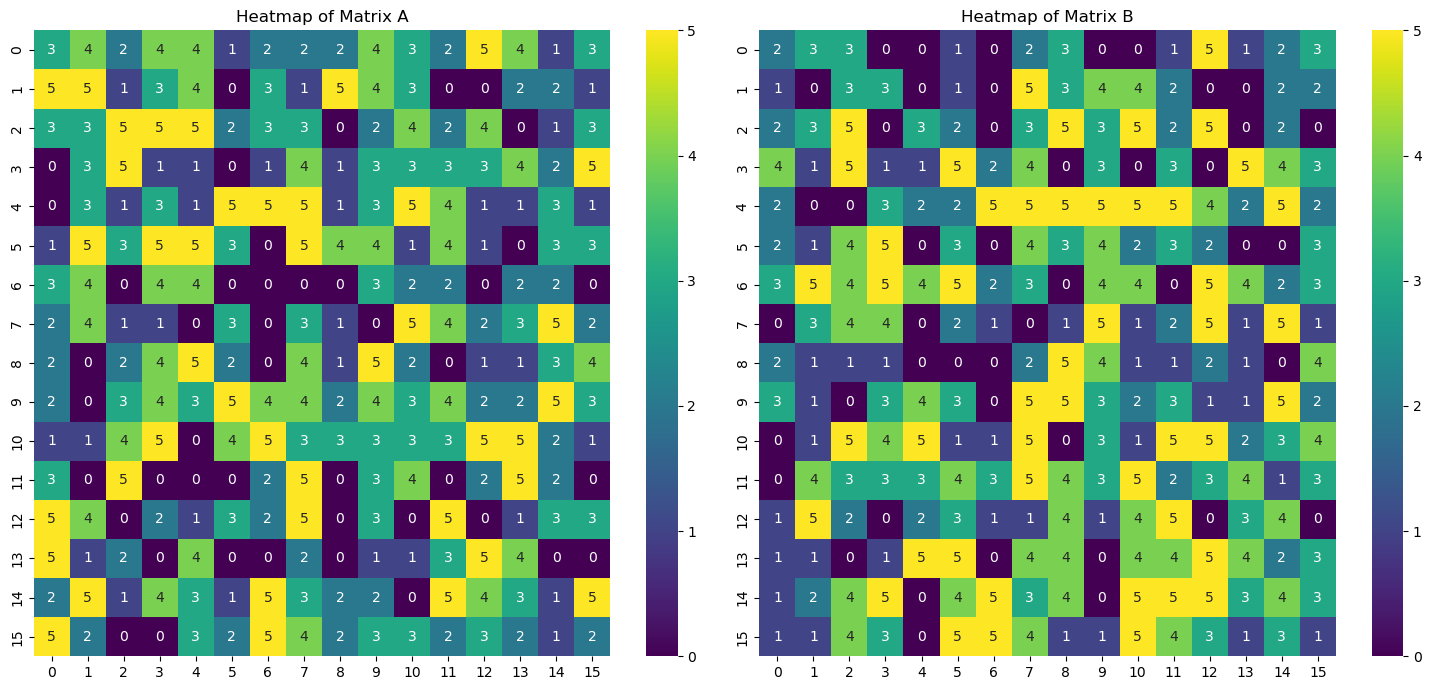

In [8]:
A = np.array([
    [3, 4, 2, 4, 4, 1, 2, 2, 2, 4, 3, 2, 5, 4, 1, 3],
    [5, 5, 1, 3, 4, 0, 3, 1, 5, 4, 3, 0, 0, 2, 2, 1],
    [3, 3, 5, 5, 5, 2, 3, 3, 0, 2, 4, 2, 4, 0, 1, 3],
    [0, 3, 5, 1, 1, 0, 1, 4, 1, 3, 3, 3, 3, 4, 2, 5],
    [0, 3, 1, 3, 1, 5, 5, 5, 1, 3, 5, 4, 1, 1, 3, 1],
    [1, 5, 3, 5, 5, 3, 0, 5, 4, 4, 1, 4, 1, 0, 3, 3],
    [3, 4, 0, 4, 4, 0, 0, 0, 0, 3, 2, 2, 0, 2, 2, 0],
    [2, 4, 1, 1, 0, 3, 0, 3, 1, 0, 5, 4, 2, 3, 5, 2],
    [2, 0, 2, 4, 5, 2, 0, 4, 1, 5, 2, 0, 1, 1, 3, 4],
    [2, 0, 3, 4, 3, 5, 4, 4, 2, 4, 3, 4, 2, 2, 5, 3],
    [1, 1, 4, 5, 0, 4, 5, 3, 3, 3, 3, 3, 5, 5, 2, 1],
    [3, 0, 5, 0, 0, 0, 2, 5, 0, 3, 4, 0, 2, 5, 2, 0],
    [5, 4, 0, 2, 1, 3, 2, 5, 0, 3, 0, 5, 0, 1, 3, 3],
    [5, 1, 2, 0, 4, 0, 0, 2, 0, 1, 1, 3, 5, 4, 0, 0],
    [2, 5, 1, 4, 3, 1, 5, 3, 2, 2, 0, 5, 4, 3, 1, 5],
    [5, 2, 0, 0, 3, 2, 5, 4, 2, 3, 3, 2, 3, 2, 1, 2],
])

B = np.array([
    [2, 3, 3, 0, 0, 1, 0, 2, 3, 0, 0, 1, 5, 1, 2, 3],
    [1, 0, 3, 3, 0, 1, 0, 5, 3, 4, 4, 2, 0, 0, 2, 2],
    [2, 3, 5, 0, 3, 2, 0, 3, 5, 3, 5, 2, 5, 0, 2, 0],
    [4, 1, 5, 1, 1, 5, 2, 4, 0, 3, 0, 3, 0, 5, 4, 3],
    [2, 0, 0, 3, 2, 2, 5, 5, 5, 5, 5, 5, 4, 2, 5, 2],
    [2, 1, 4, 5, 0, 3, 0, 4, 3, 4, 2, 3, 2, 0, 0, 3],
    [3, 5, 4, 5, 4, 5, 2, 3, 0, 4, 4, 0, 5, 4, 2, 3],
    [0, 3, 4, 4, 0, 2, 1, 0, 1, 5, 1, 2, 5, 1, 5, 1],
    [2, 1, 1, 1, 0, 0, 0, 2, 5, 4, 1, 1, 2, 1, 0, 4],
    [3, 1, 0, 3, 4, 3, 0, 5, 5, 3, 2, 3, 1, 1, 5, 2],
    [0, 1, 5, 4, 5, 1, 1, 5, 0, 3, 1, 5, 5, 2, 3, 4],
    [0, 4, 3, 3, 3, 4, 3, 5, 4, 3, 5, 2, 3, 4, 1, 3],
    [1, 5, 2, 0, 2, 3, 1, 1, 4, 1, 4, 5, 0, 3, 4, 0],
    [1, 1, 0, 1, 5, 5, 0, 4, 4, 0, 4, 4, 5, 4, 2, 3],
    [1, 2, 4, 5, 0, 4, 5, 3, 4, 0, 5, 5, 5, 3, 4, 3],
    [1, 1, 4, 3, 0, 5, 5, 4, 1, 1, 5, 4, 3, 1, 3, 1],
])


fig, axes = plt.subplots(1, 2, figsize=(15, 7)) # Adjust figsize for a bigger figure

# Heatmap for matrix A
sns.heatmap(A, annot=True, fmt="d", cmap="viridis", ax=axes[0])
axes[0].set_title('Heatmap of Matrix A')

# Heatmap for matrix B
sns.heatmap(B, annot=True, fmt="d", cmap="viridis", ax=axes[1])
axes[1].set_title('Heatmap of Matrix B')

plt.tight_layout() 
plt.show()

Starting Strassen multiplication with visualization...

Processing Level 0 - Matrix dimension 16x16
Saved strassen_output/T_matrices_level_0.png


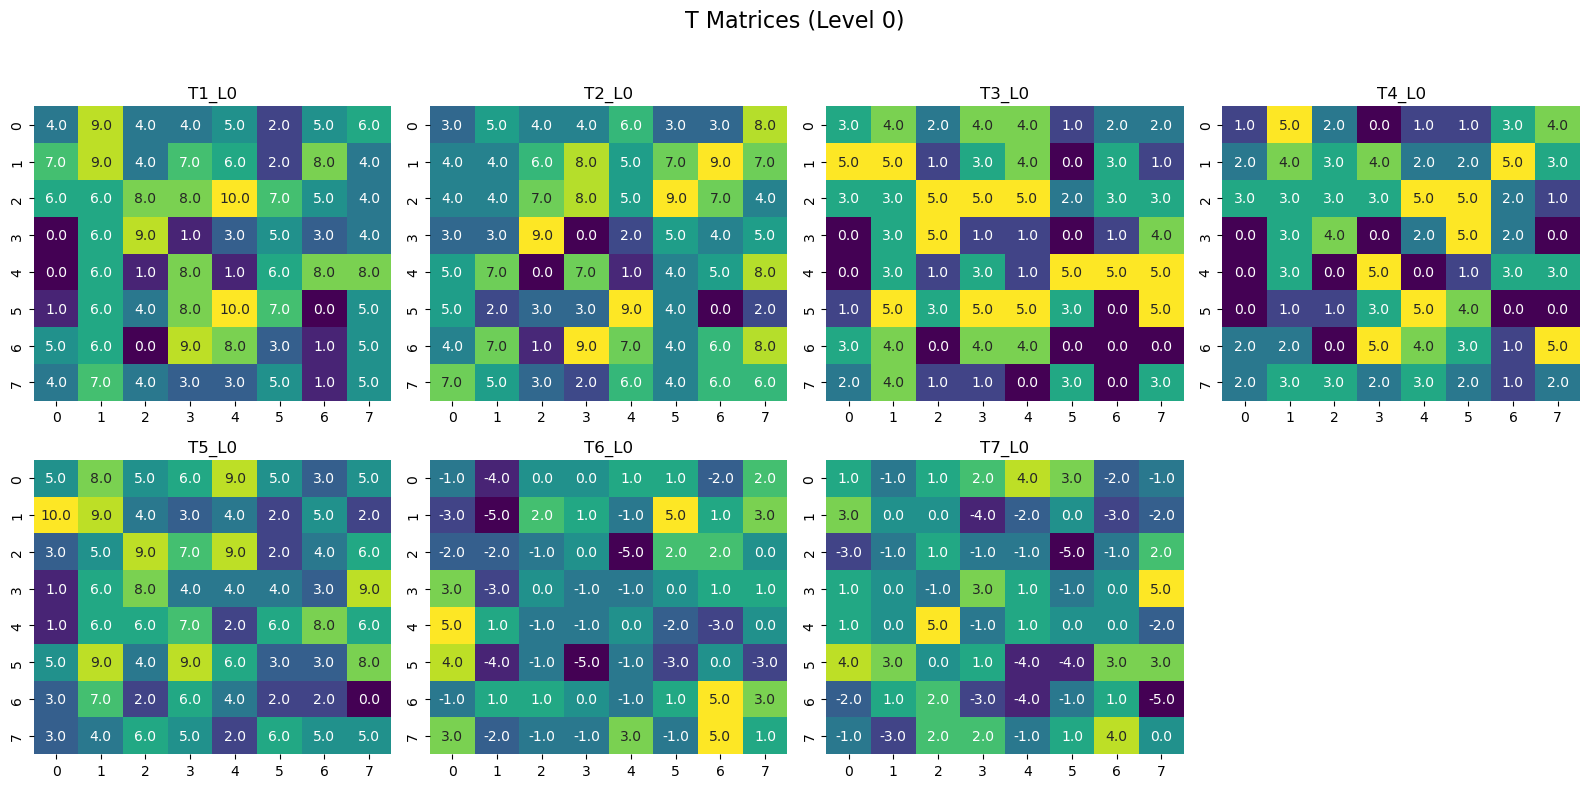

Saved strassen_output/S_matrices_level_0.png


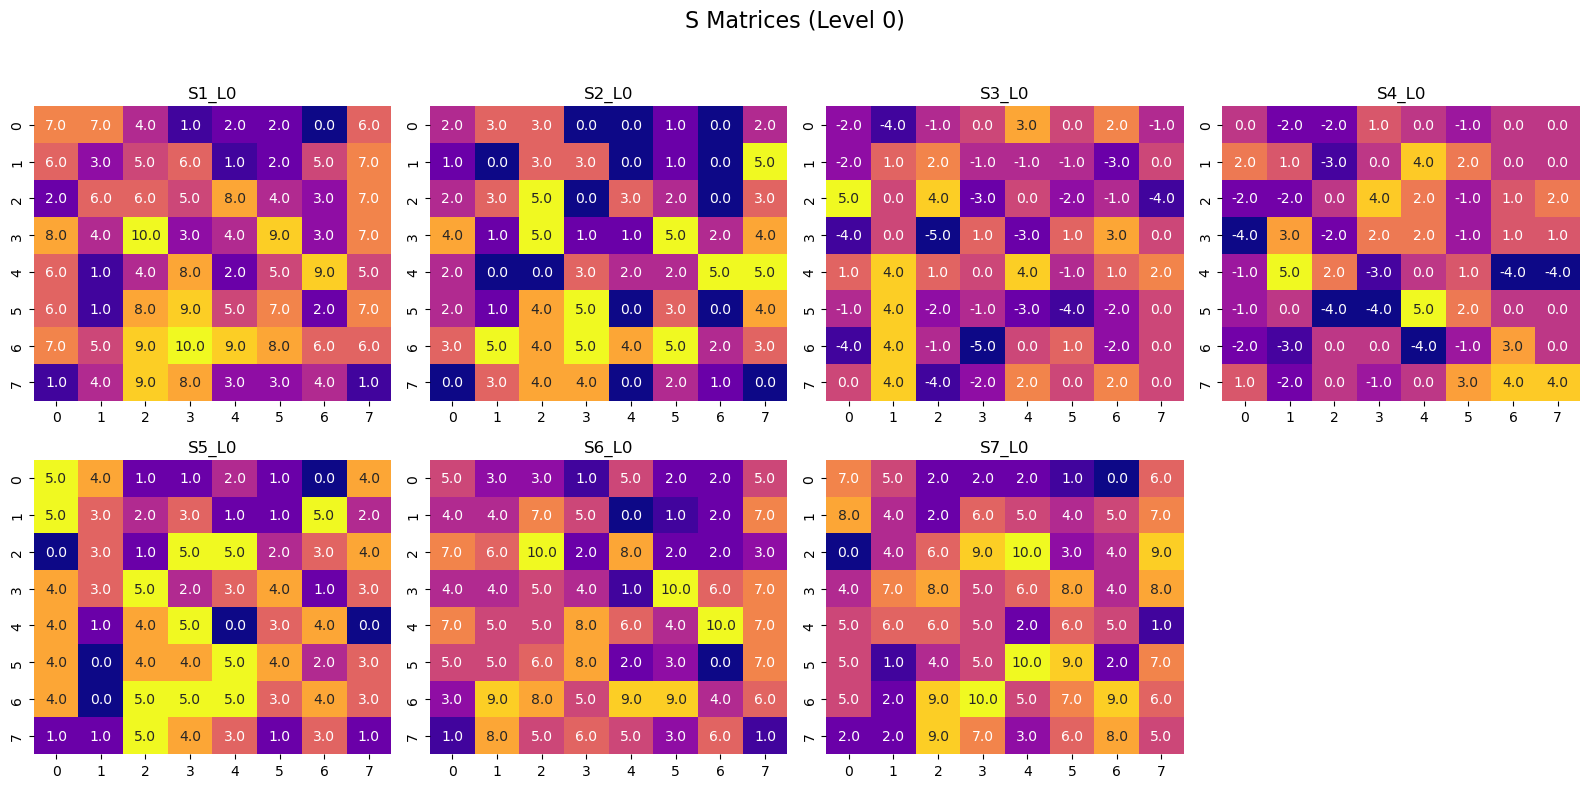


Processing Level 1 - Matrix dimension 8x8
Saved strassen_output/T_matrices_level_1.png


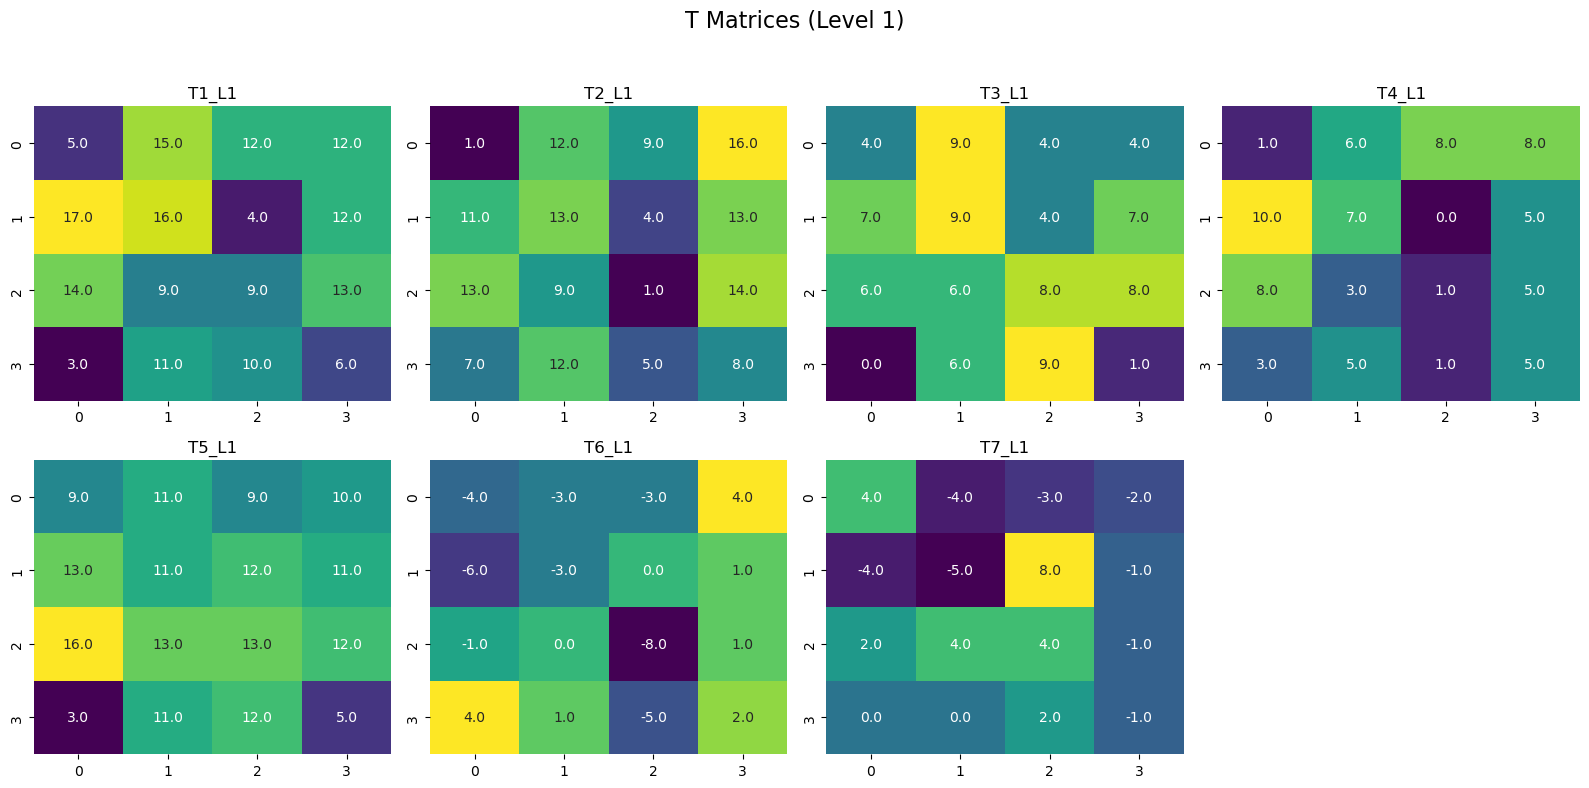

Saved strassen_output/S_matrices_level_1.png


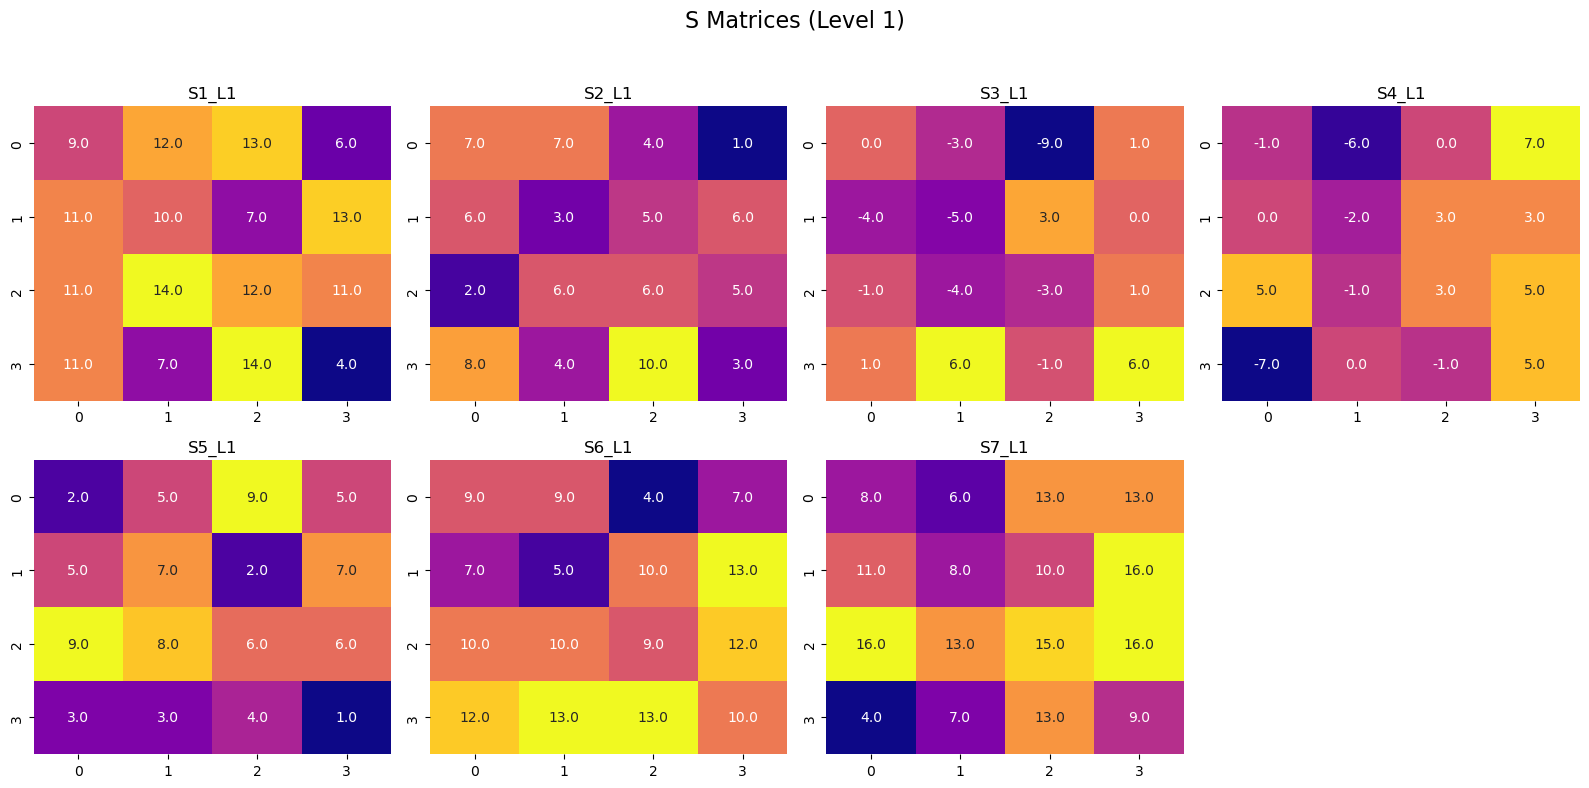

Saved strassen_output/Q_matrices_level_1.png


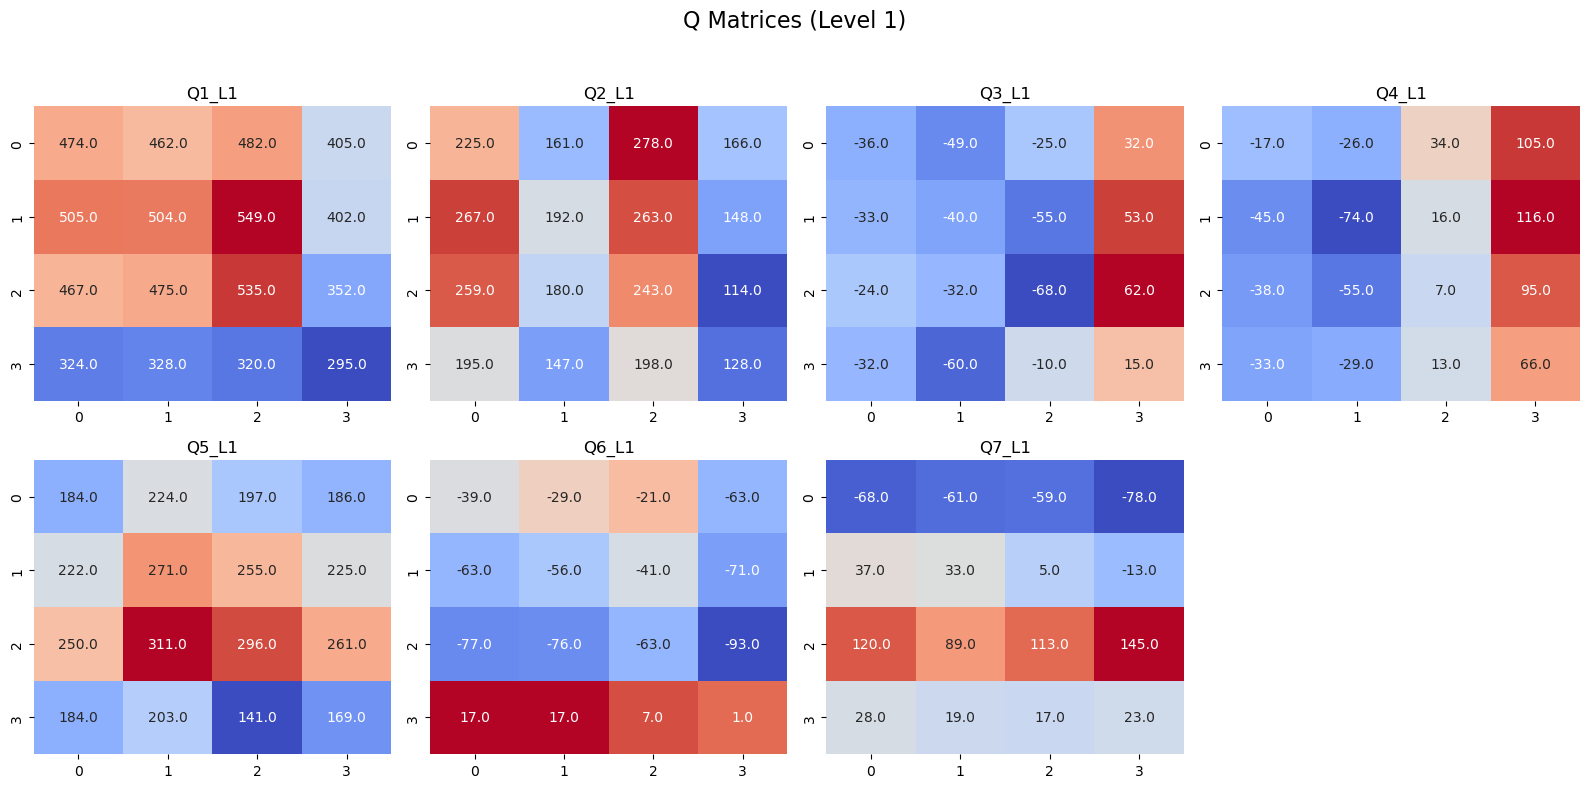

Saved strassen_output/C_matrices_level_1.png


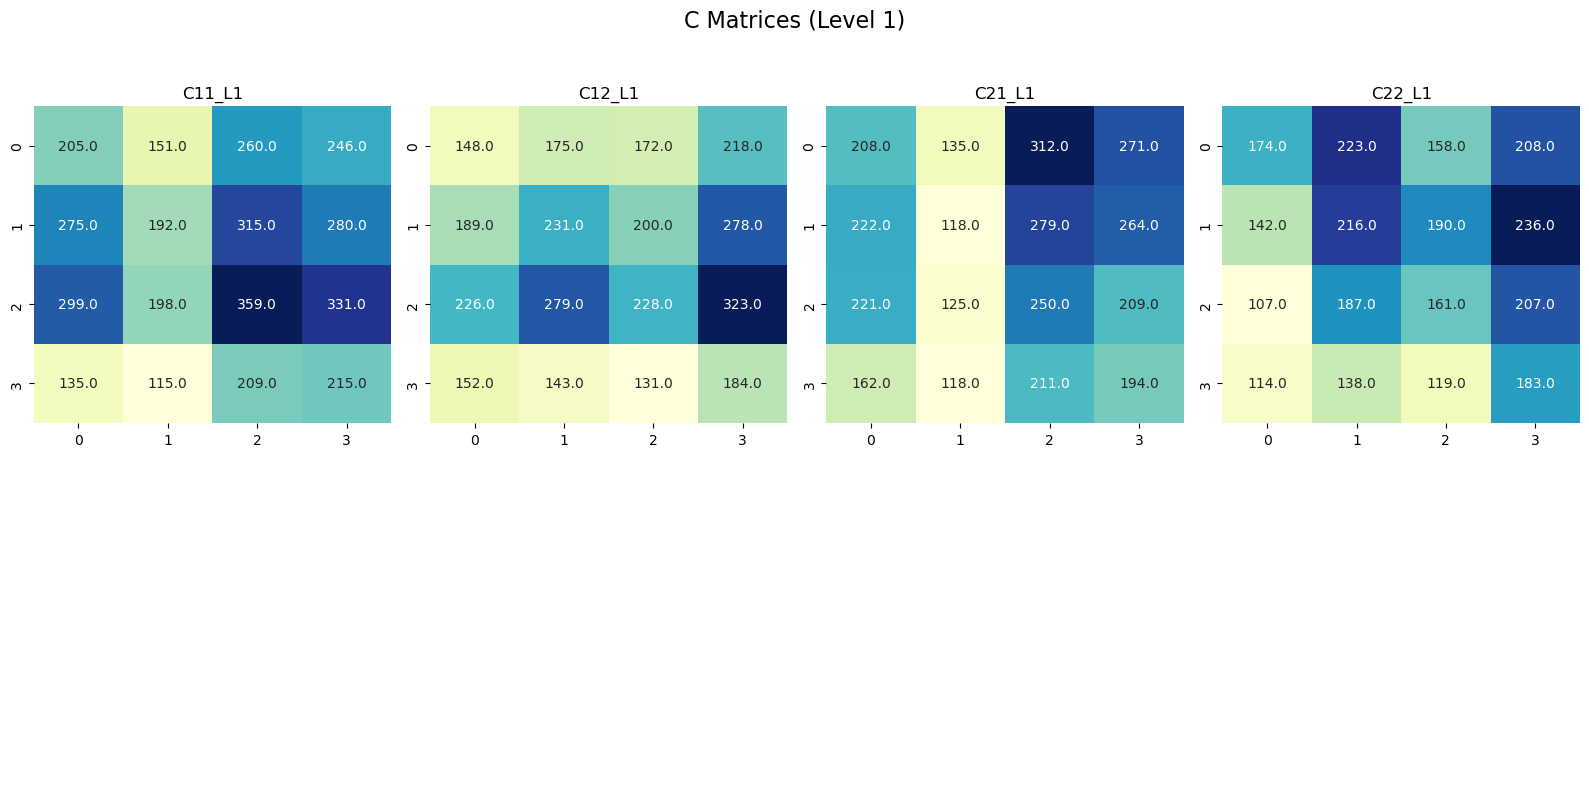

Saved strassen_output/Q1_L1_formation.png


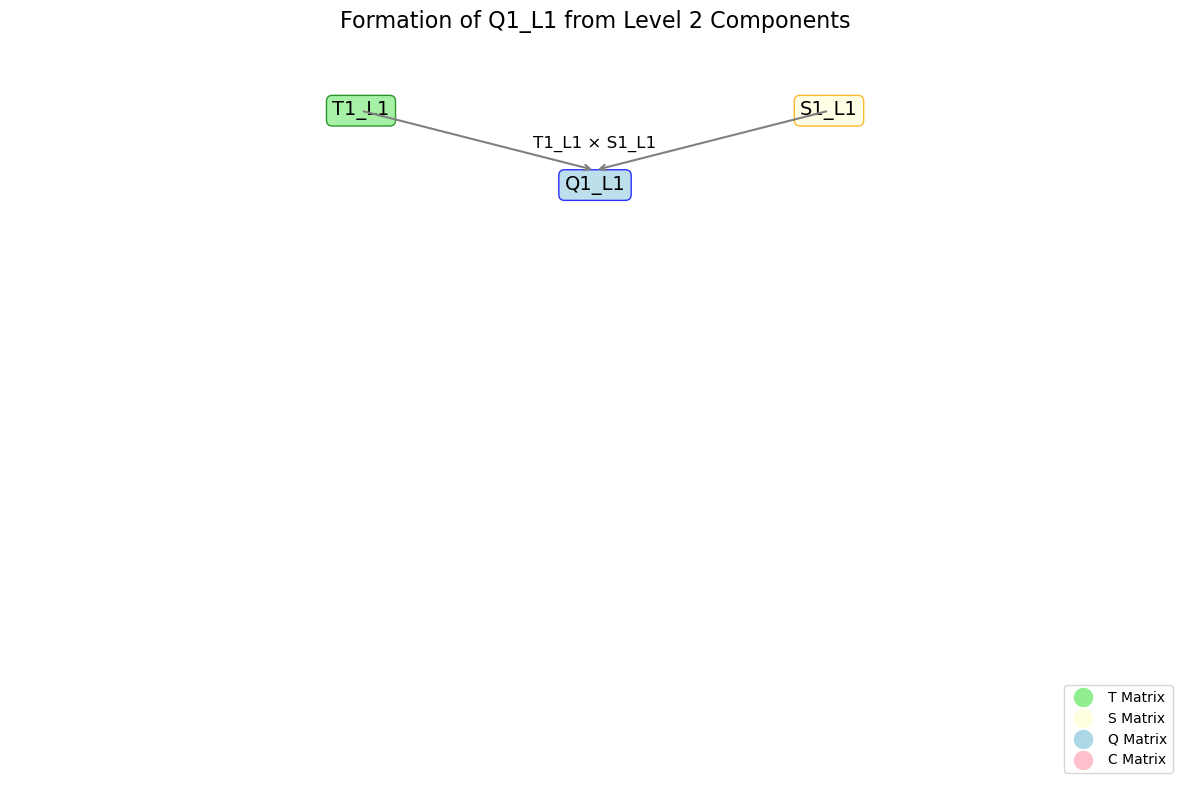

Saved strassen_output/Q2_L1_formation.png


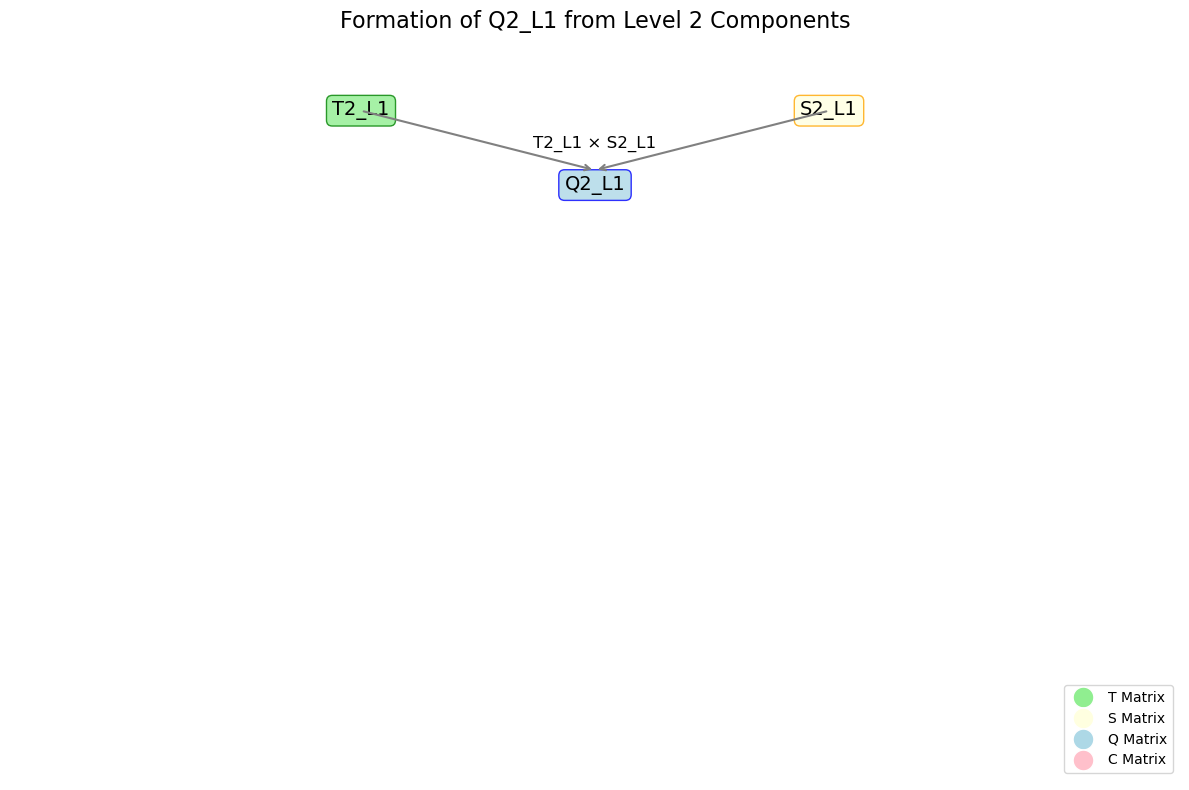

Saved strassen_output/Q3_L1_formation.png


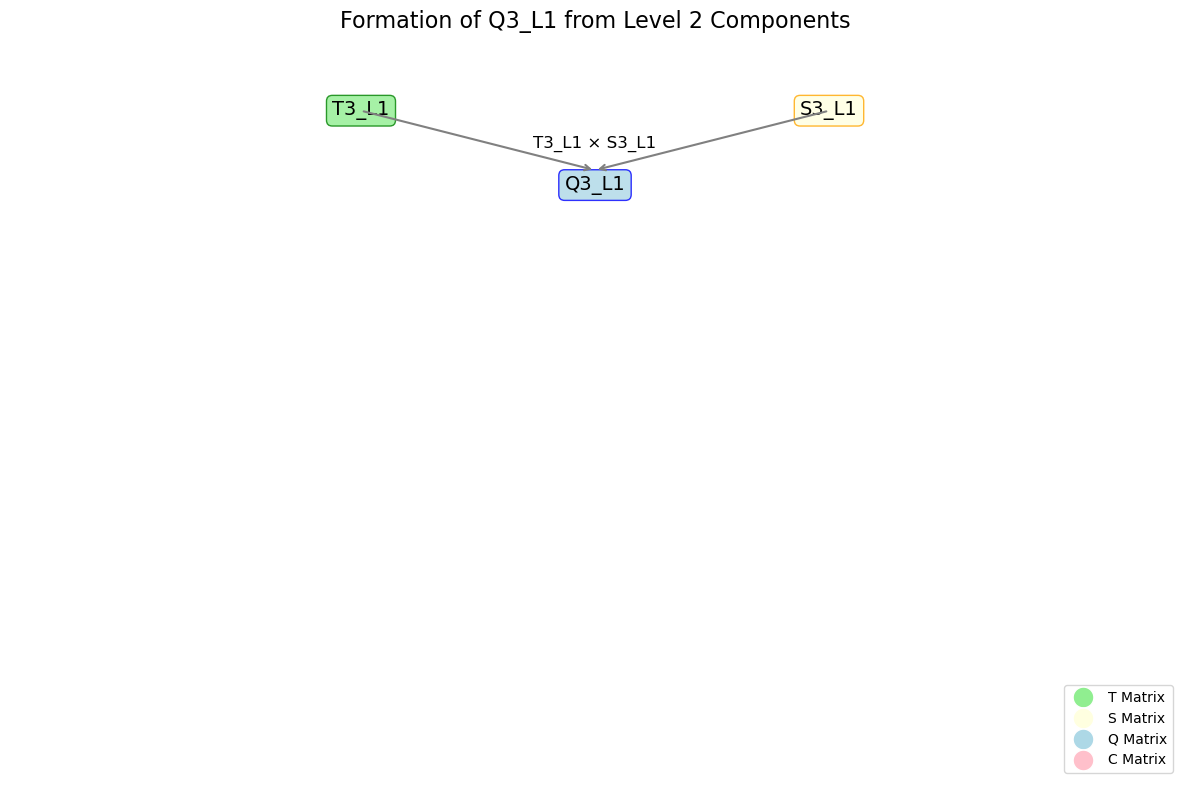

Saved strassen_output/Q4_L1_formation.png


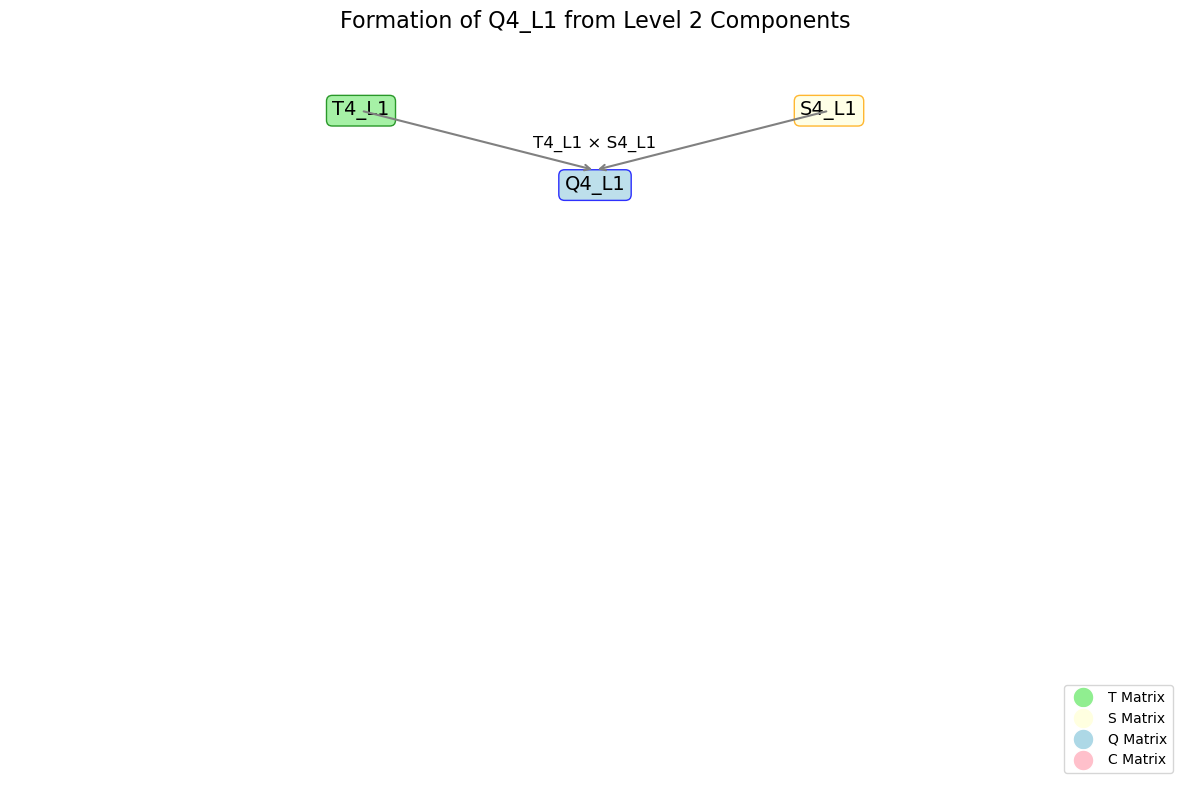

Saved strassen_output/Q5_L1_formation.png


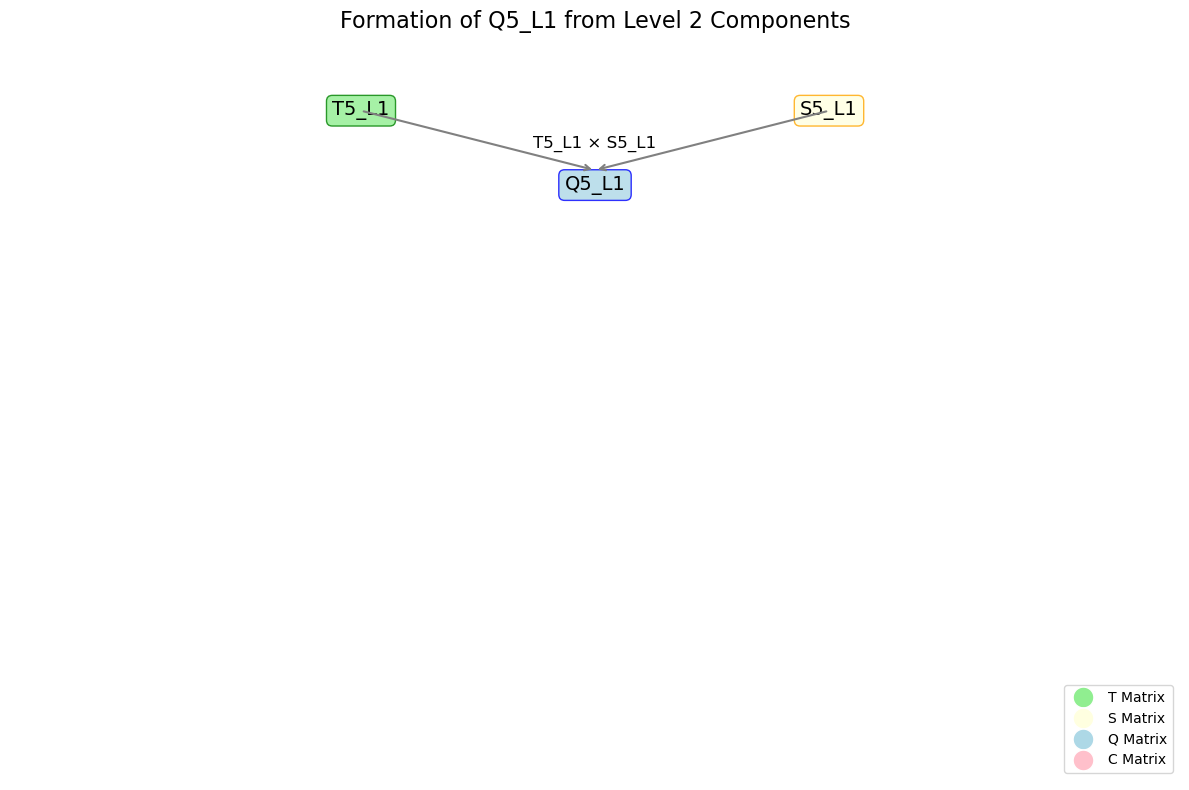

Saved strassen_output/Q6_L1_formation.png


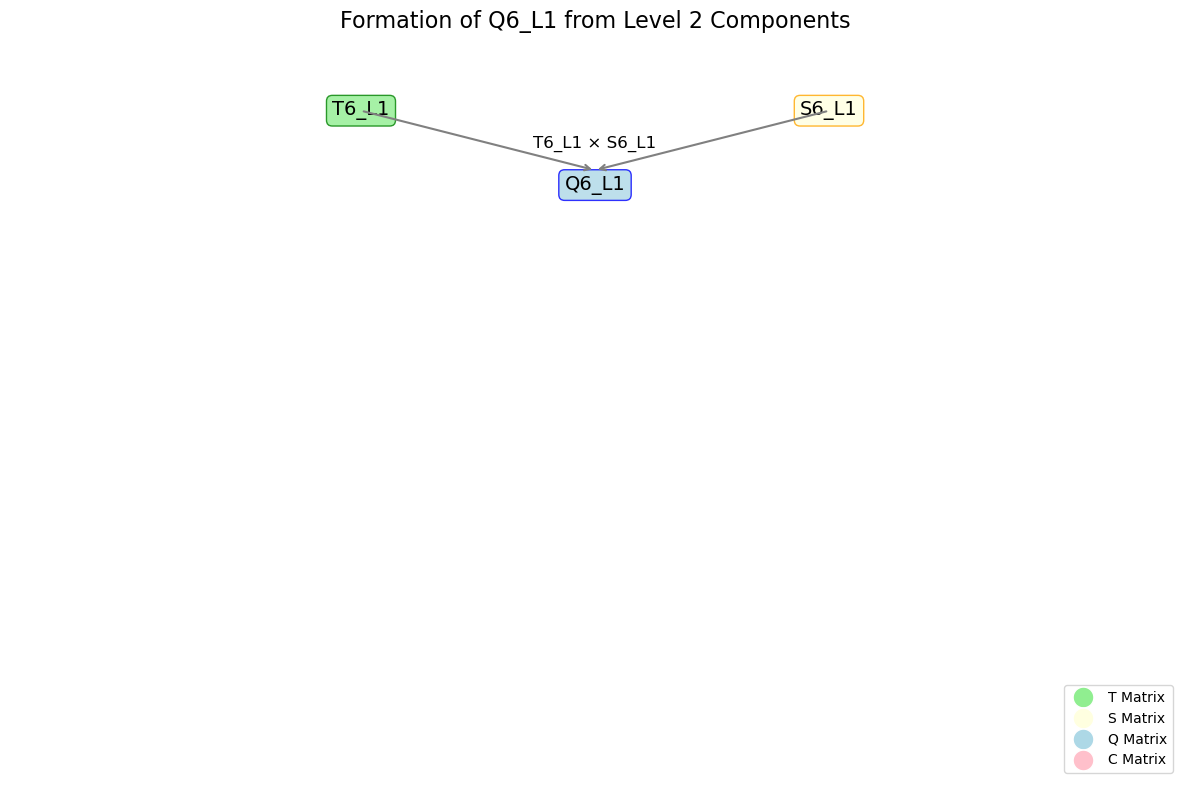

Saved strassen_output/Q7_L1_formation.png


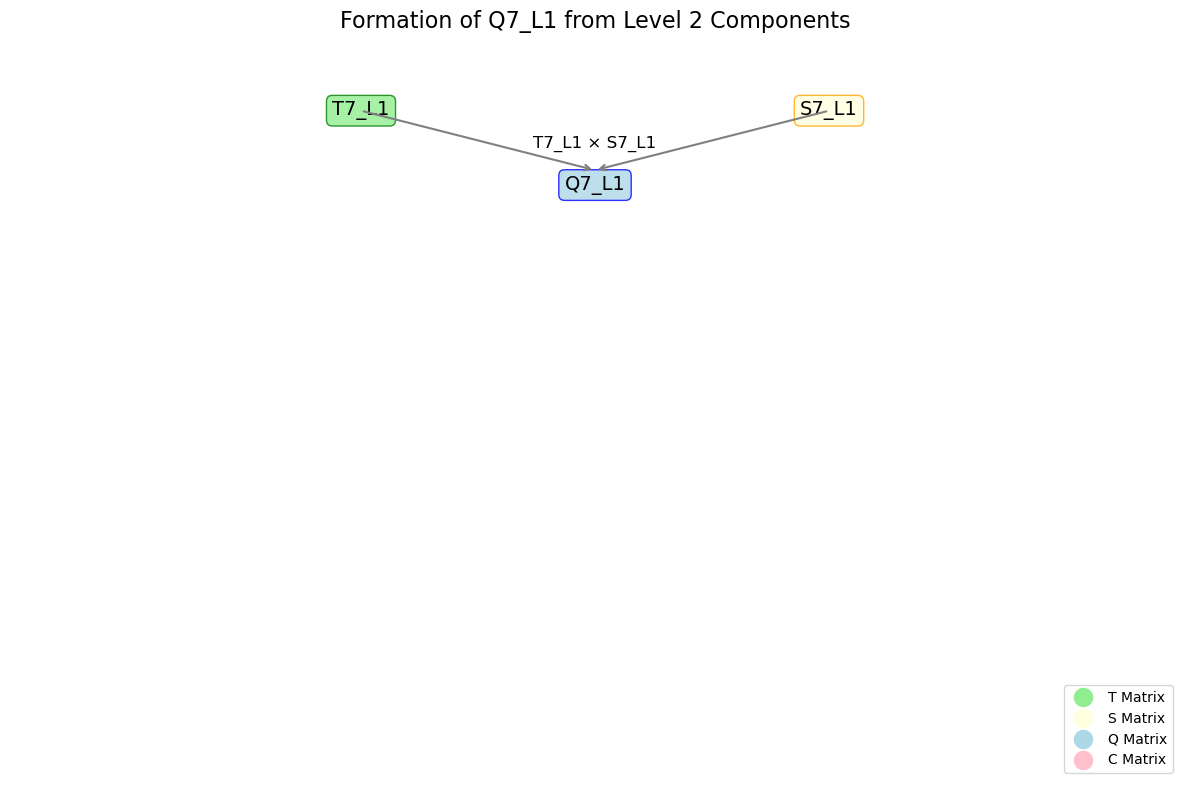


Processing Level 1 - Matrix dimension 8x8
Saved strassen_output/T_matrices_level_1.png


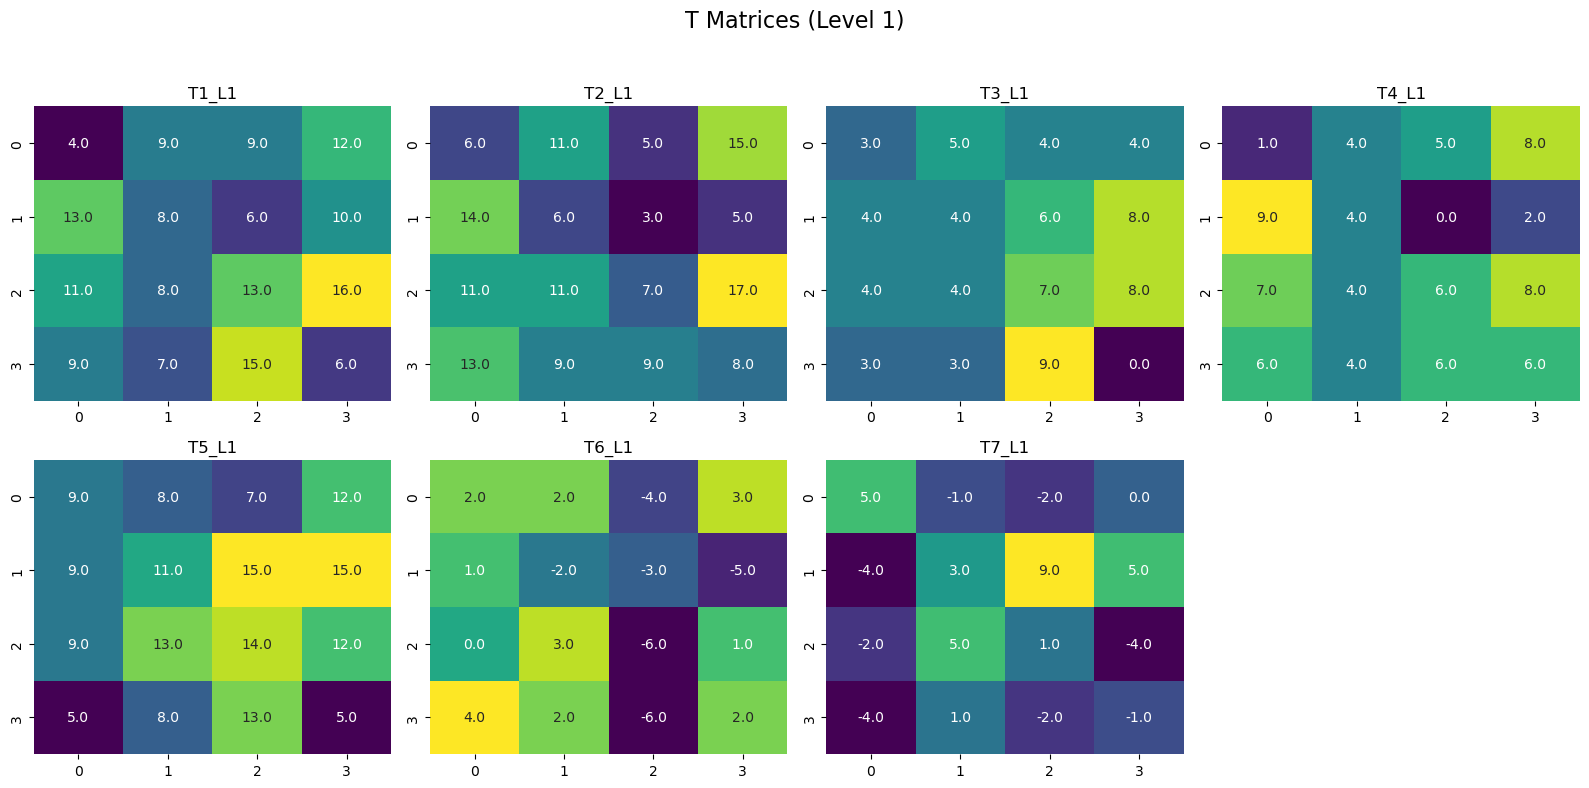

Saved strassen_output/S_matrices_level_1.png


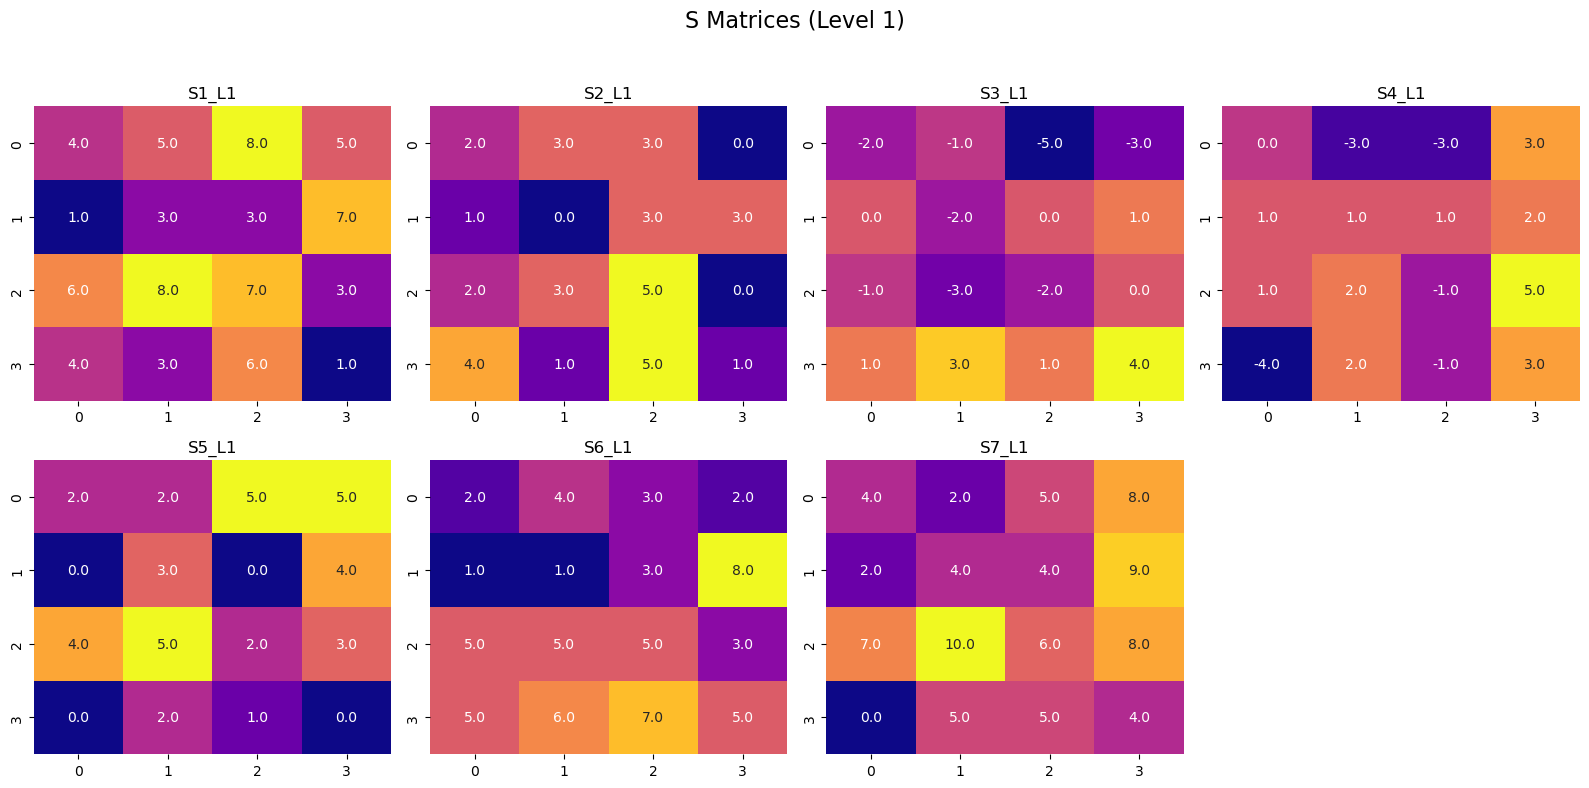

Saved strassen_output/Q_matrices_level_1.png


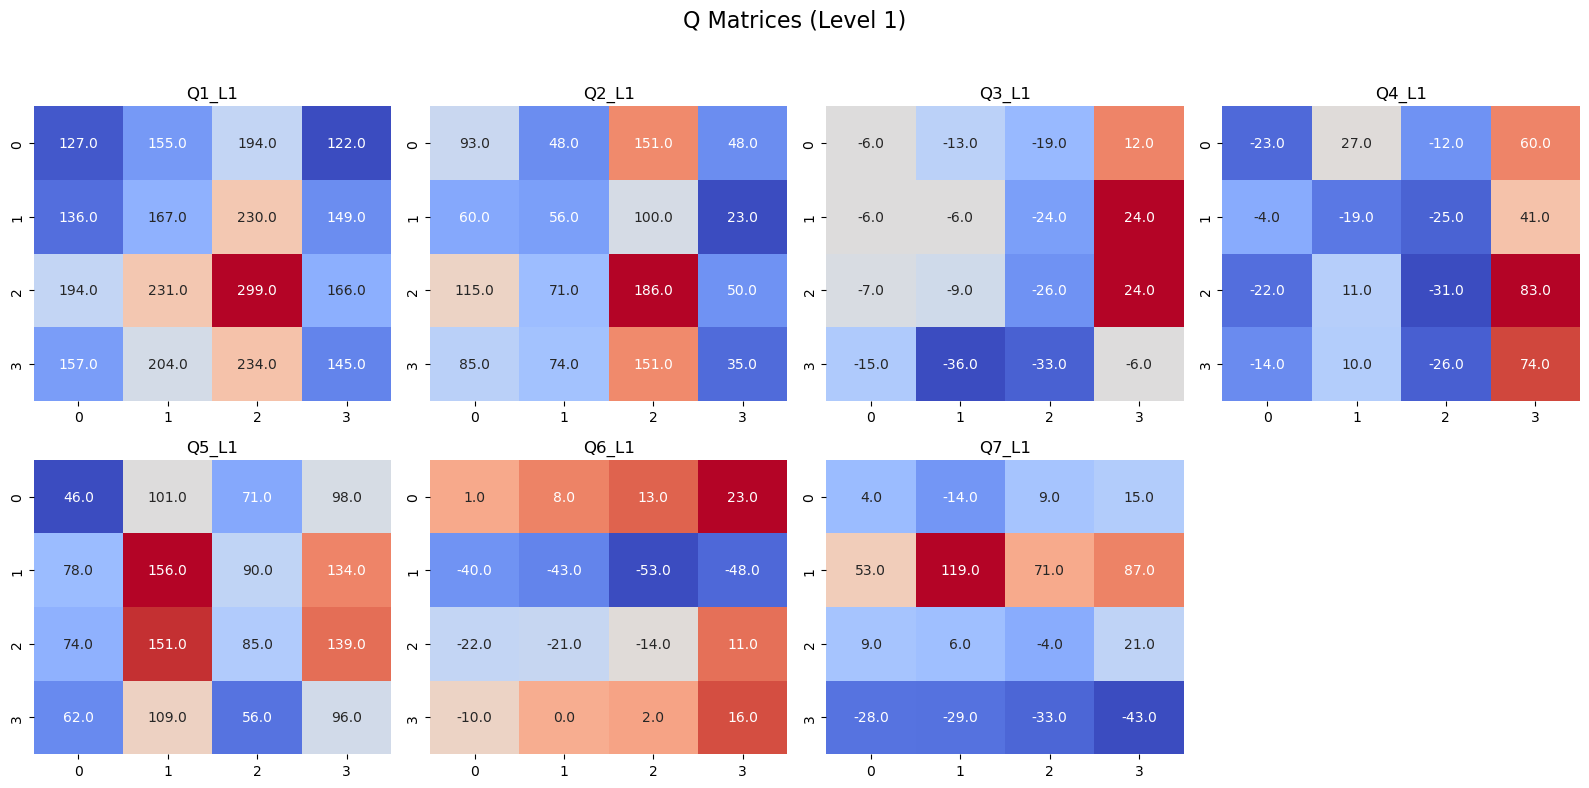

Saved strassen_output/C_matrices_level_1.png


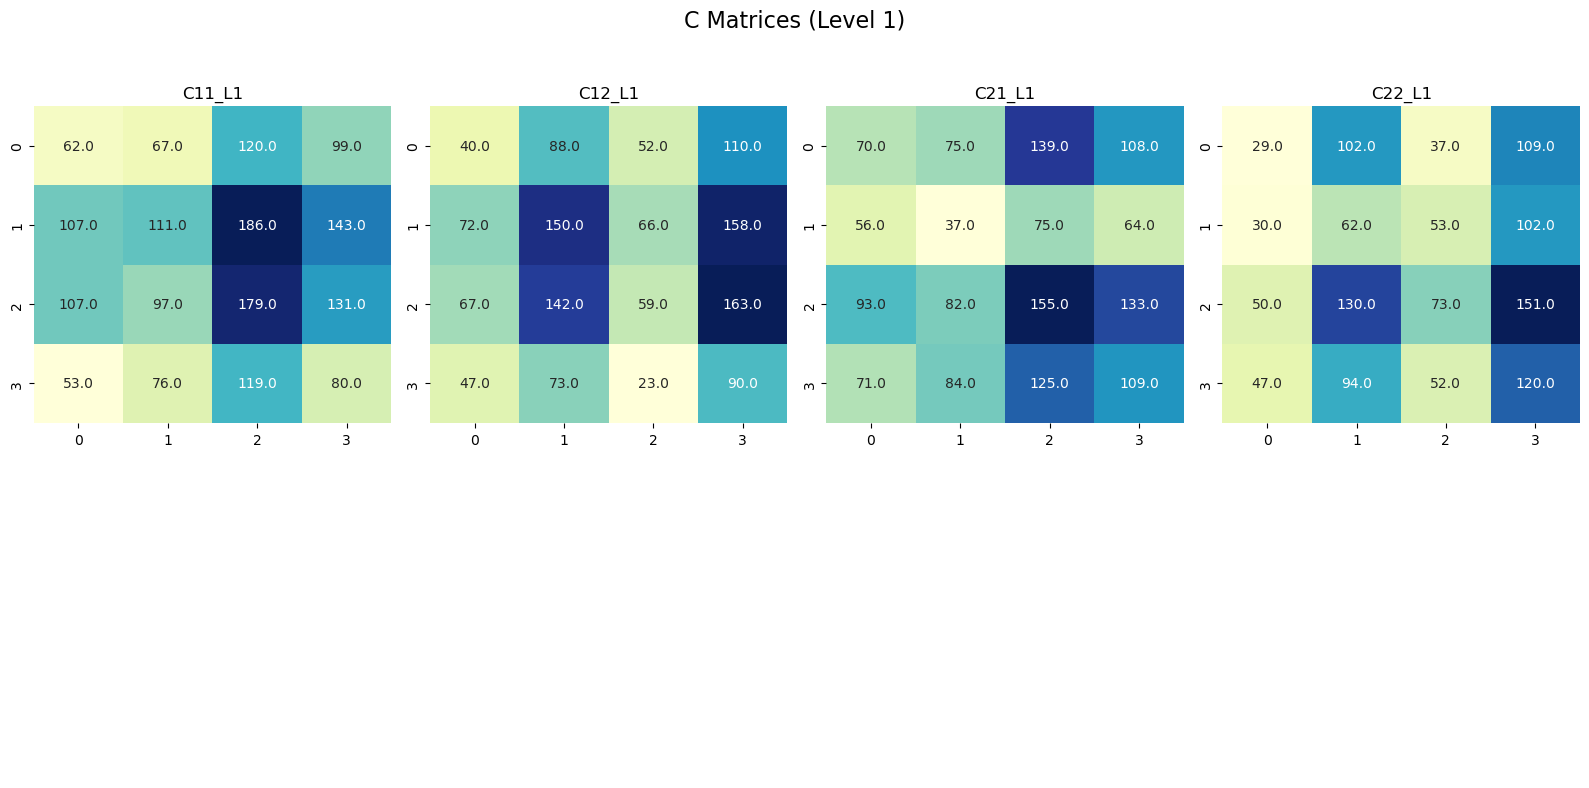

Saved strassen_output/Q1_L1_formation.png


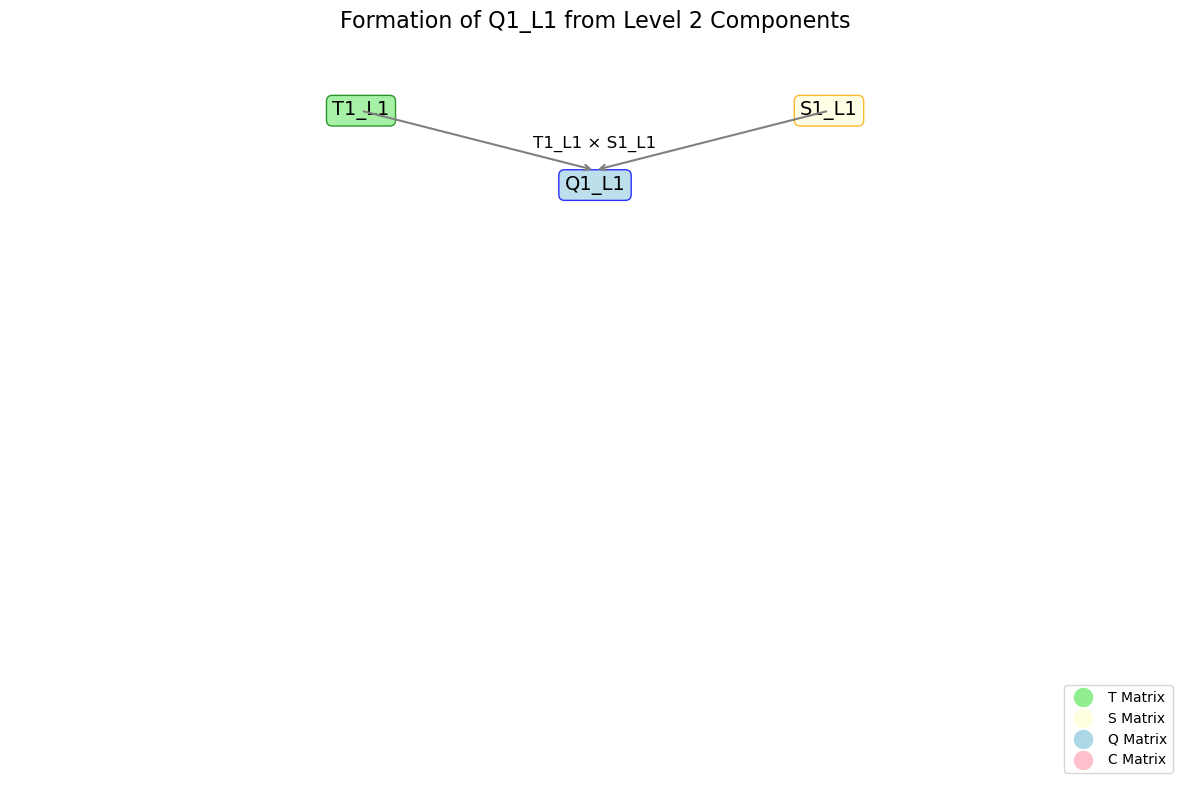

Saved strassen_output/Q2_L1_formation.png


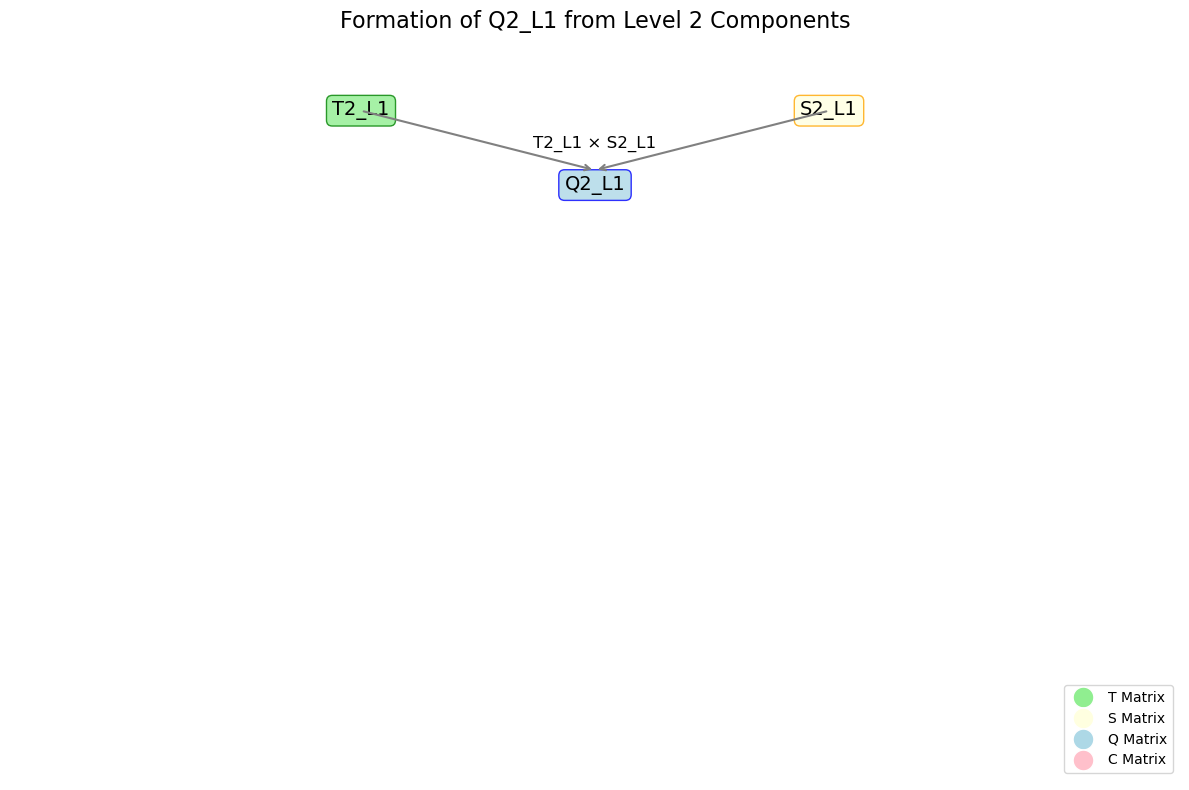

Saved strassen_output/Q3_L1_formation.png


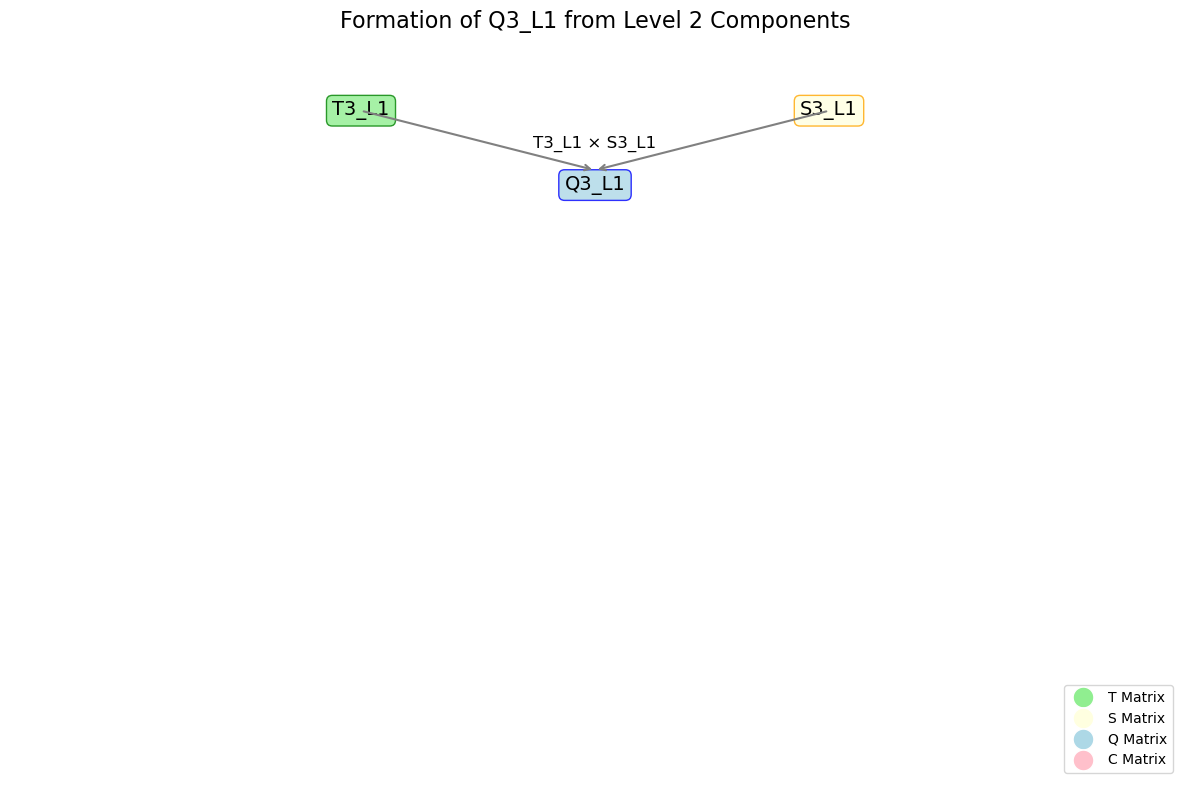

Saved strassen_output/Q4_L1_formation.png


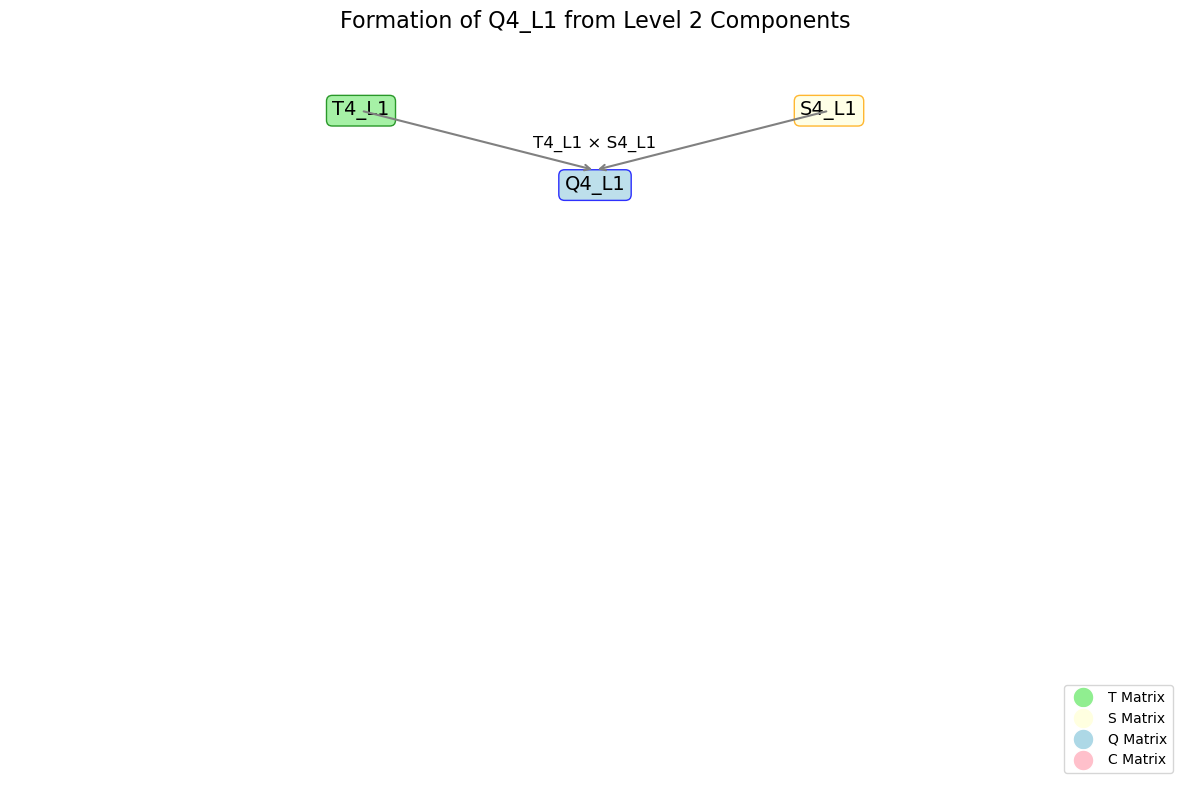

Saved strassen_output/Q5_L1_formation.png


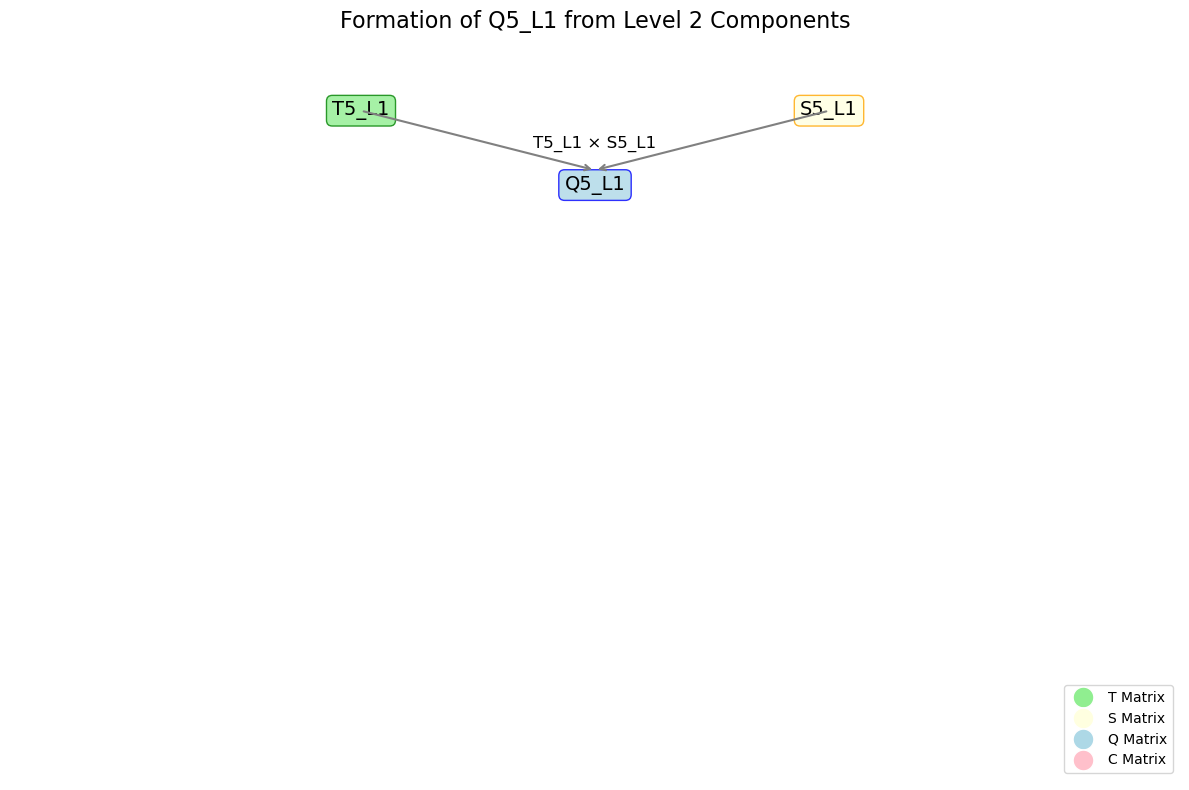

Saved strassen_output/Q6_L1_formation.png


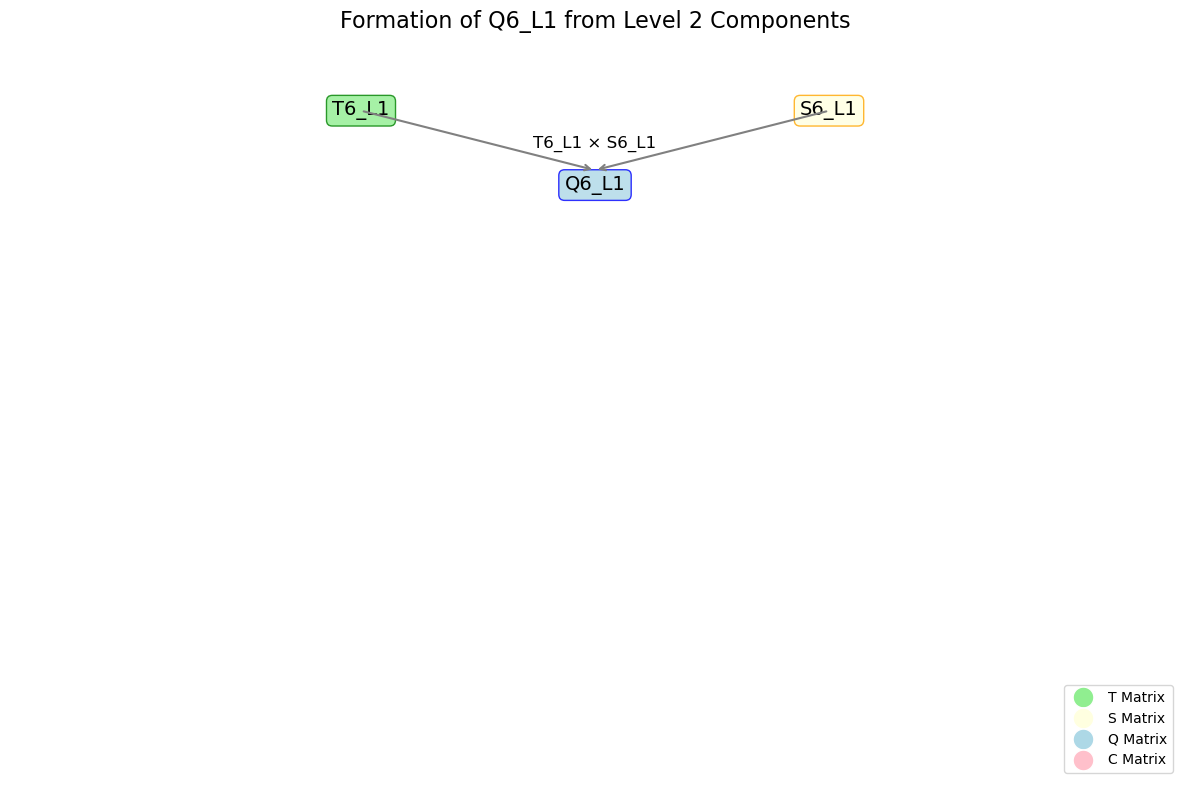

Saved strassen_output/Q7_L1_formation.png


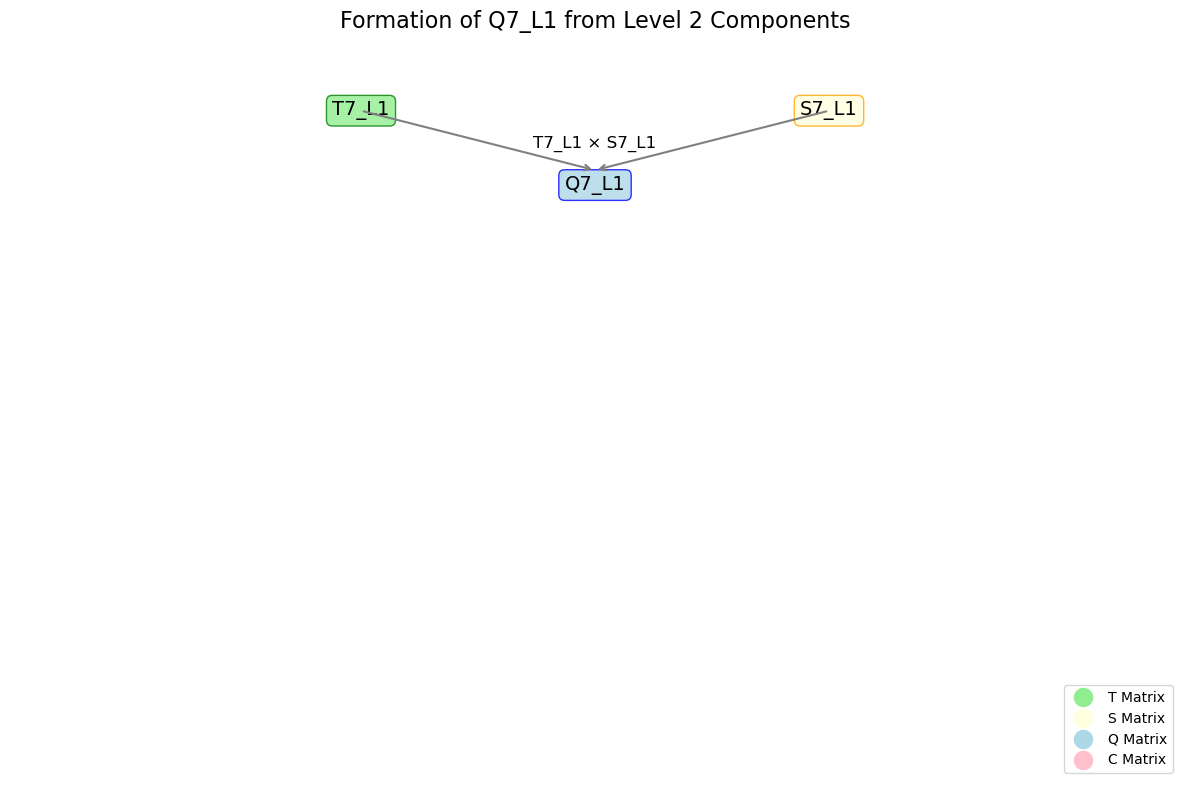


Processing Level 1 - Matrix dimension 8x8
Saved strassen_output/T_matrices_level_1.png


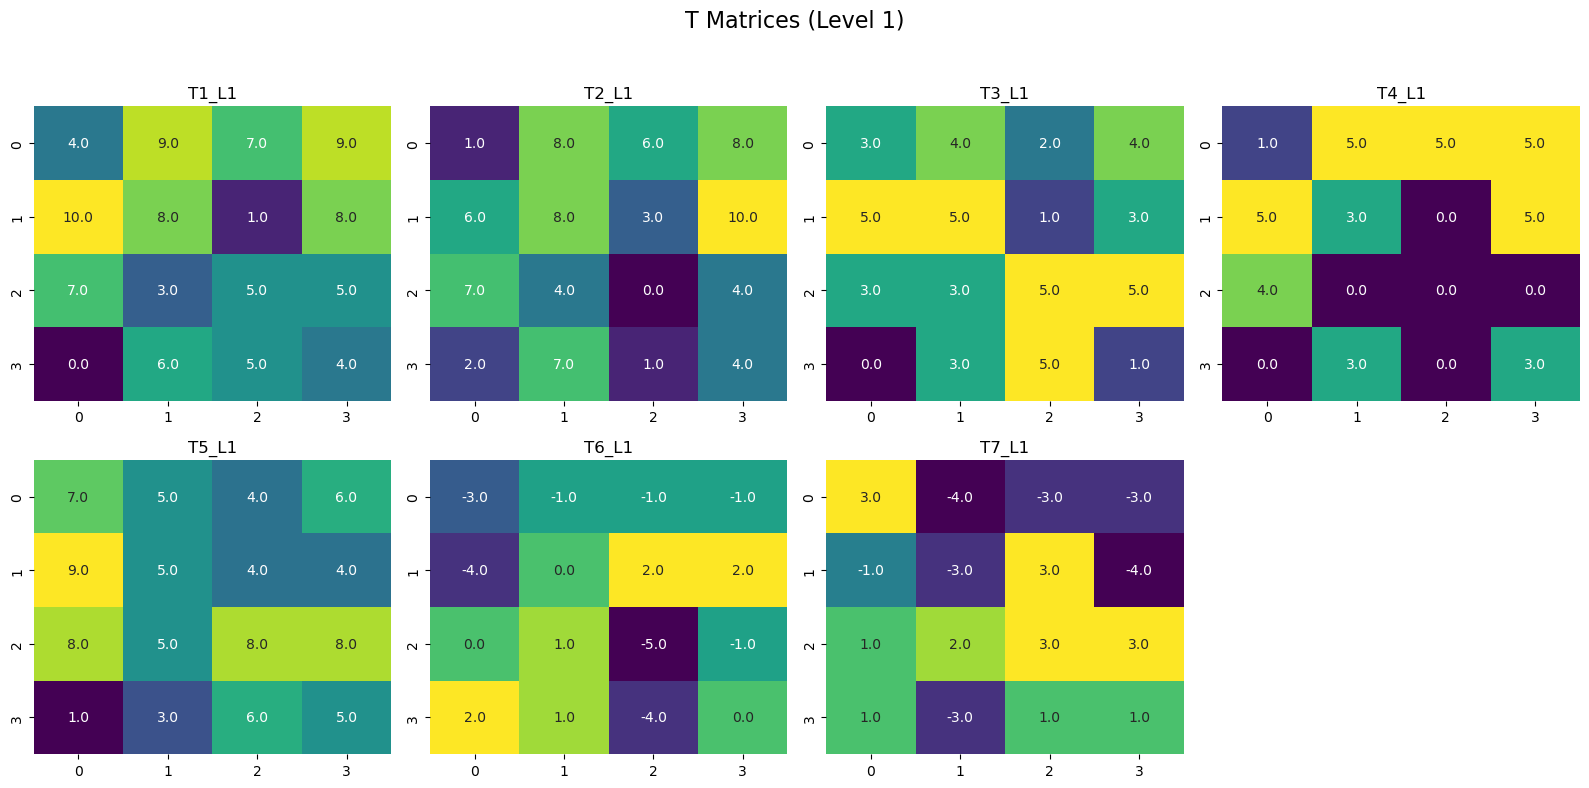

Saved strassen_output/S_matrices_level_1.png


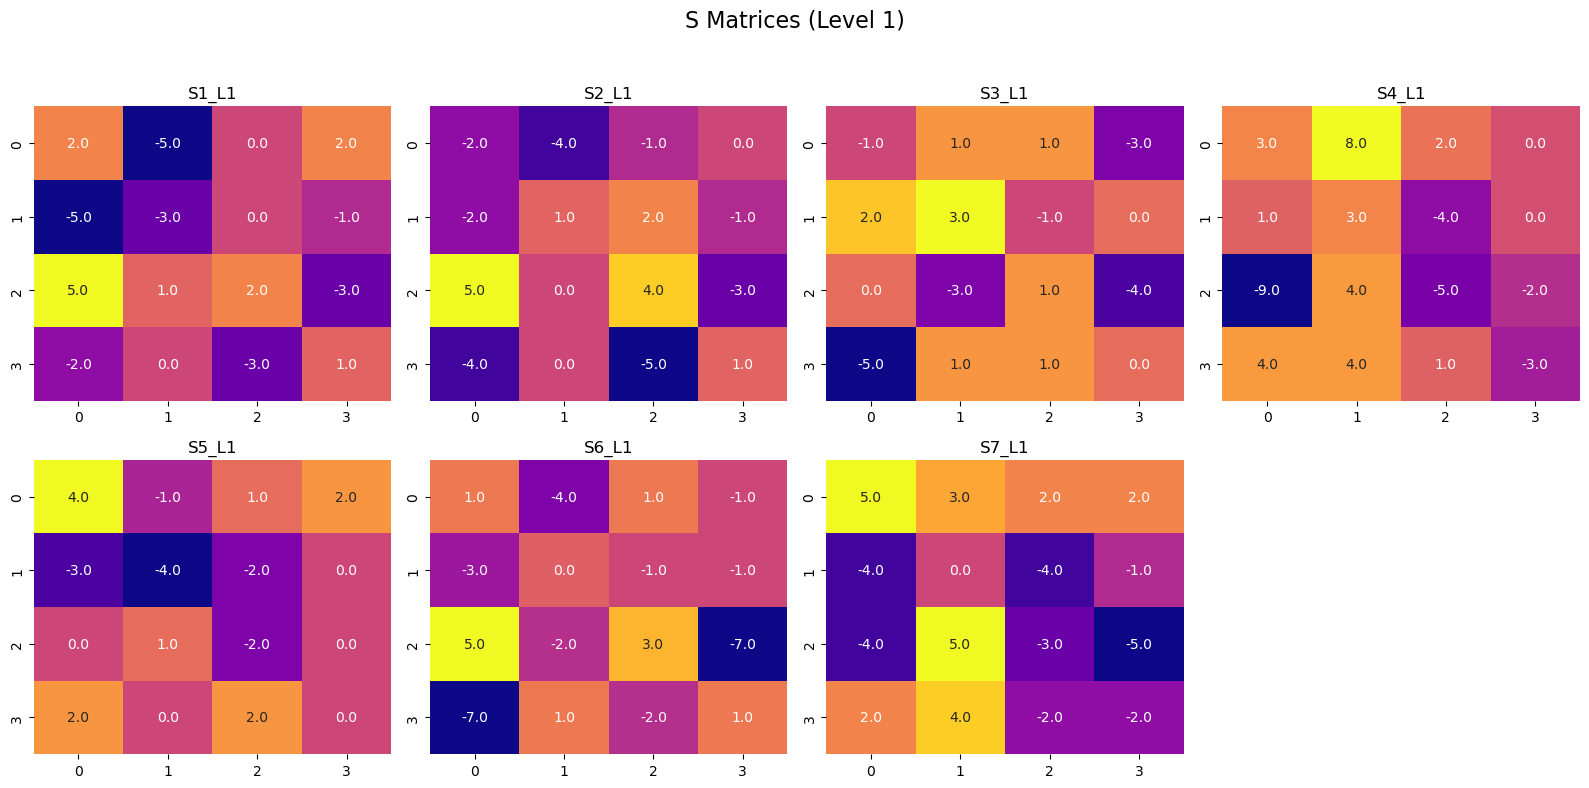

Saved strassen_output/Q_matrices_level_1.png


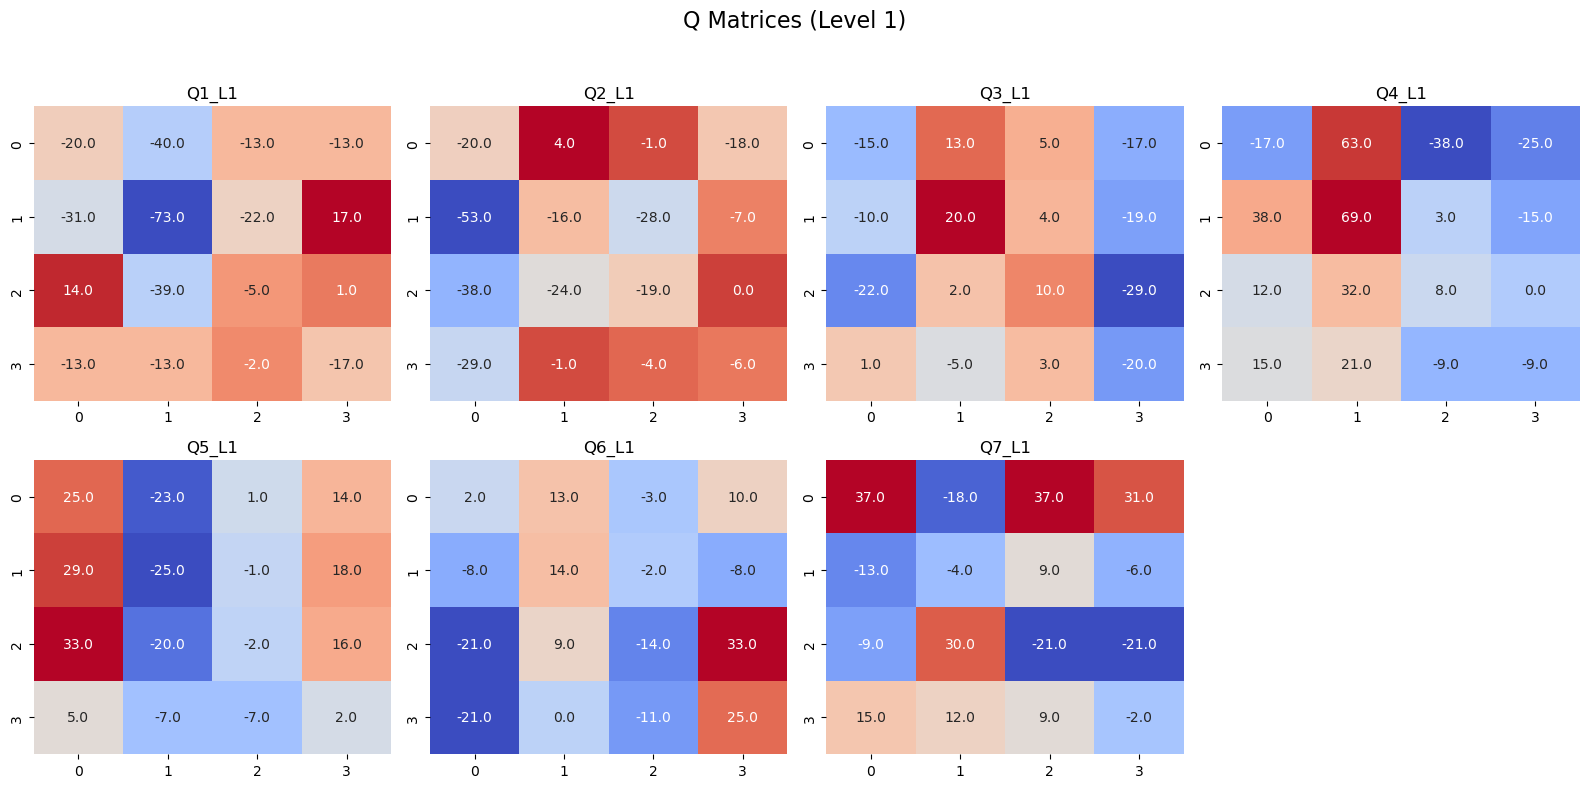

Saved strassen_output/C_matrices_level_1.png


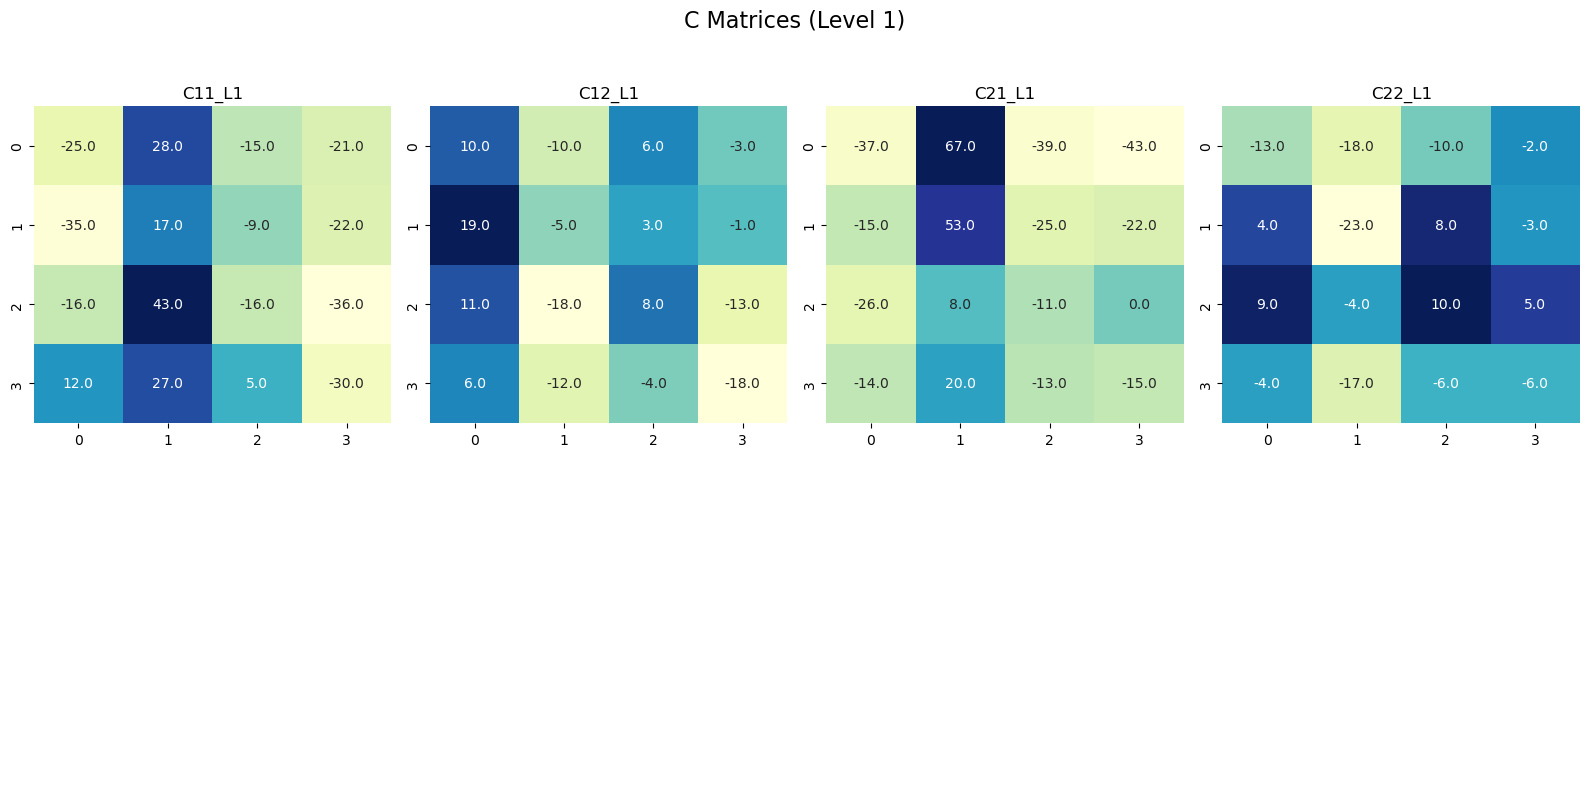

Saved strassen_output/Q1_L1_formation.png


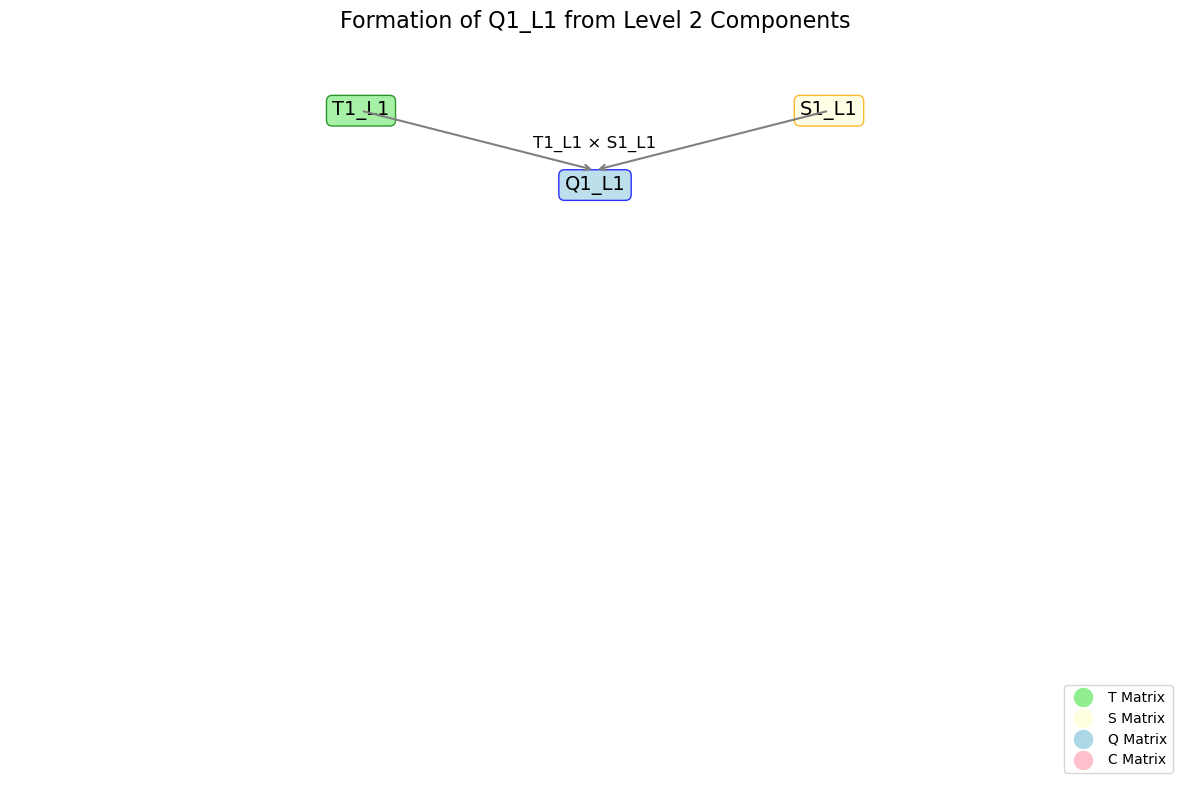

Saved strassen_output/Q2_L1_formation.png


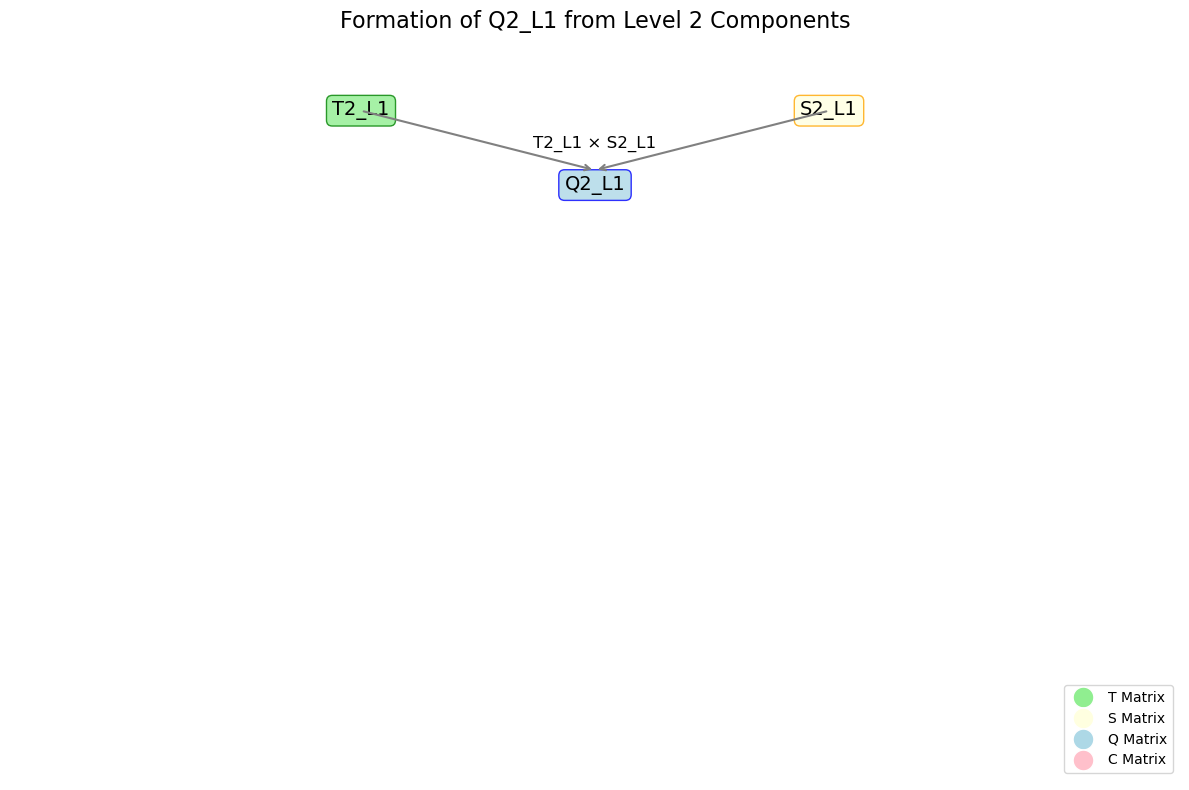

Saved strassen_output/Q3_L1_formation.png


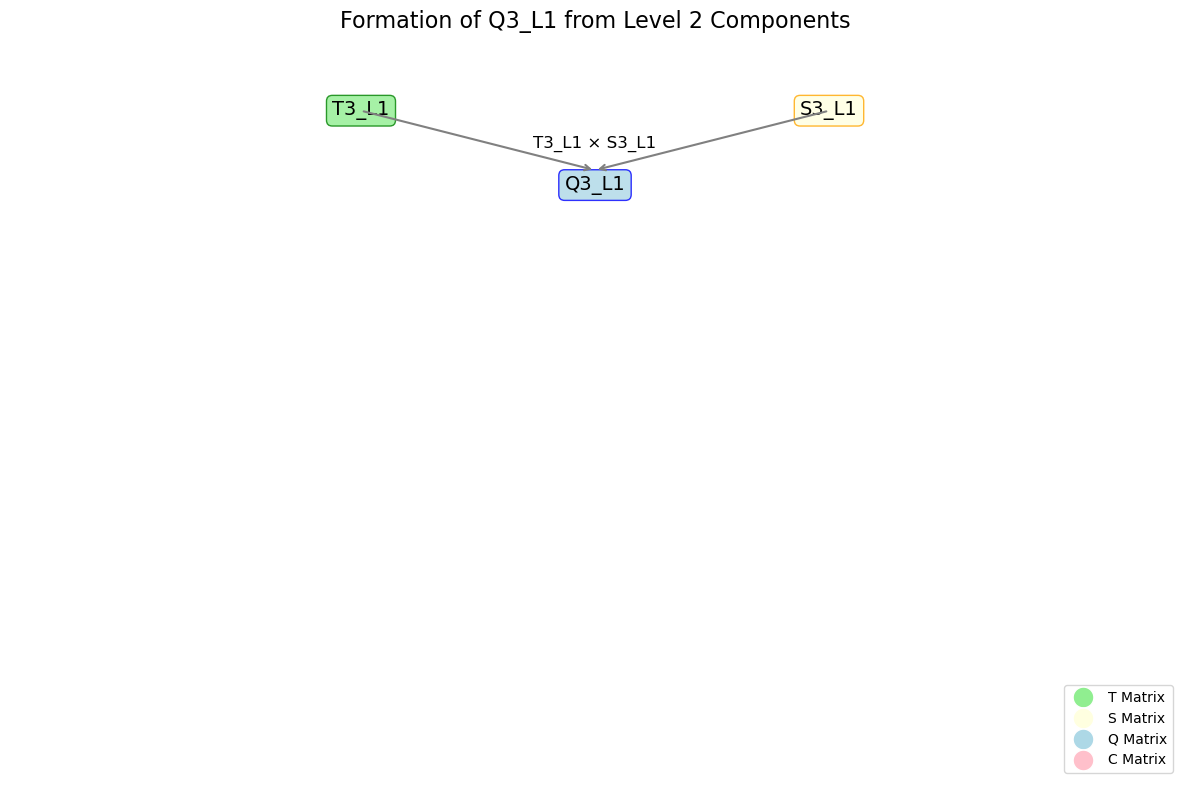

Saved strassen_output/Q4_L1_formation.png


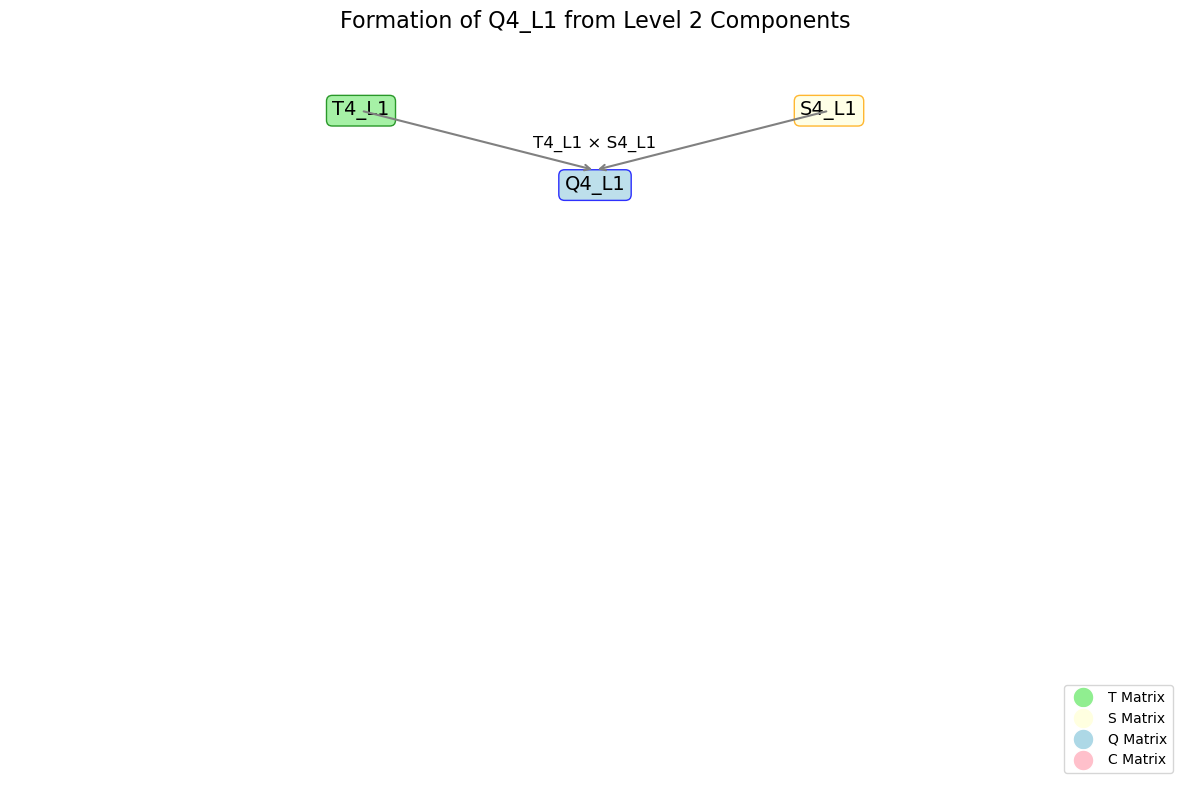

Saved strassen_output/Q5_L1_formation.png


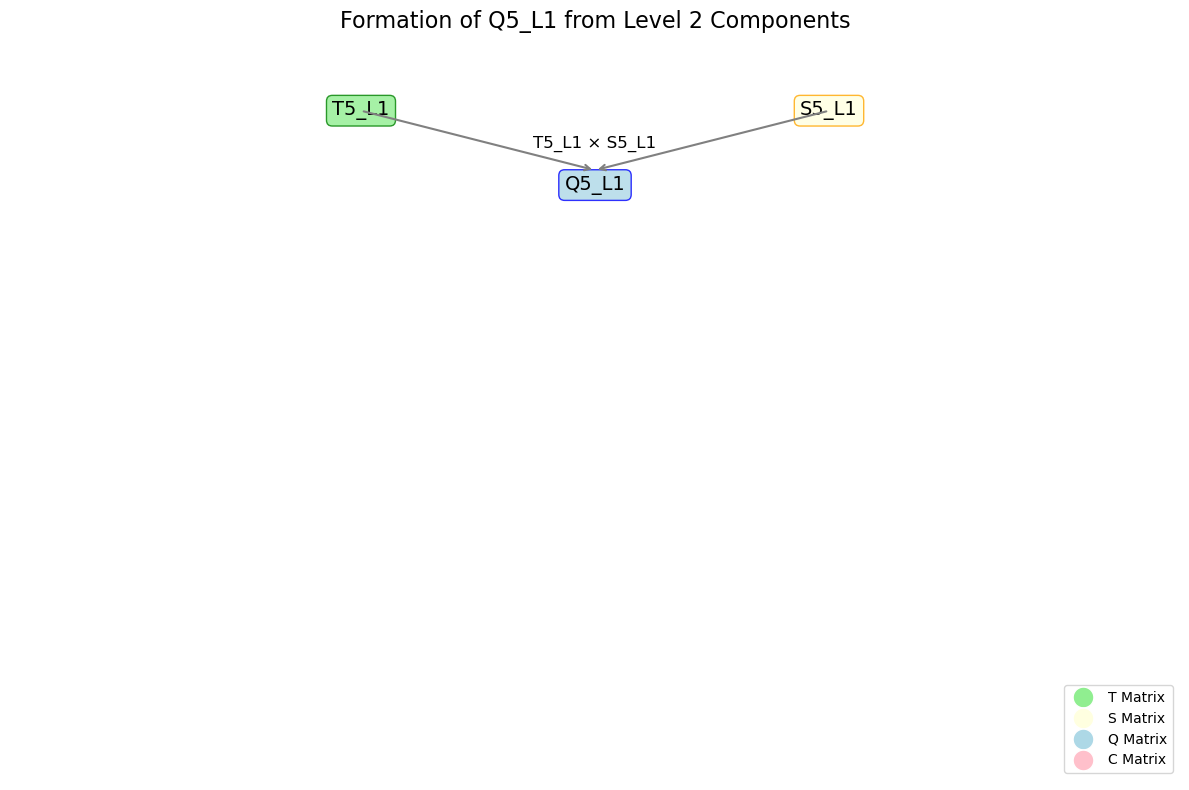

Saved strassen_output/Q6_L1_formation.png


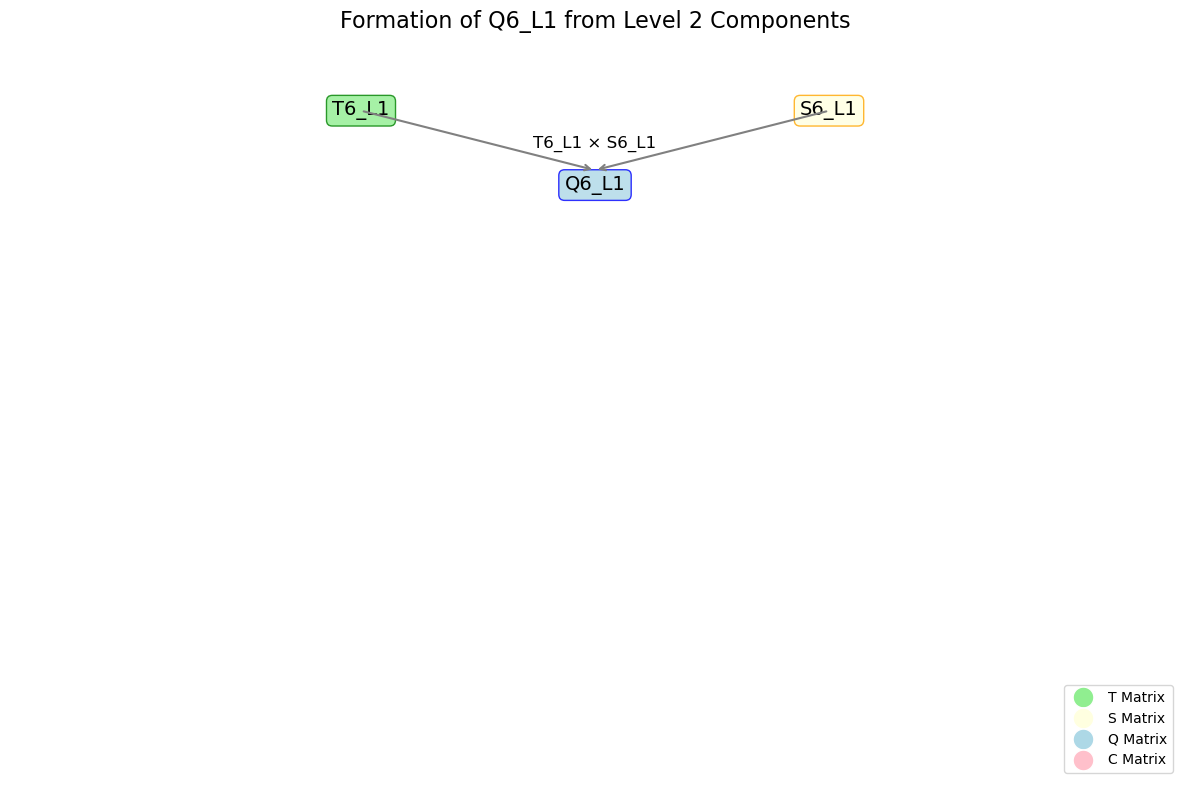

Saved strassen_output/Q7_L1_formation.png


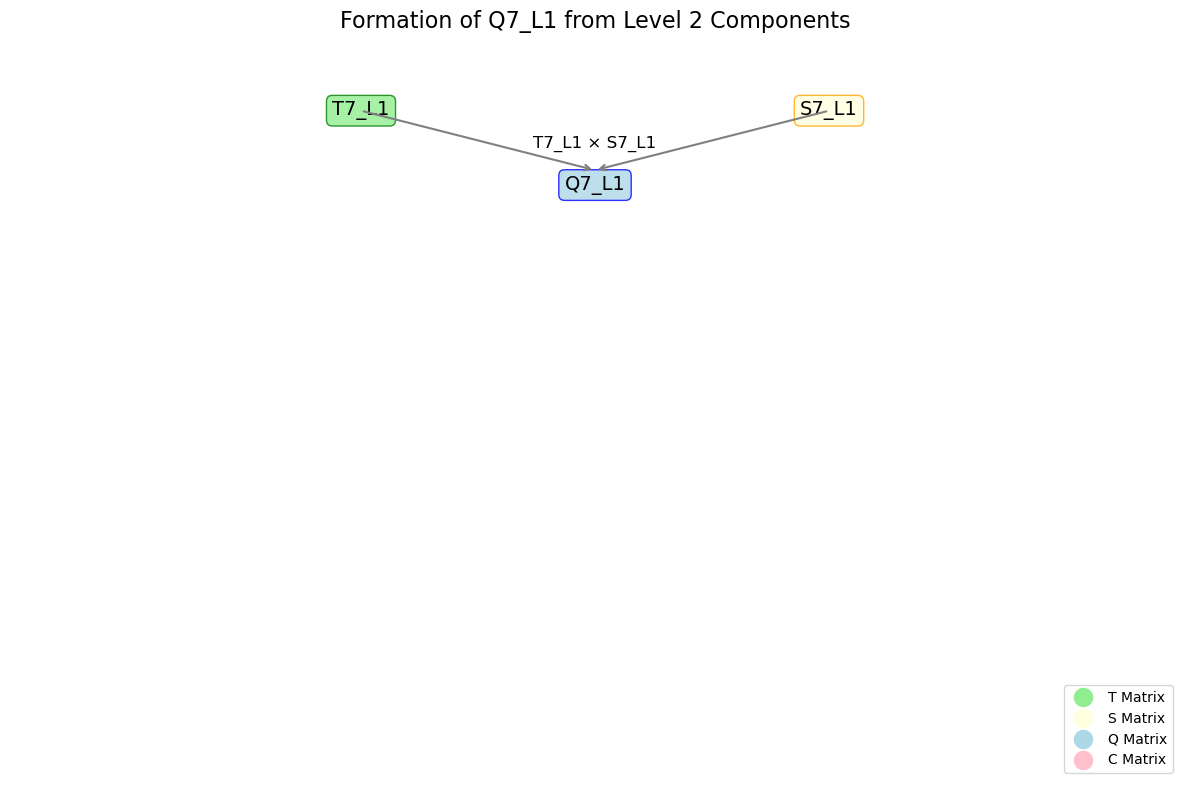


Processing Level 1 - Matrix dimension 8x8
Saved strassen_output/T_matrices_level_1.png


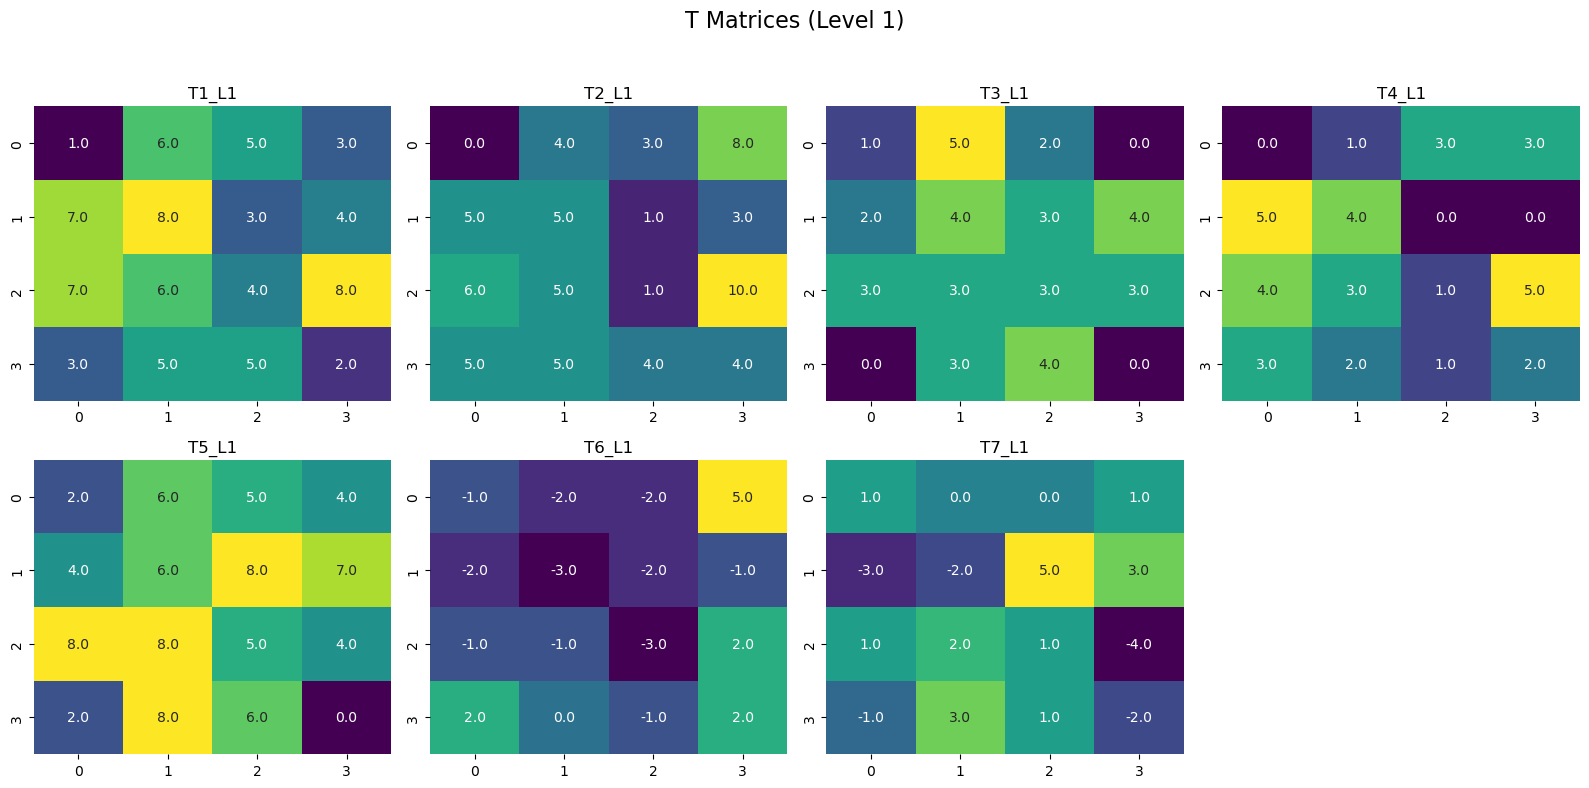

Saved strassen_output/S_matrices_level_1.png


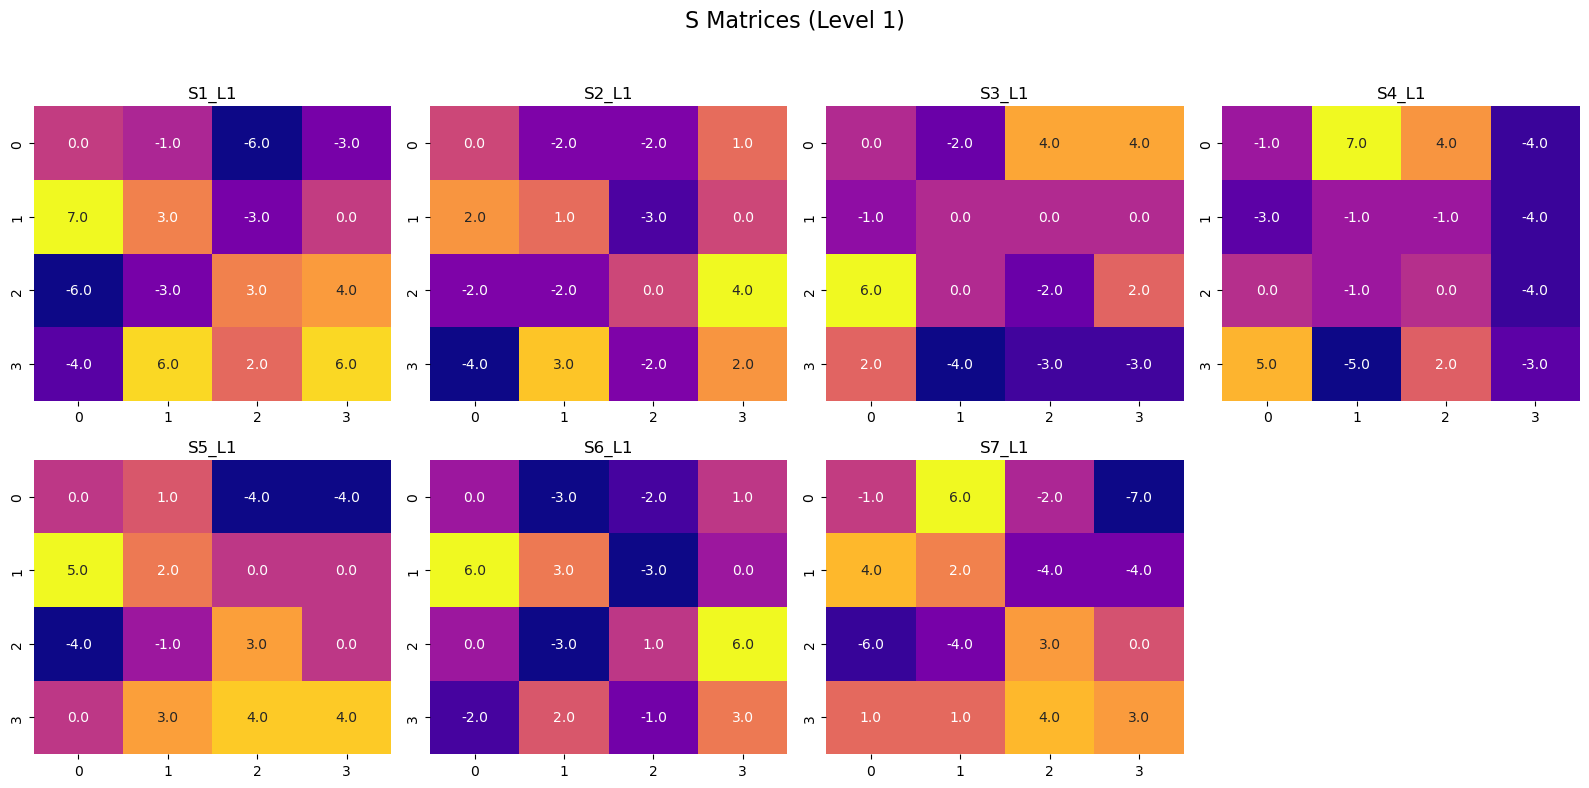

Saved strassen_output/Q_matrices_level_1.png


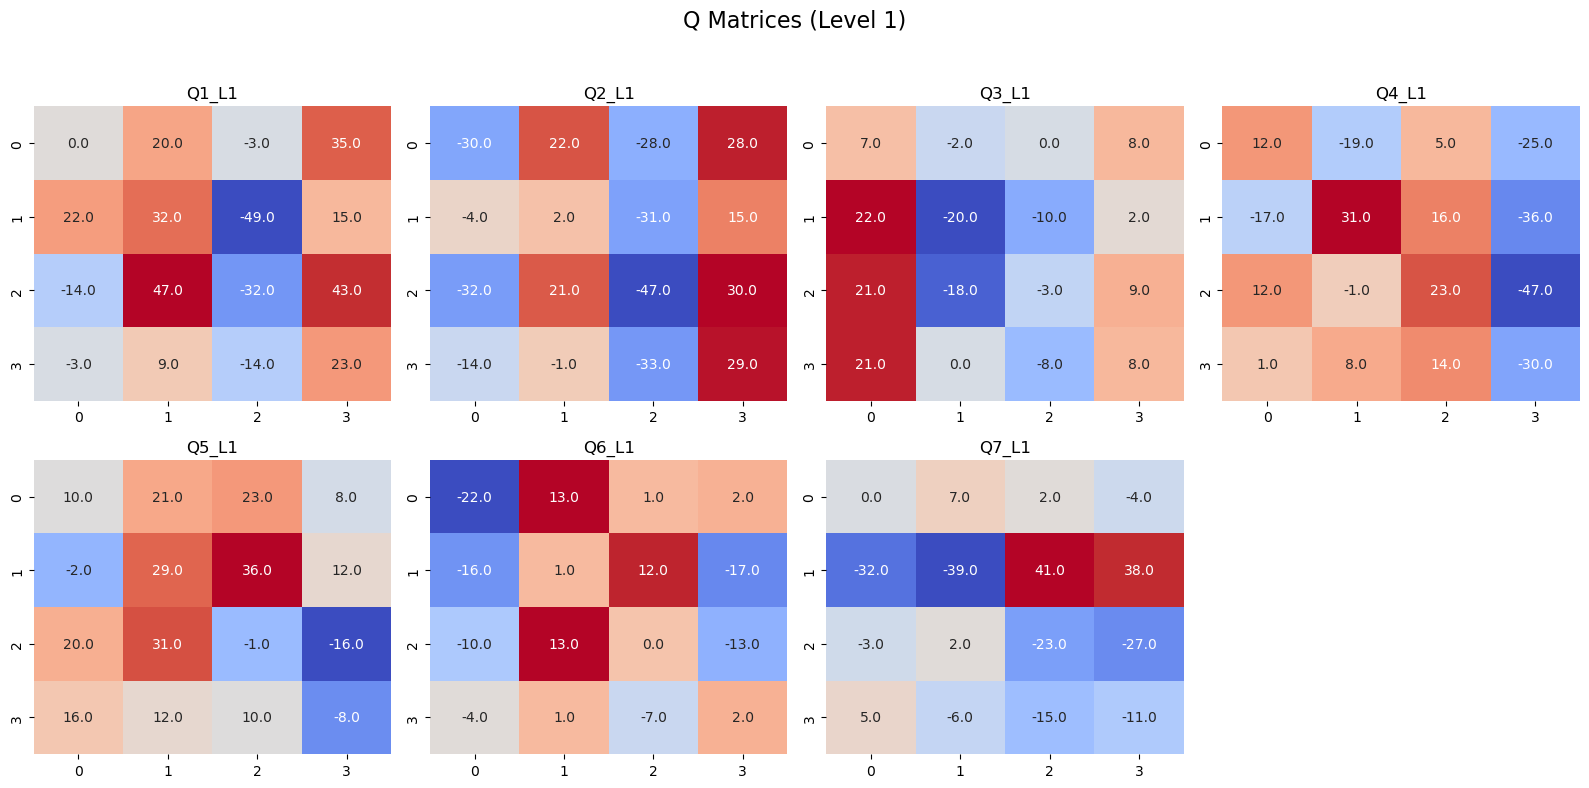

Saved strassen_output/C_matrices_level_1.png


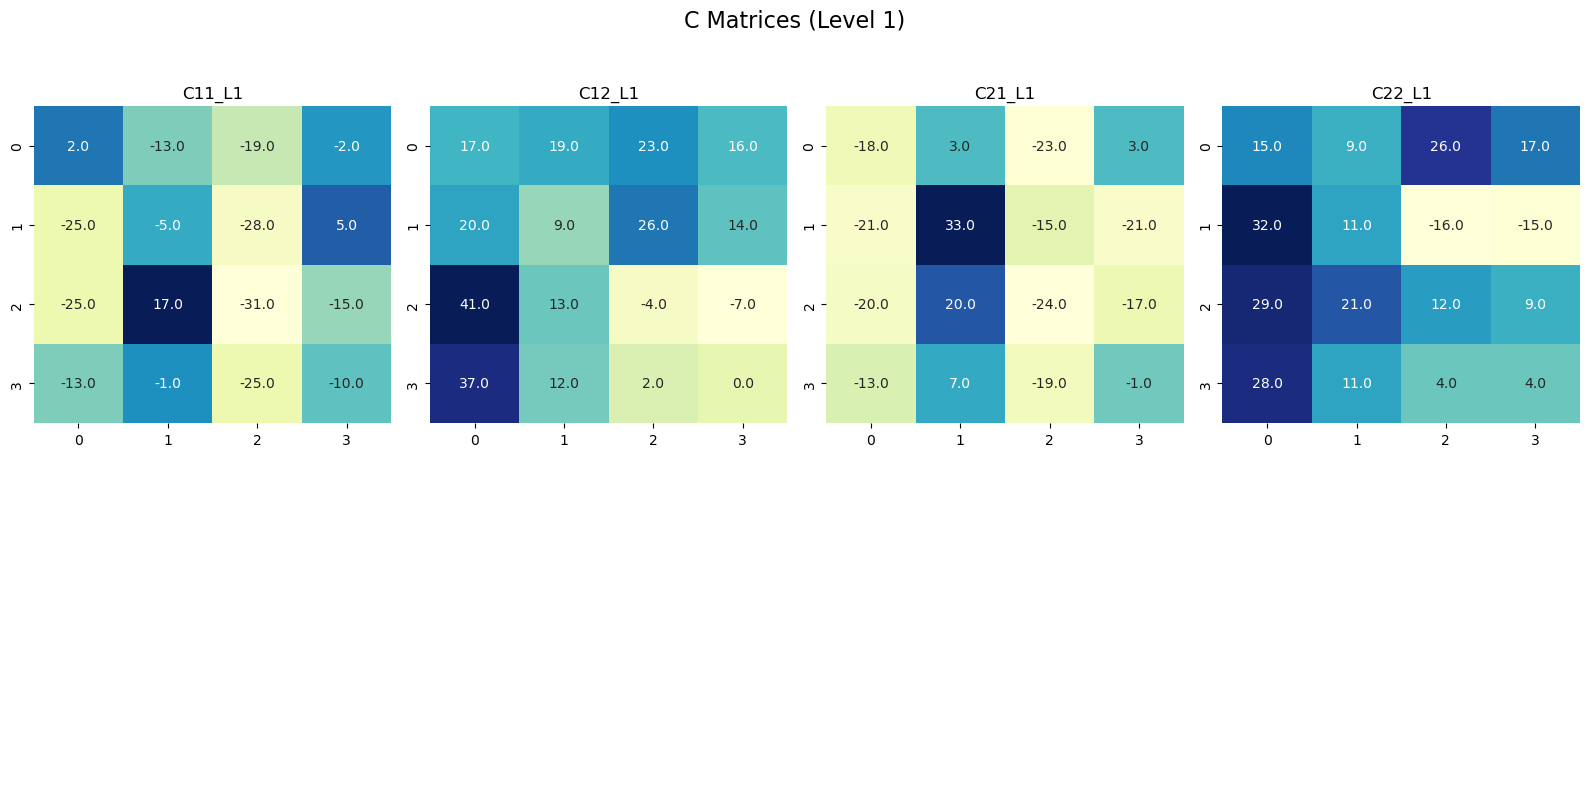

Saved strassen_output/Q1_L1_formation.png


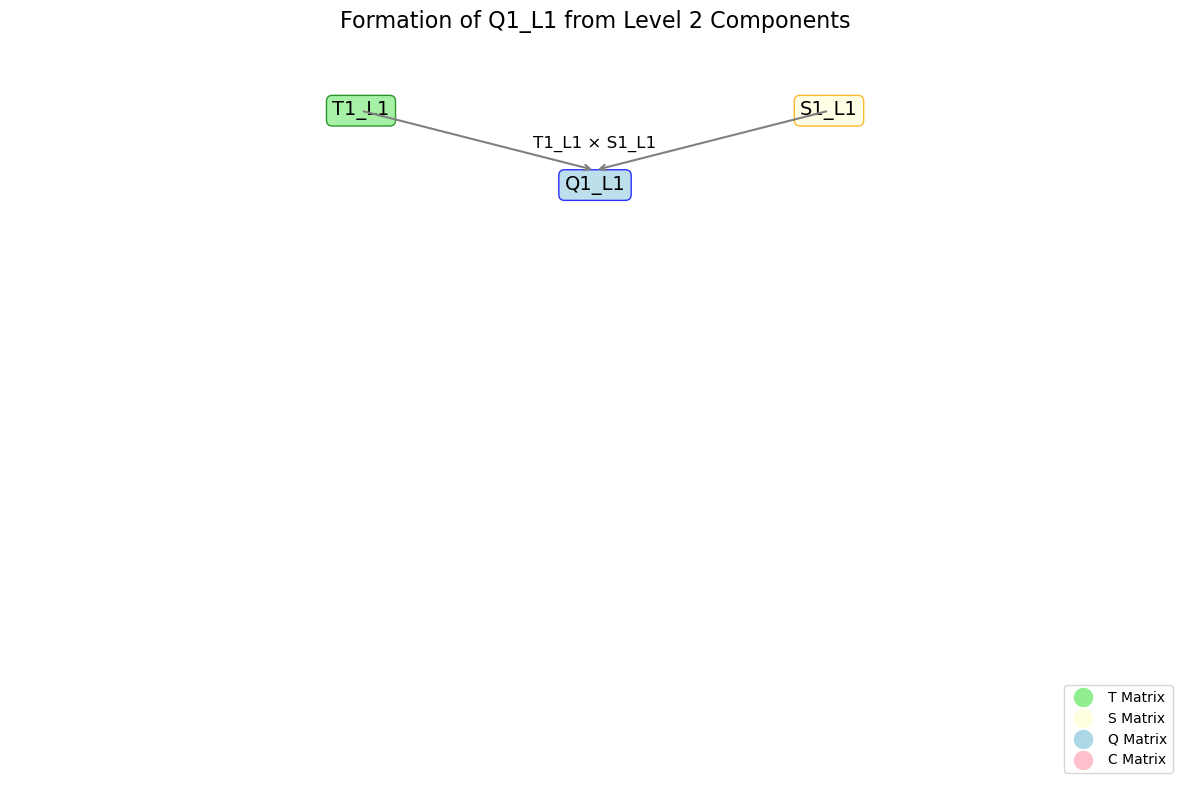

Saved strassen_output/Q2_L1_formation.png


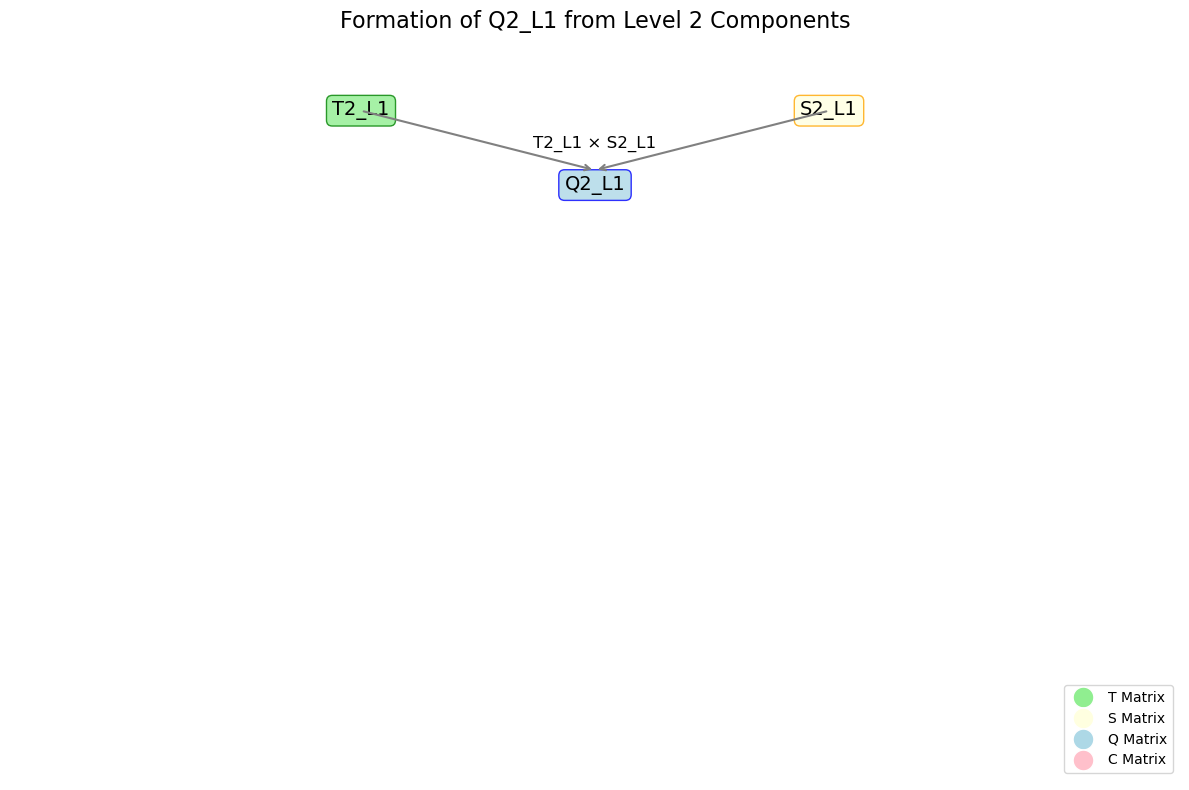

Saved strassen_output/Q3_L1_formation.png


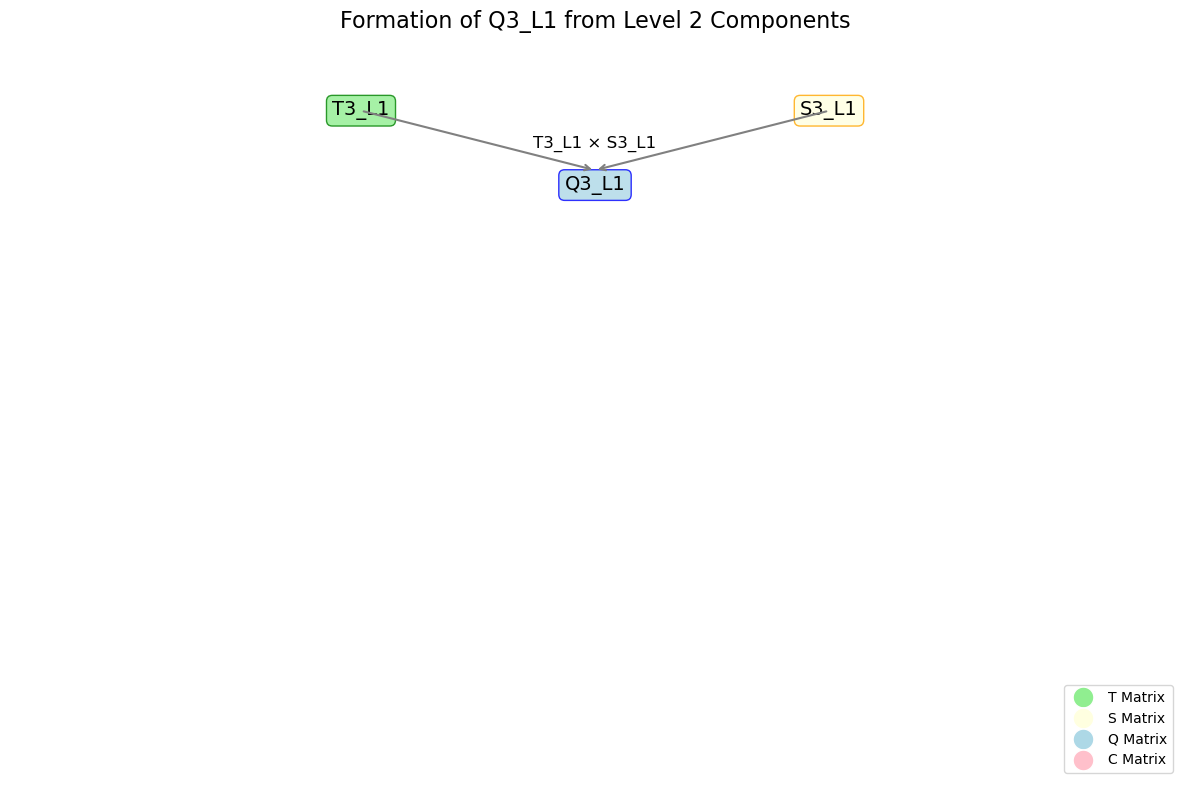

Saved strassen_output/Q4_L1_formation.png


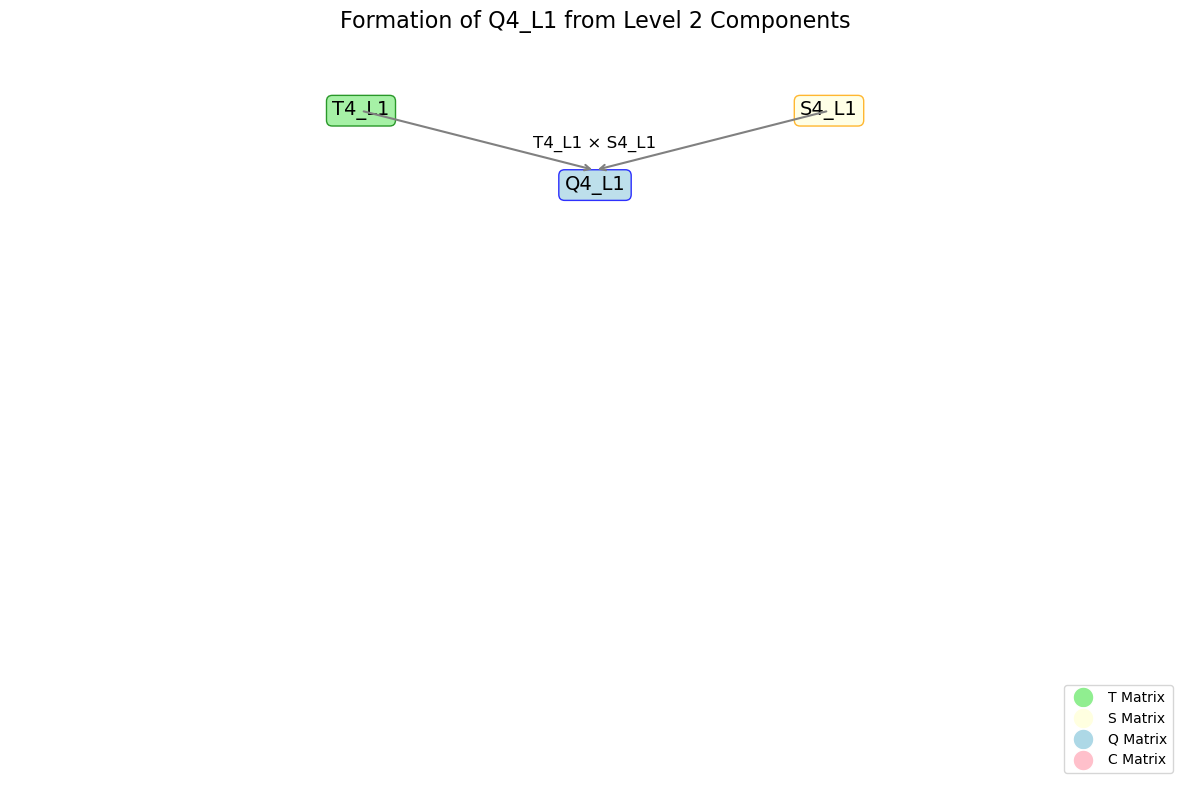

Saved strassen_output/Q5_L1_formation.png


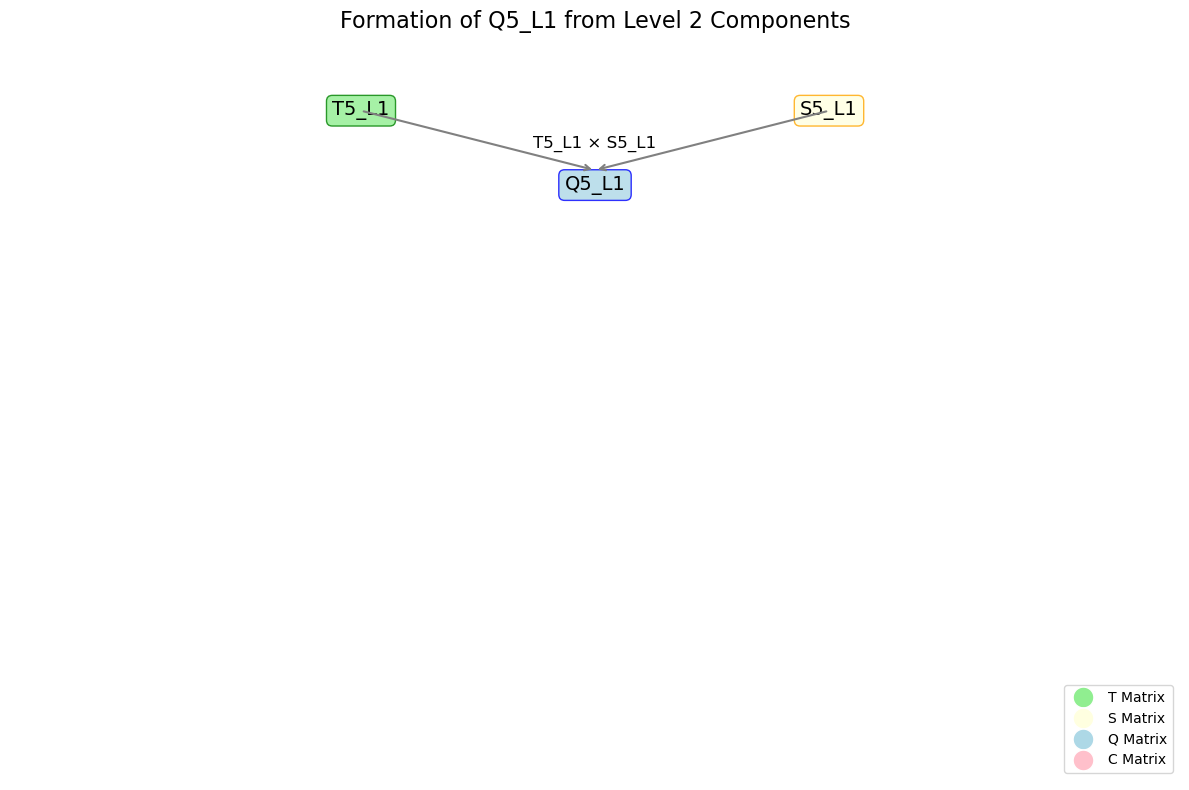

Saved strassen_output/Q6_L1_formation.png


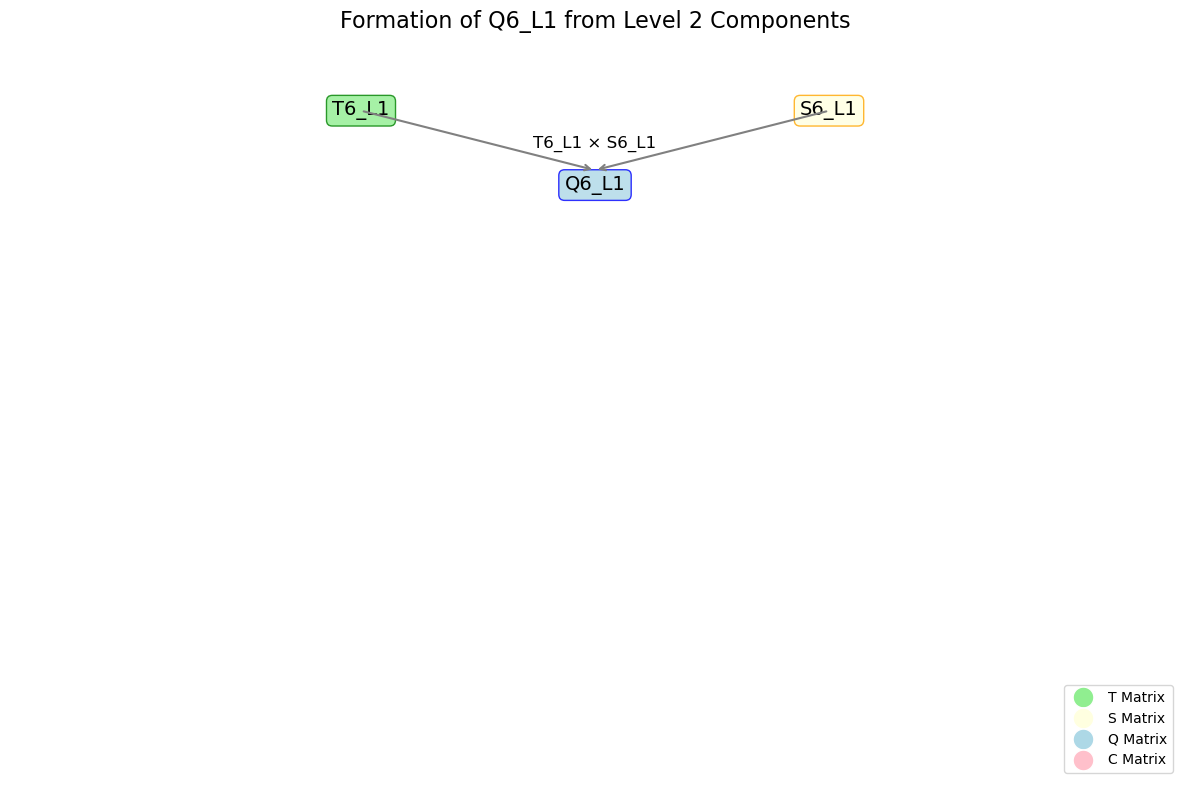

Saved strassen_output/Q7_L1_formation.png


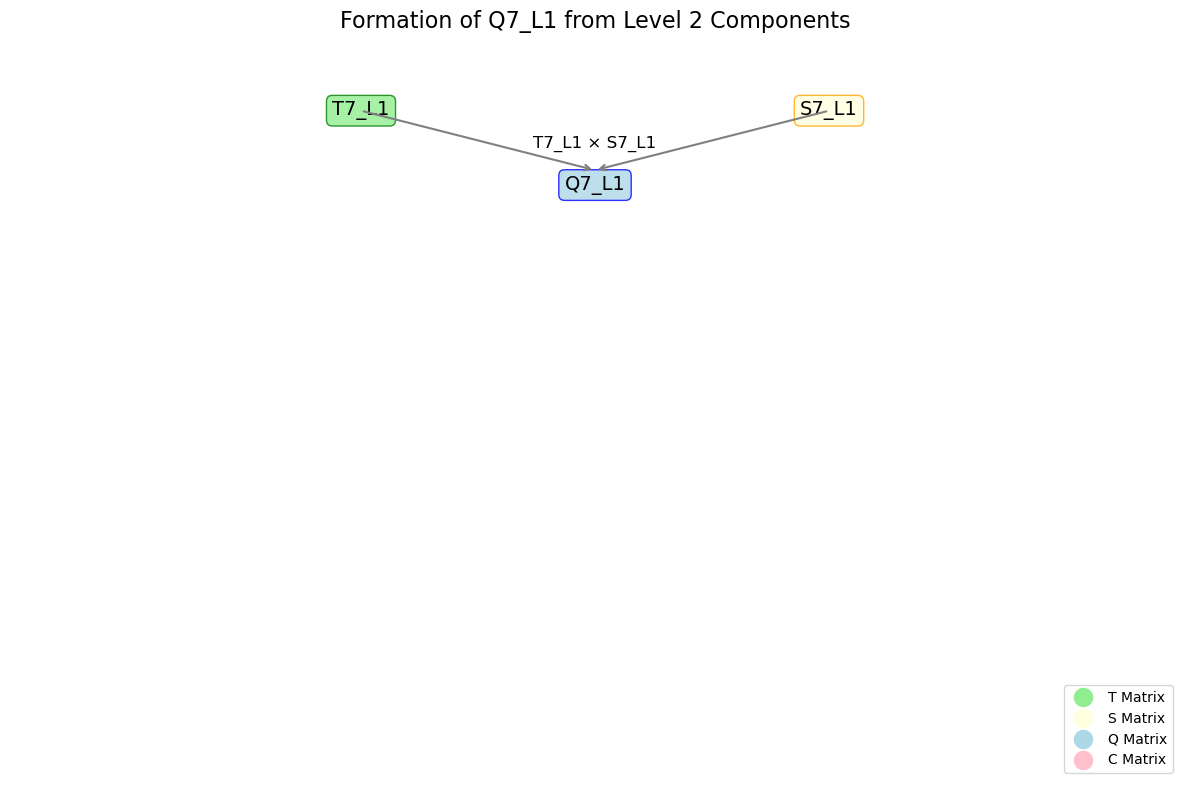


Processing Level 1 - Matrix dimension 8x8
Saved strassen_output/T_matrices_level_1.png


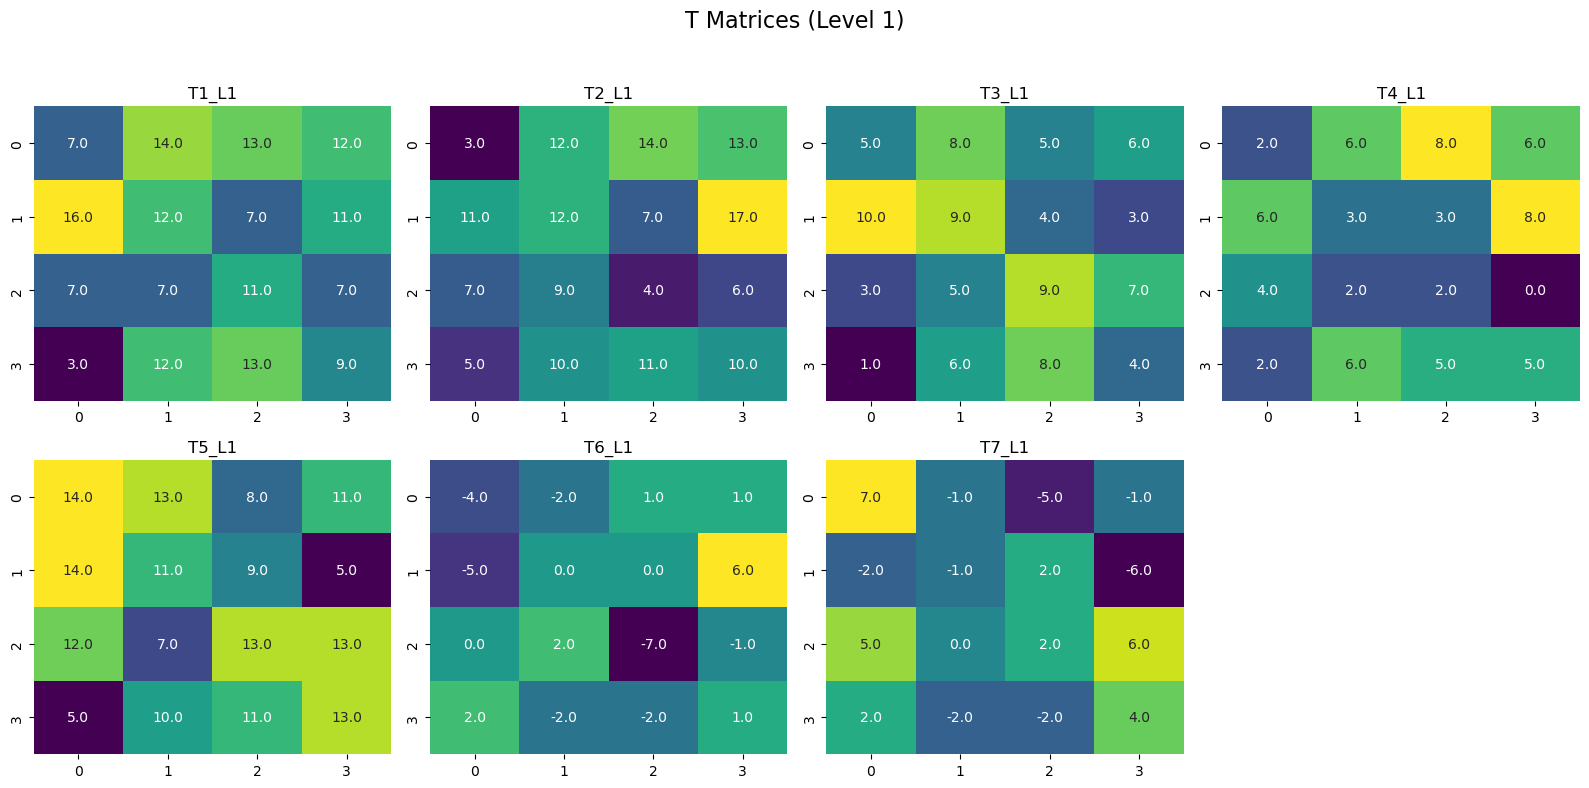

Saved strassen_output/S_matrices_level_1.png


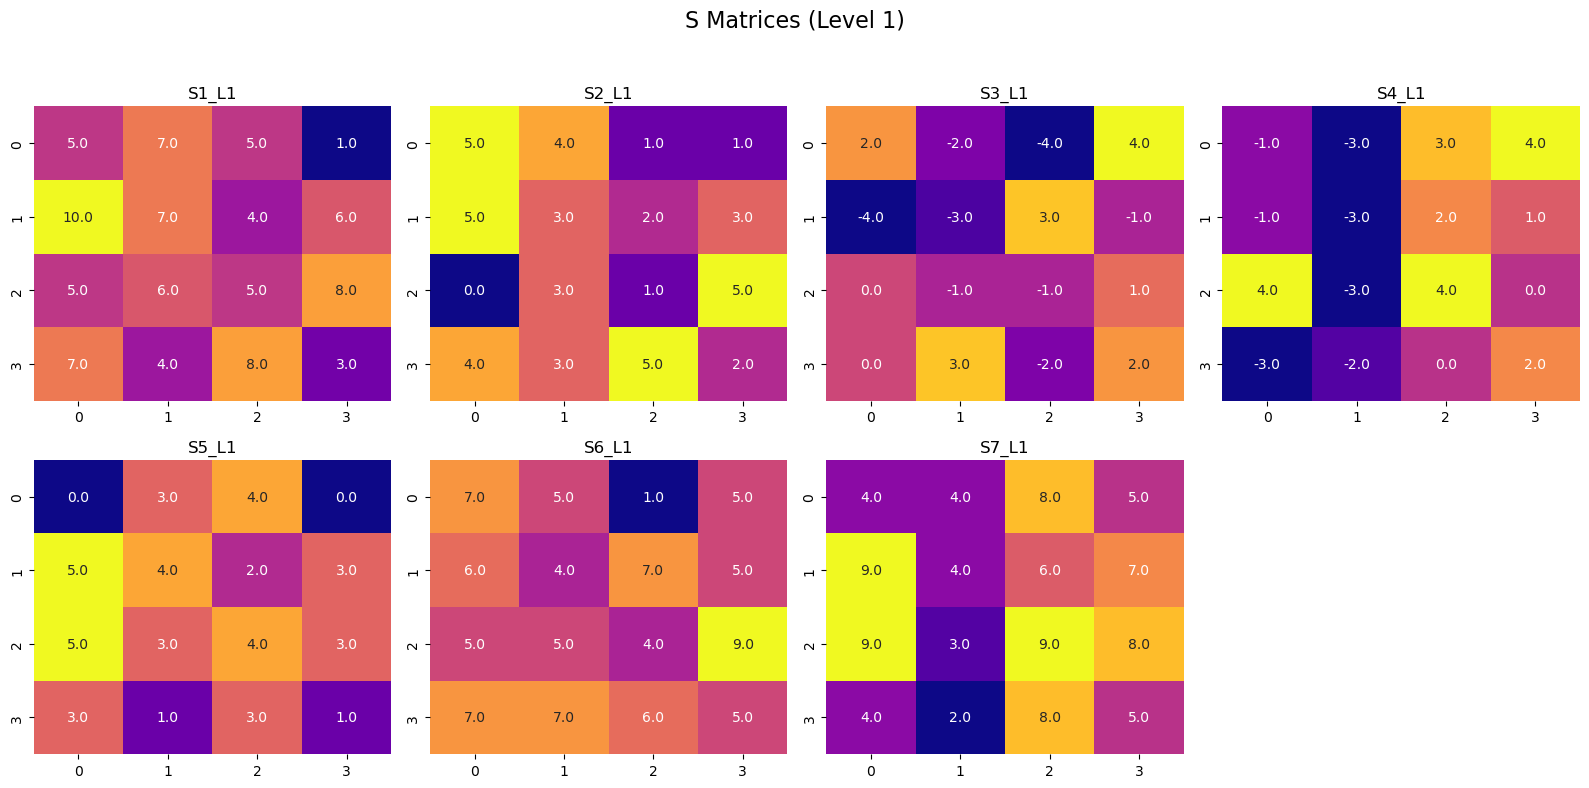

Saved strassen_output/Q_matrices_level_1.png


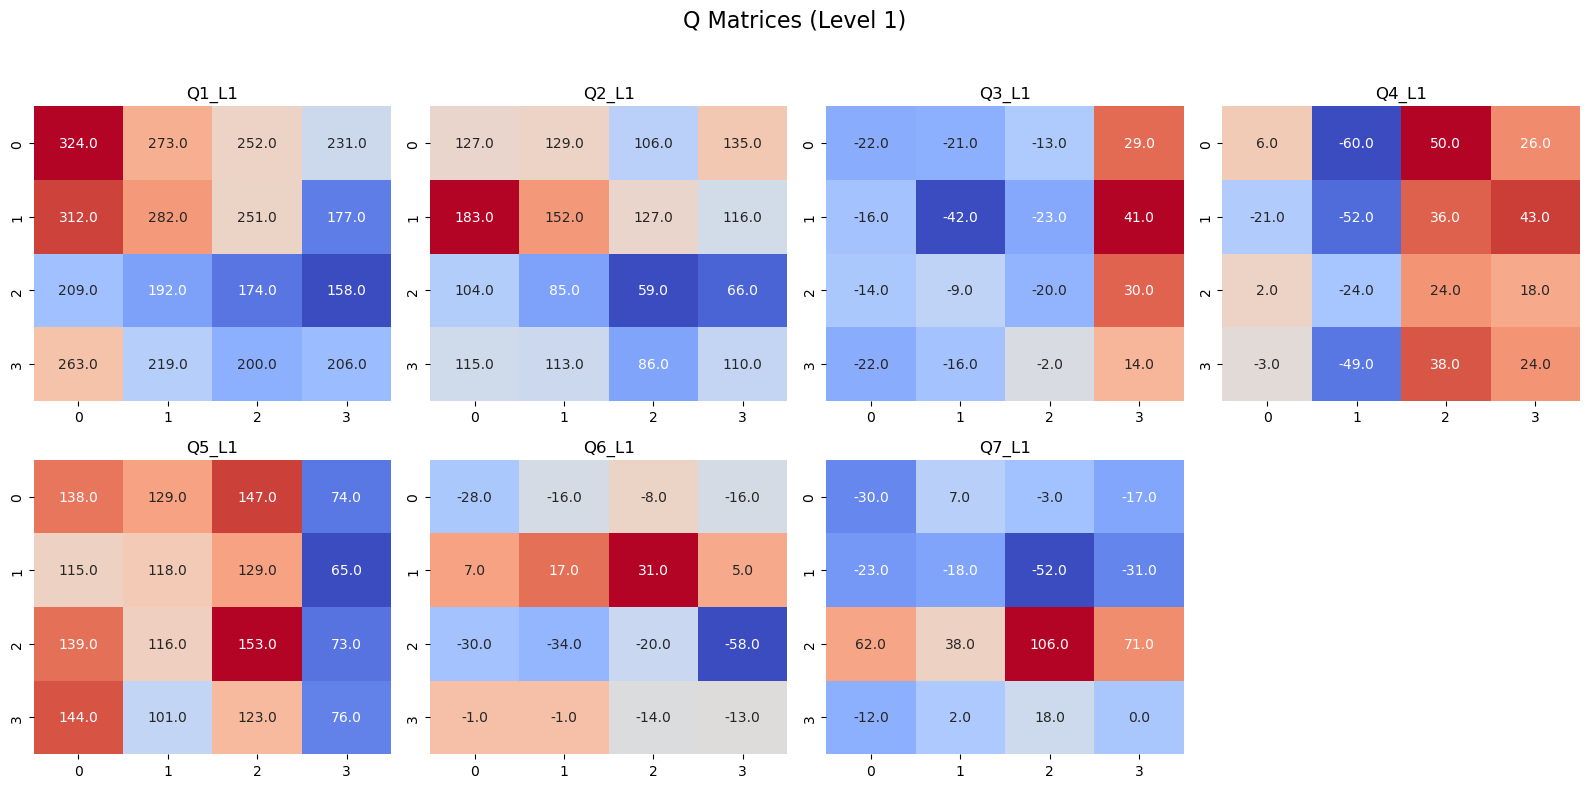

Saved strassen_output/C_matrices_level_1.png


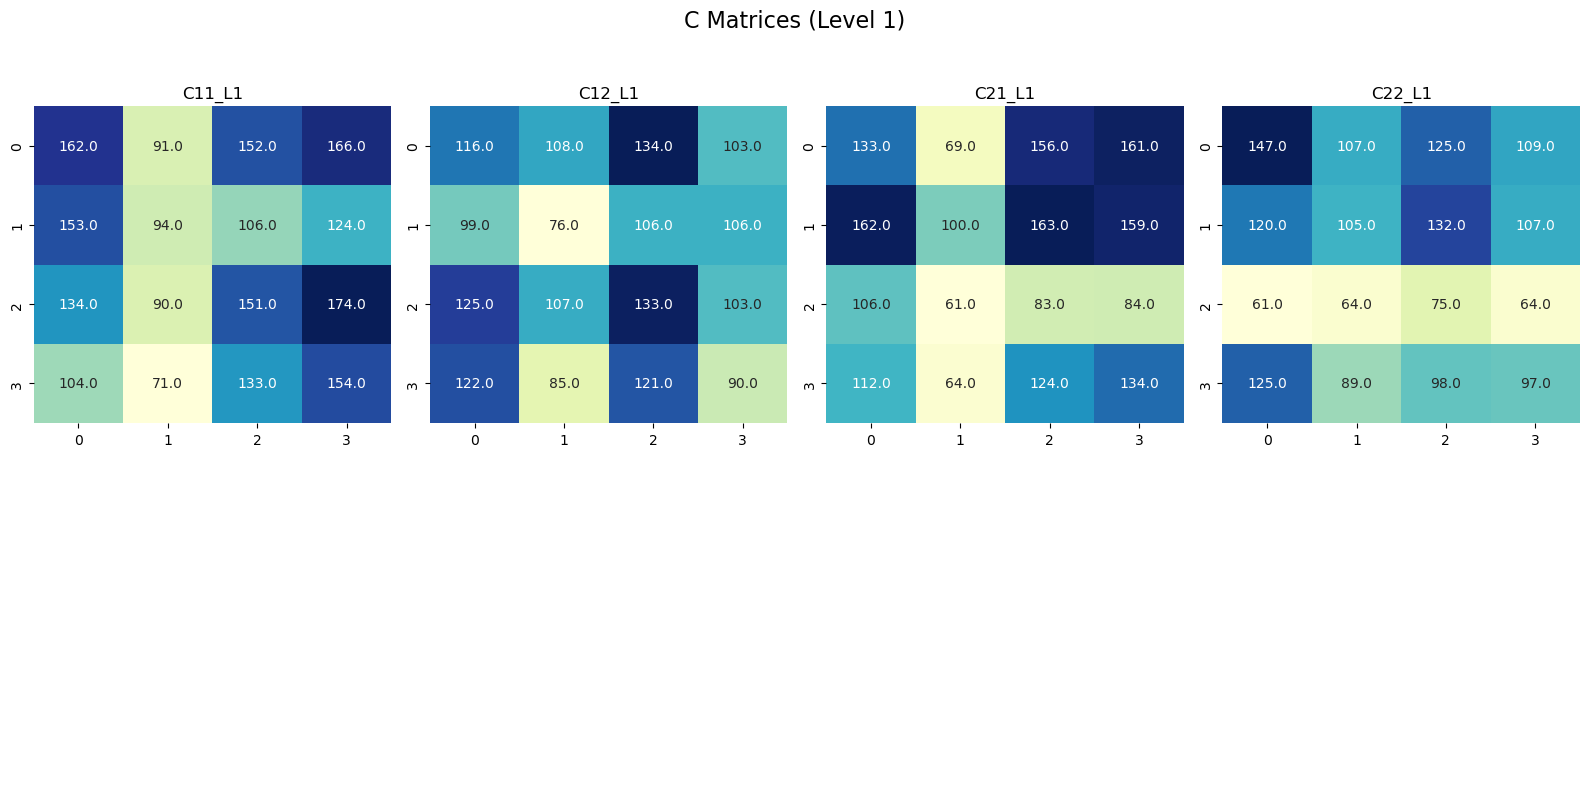

Saved strassen_output/Q1_L1_formation.png


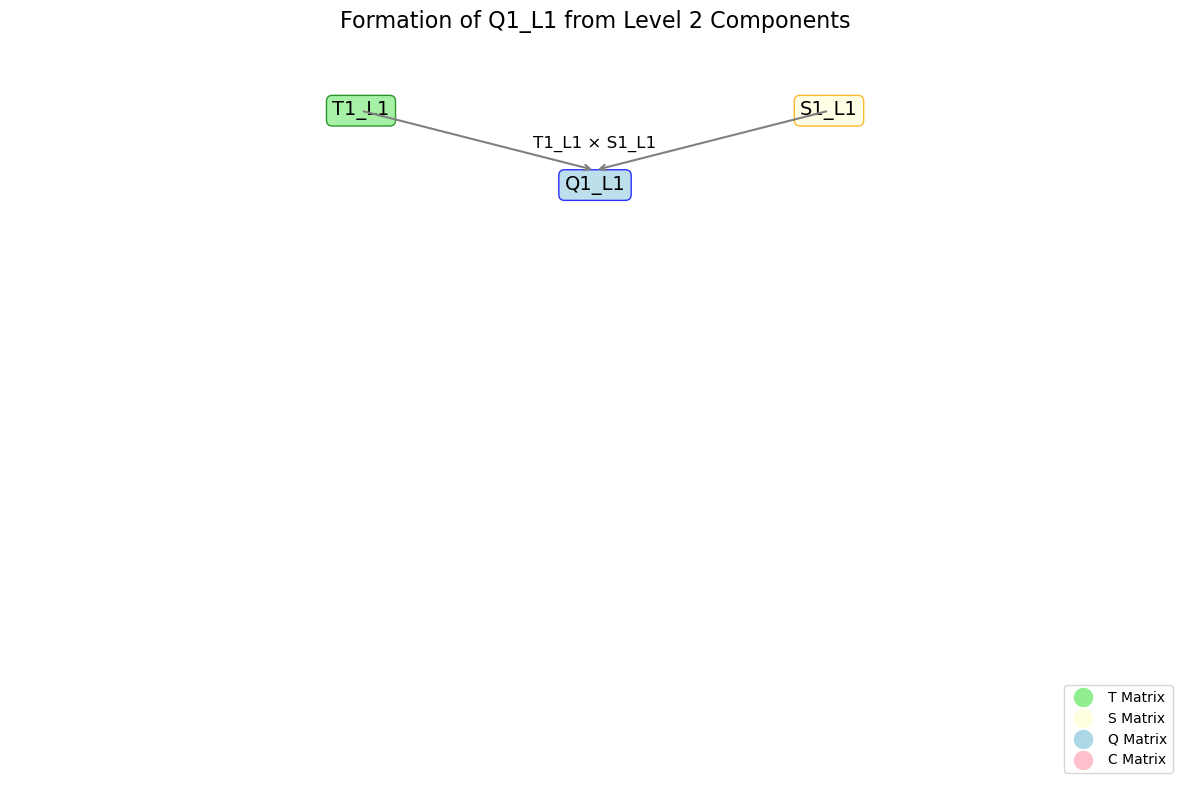

Saved strassen_output/Q2_L1_formation.png


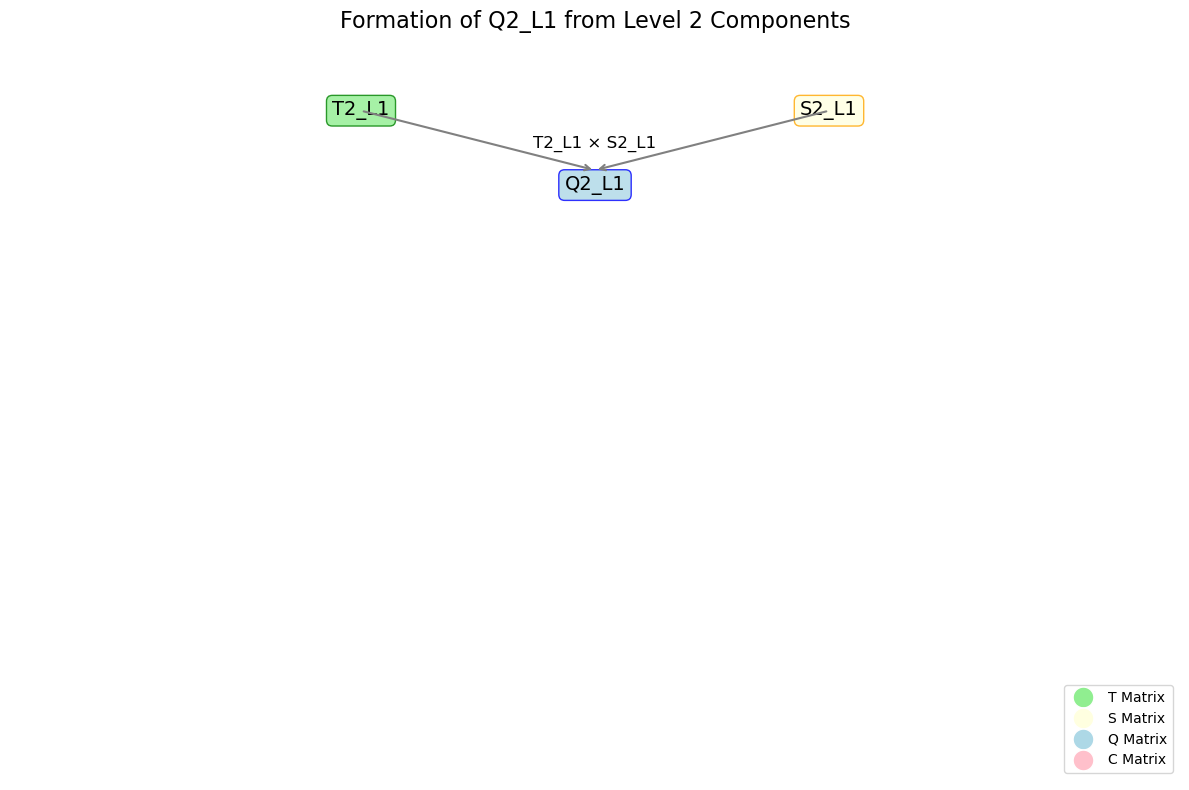

Saved strassen_output/Q3_L1_formation.png


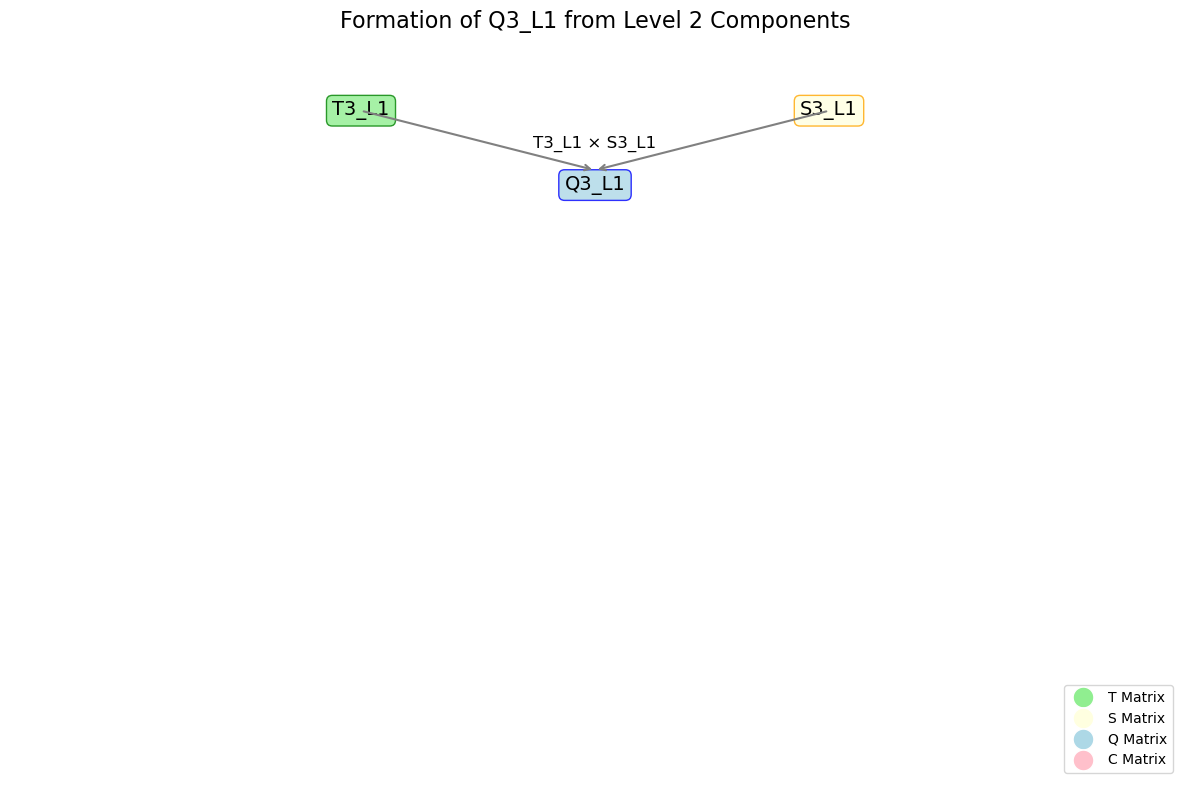

Saved strassen_output/Q4_L1_formation.png


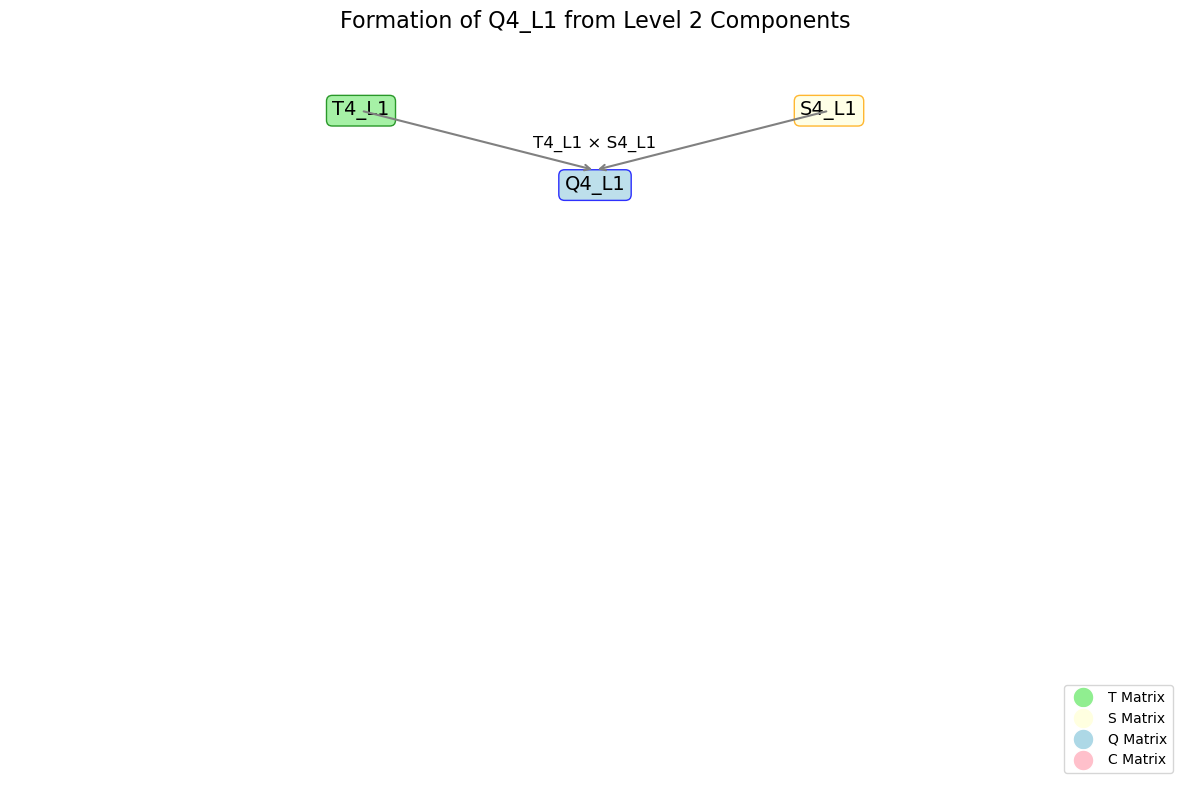

Saved strassen_output/Q5_L1_formation.png


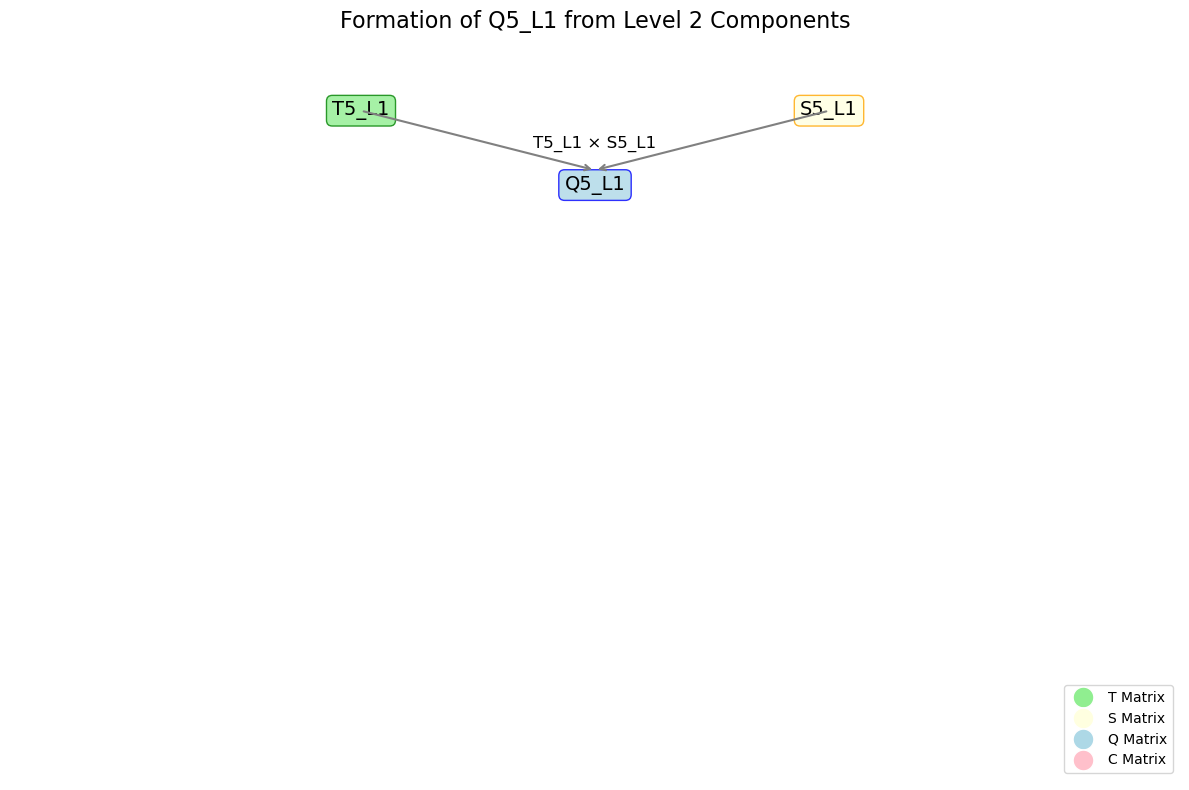

Saved strassen_output/Q6_L1_formation.png


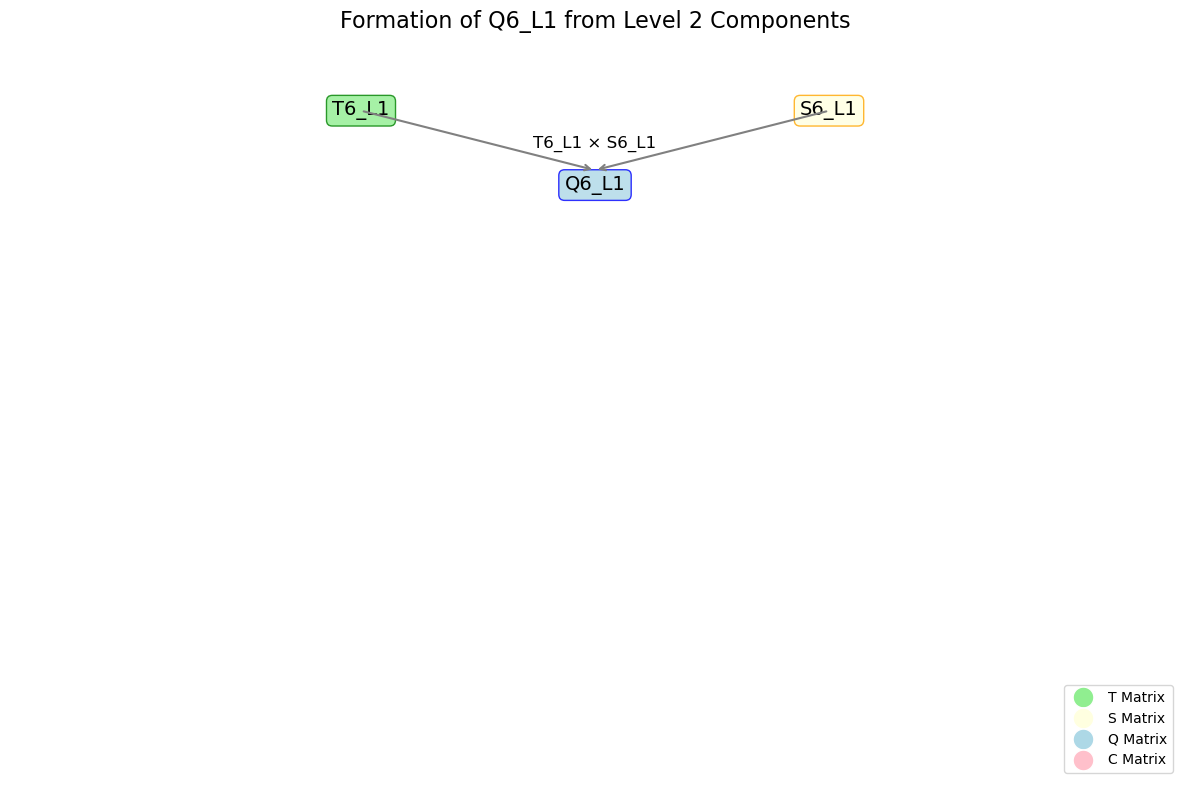

Saved strassen_output/Q7_L1_formation.png


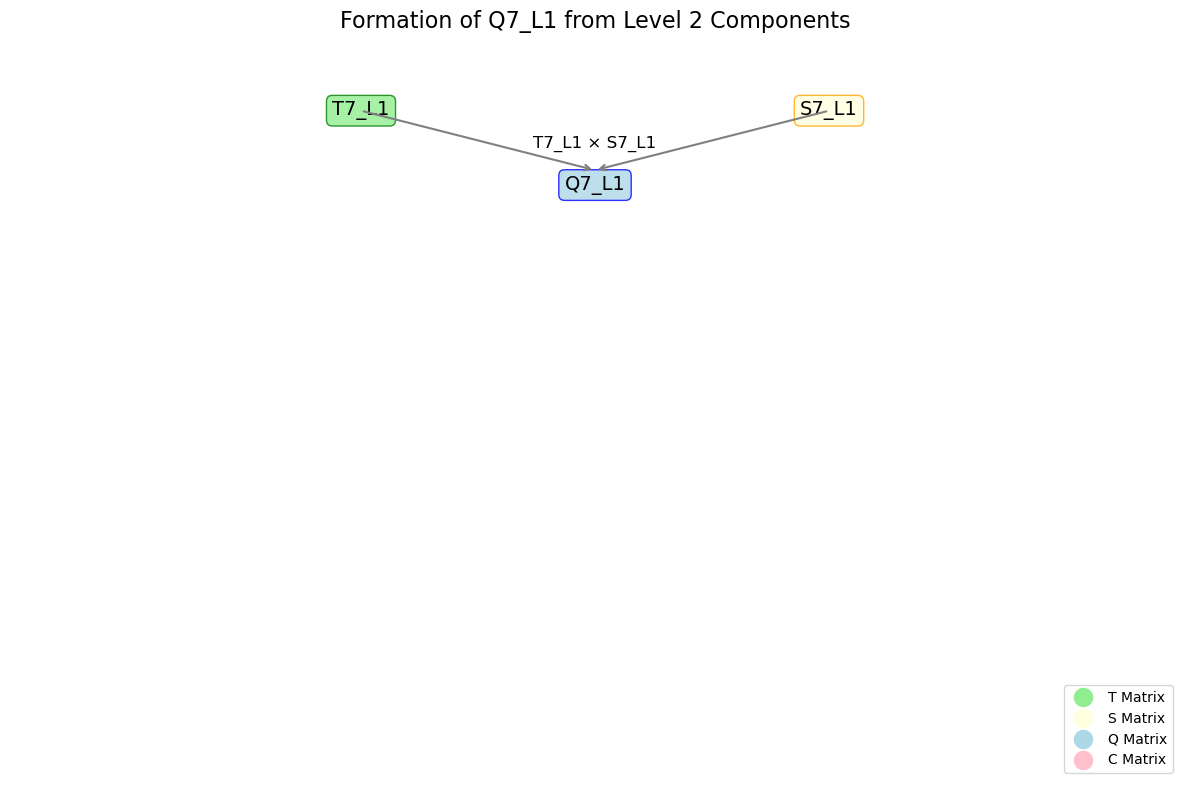


Processing Level 1 - Matrix dimension 8x8
Saved strassen_output/T_matrices_level_1.png


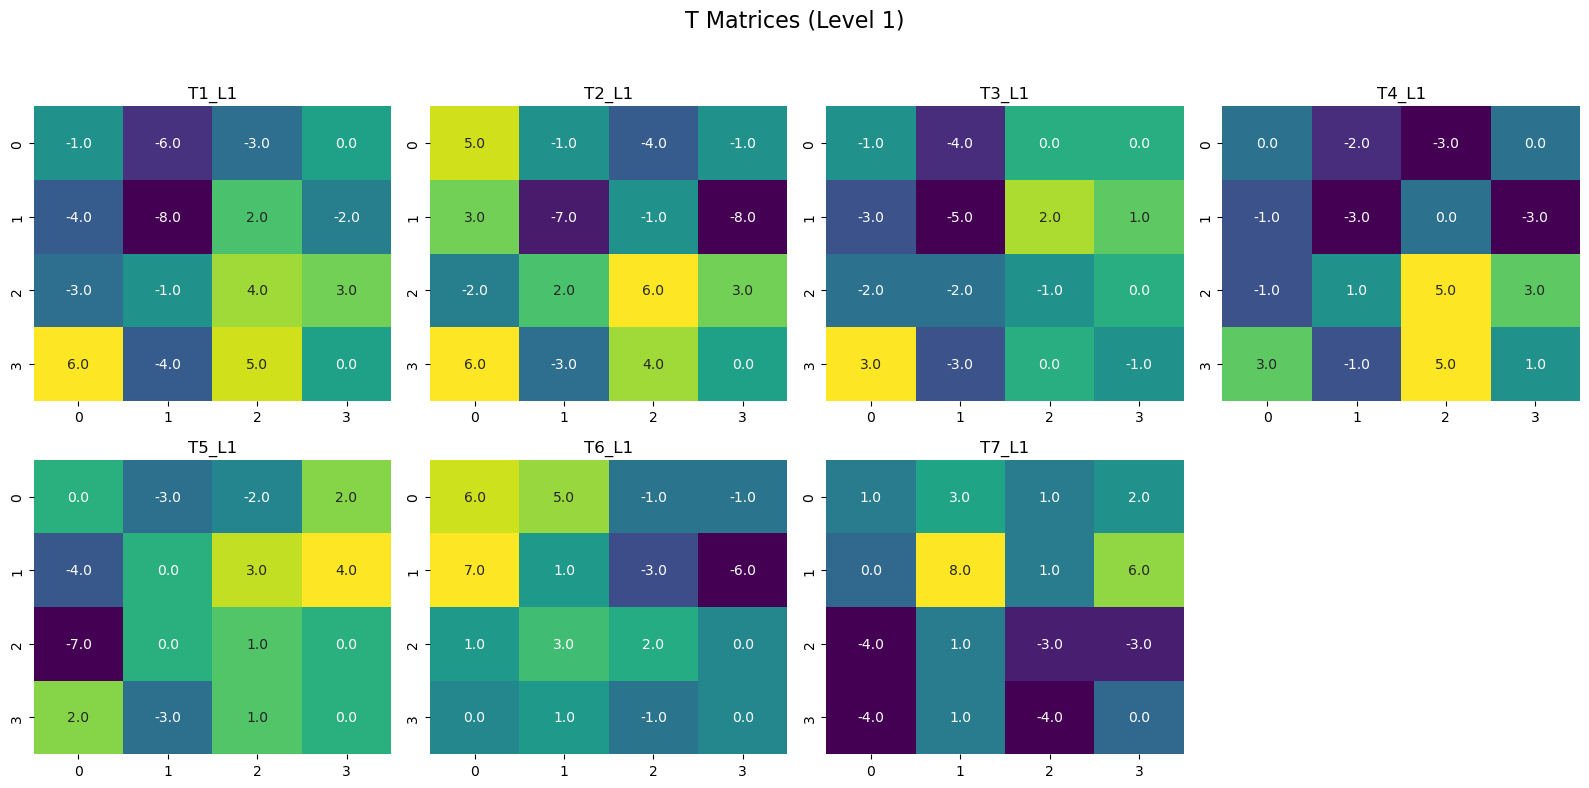

Saved strassen_output/S_matrices_level_1.png


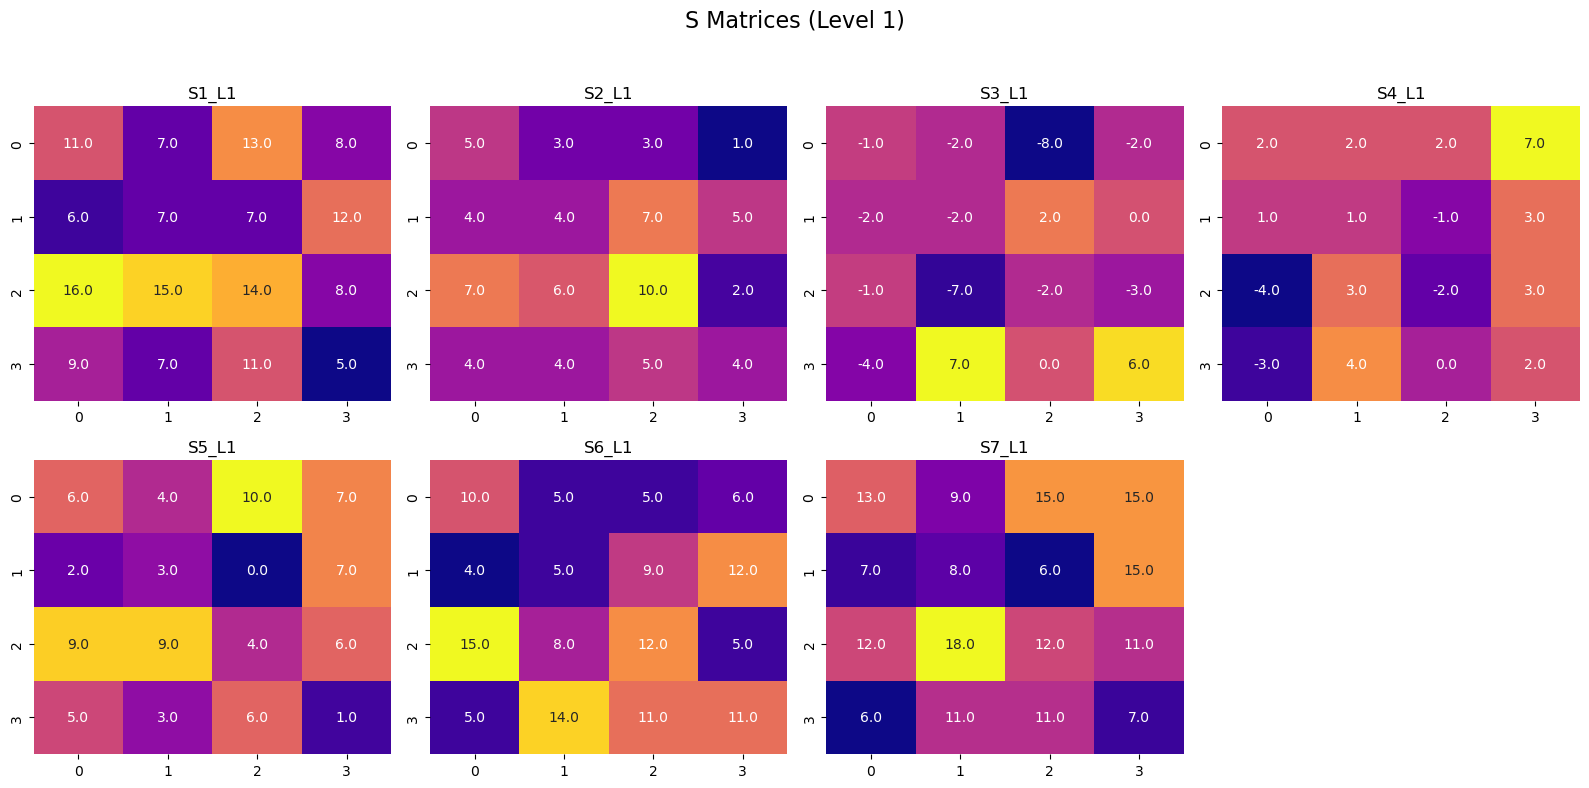

Saved strassen_output/Q_matrices_level_1.png


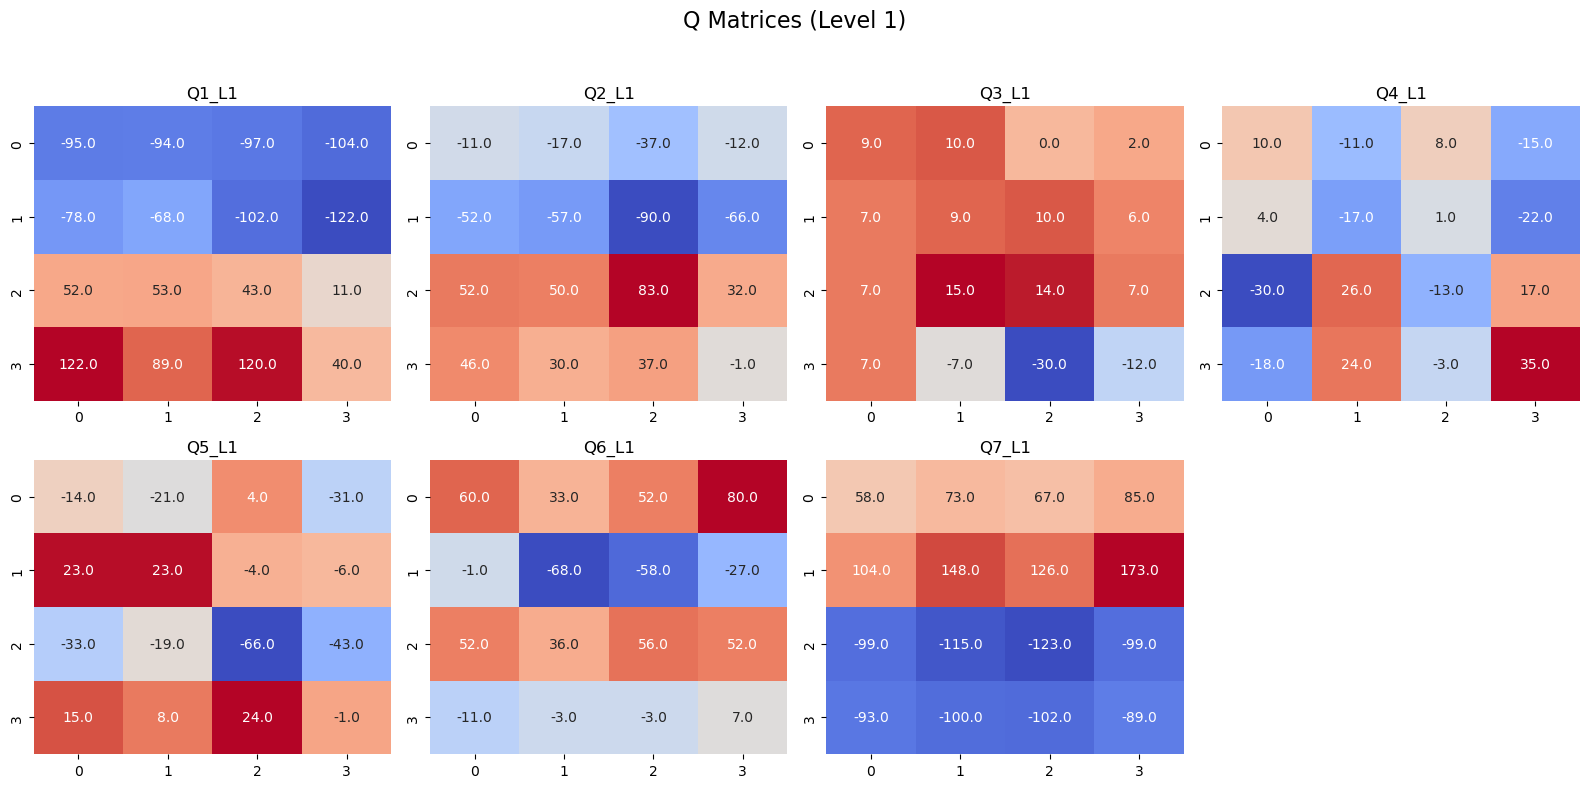

Saved strassen_output/C_matrices_level_1.png


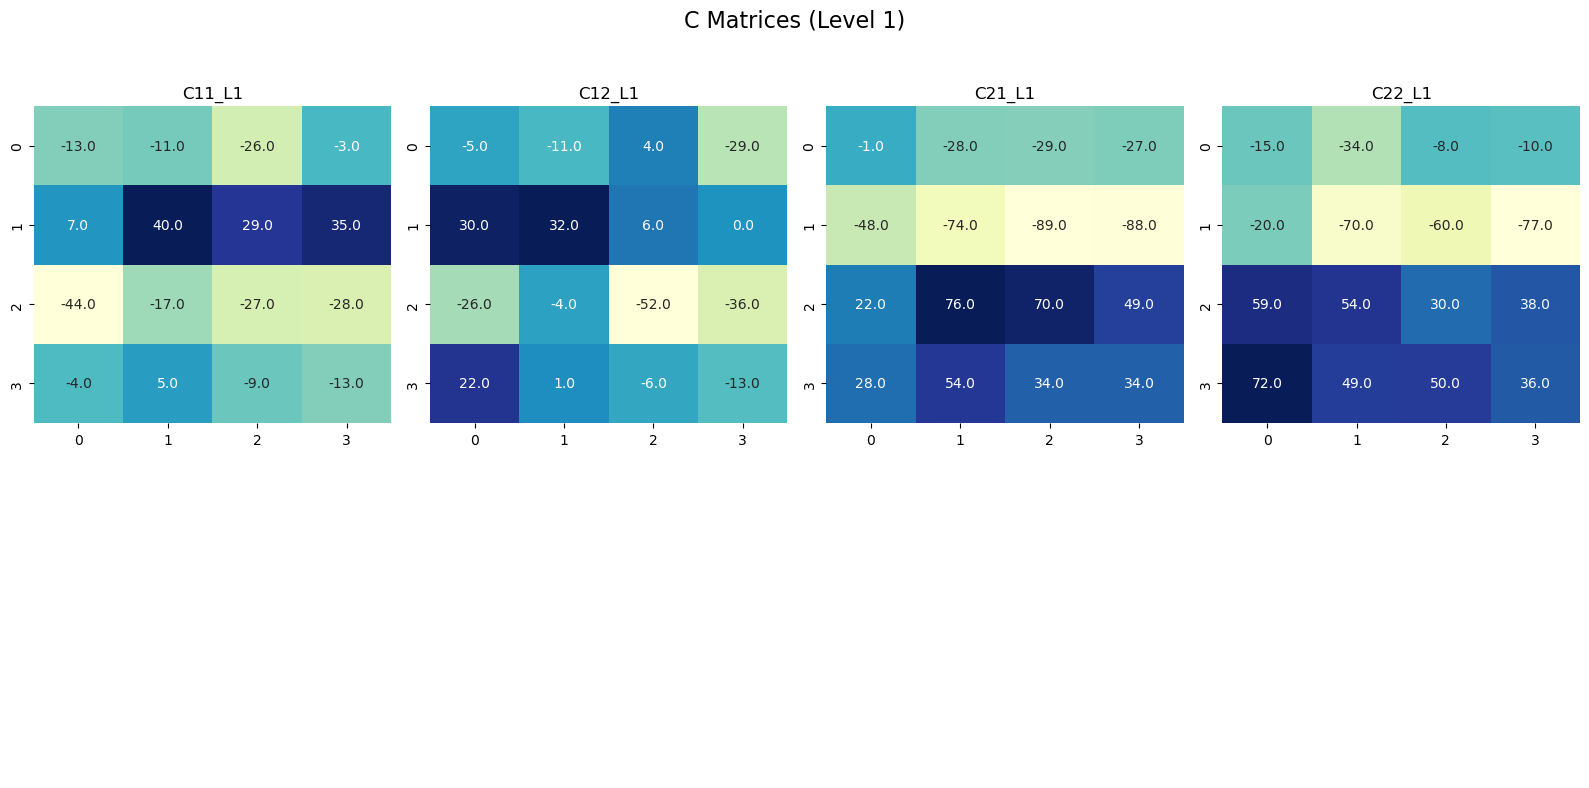

Saved strassen_output/Q1_L1_formation.png


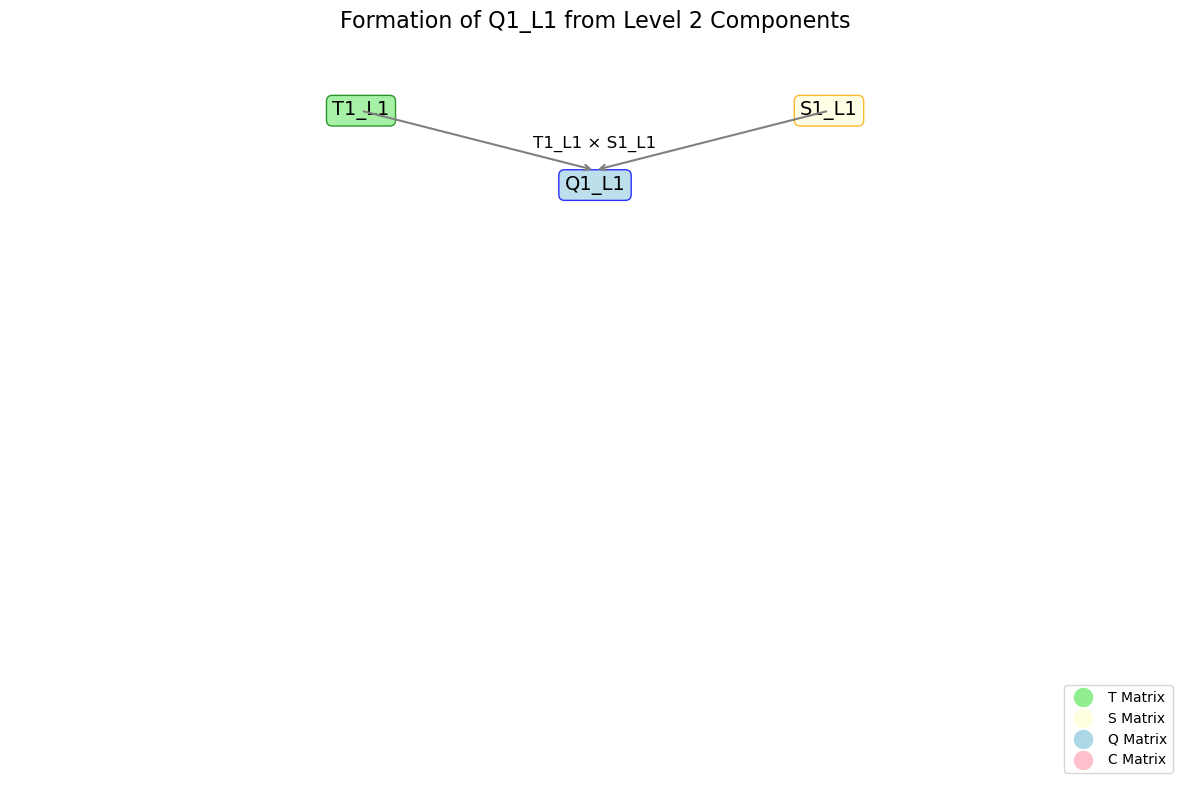

Saved strassen_output/Q2_L1_formation.png


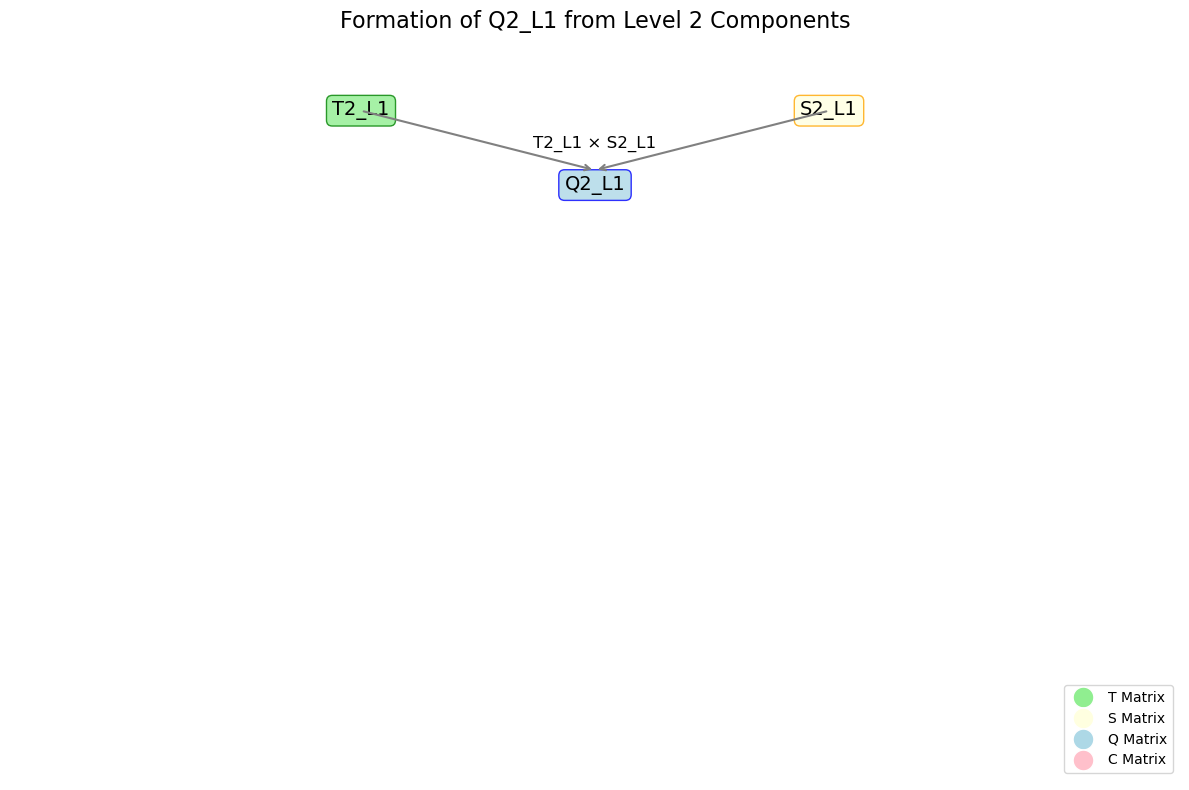

Saved strassen_output/Q3_L1_formation.png


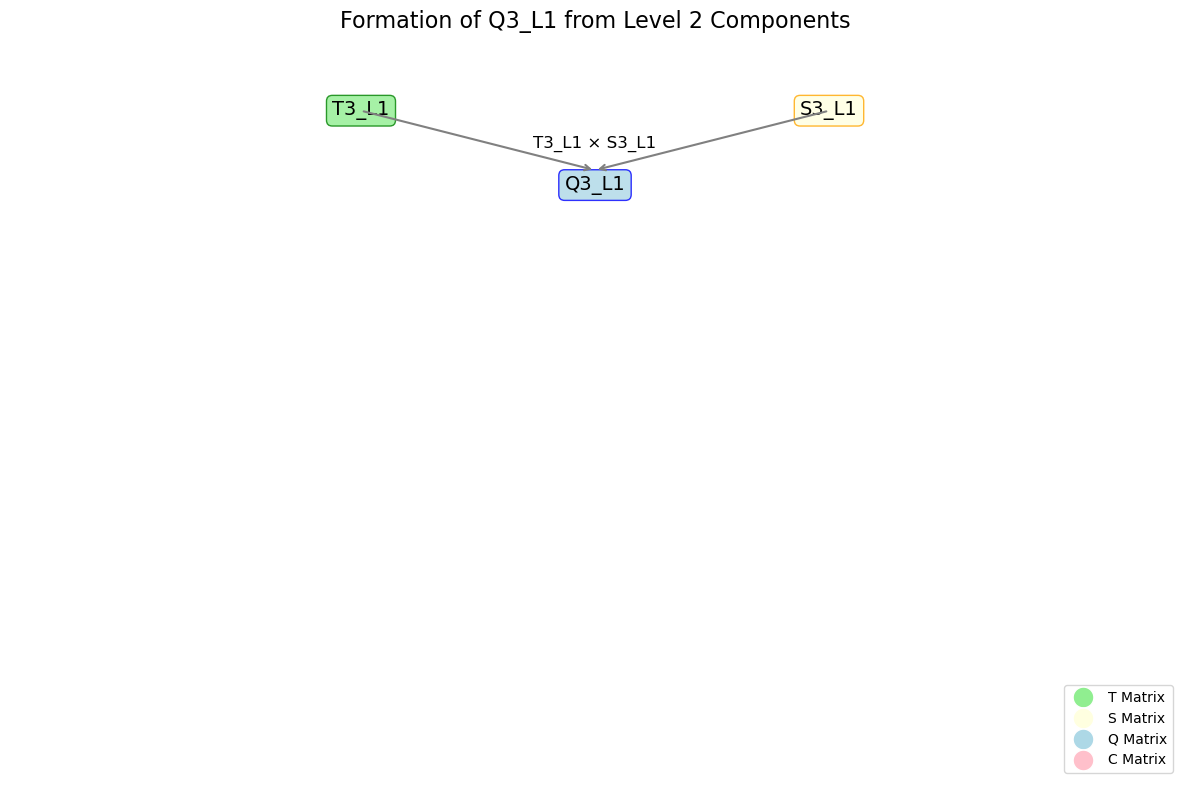

Saved strassen_output/Q4_L1_formation.png


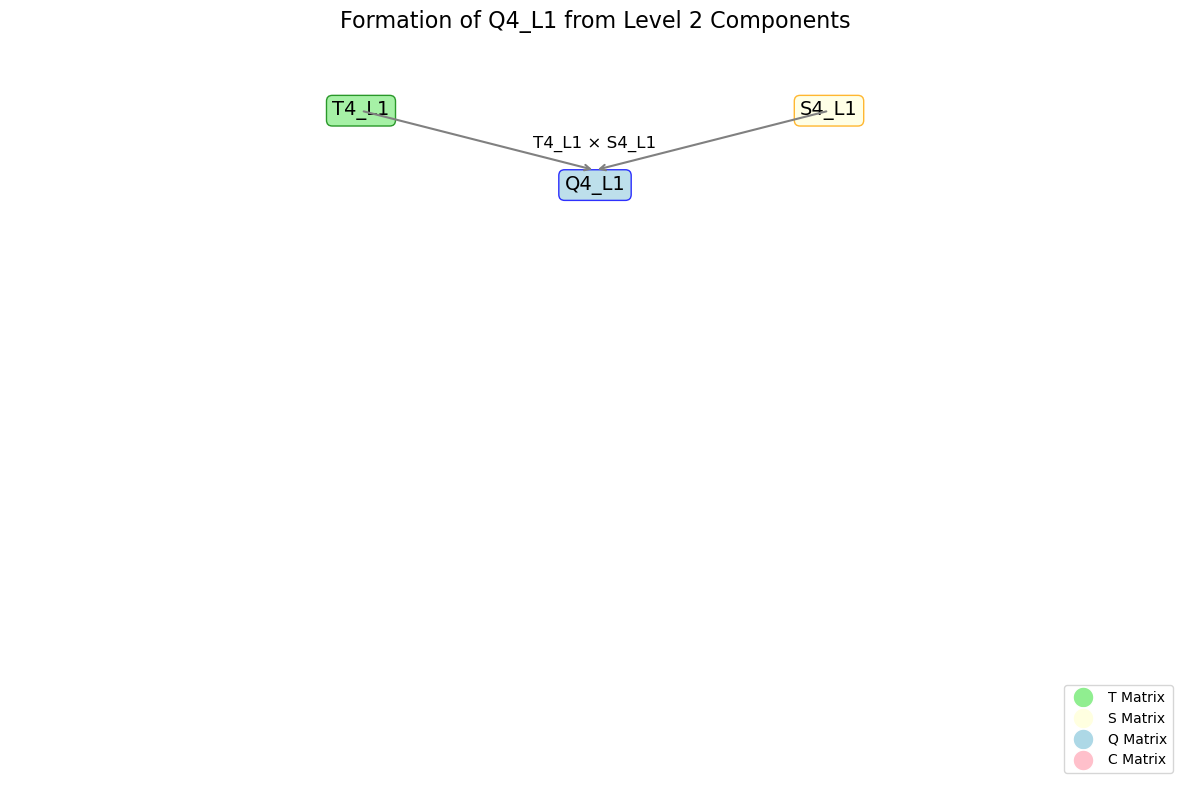

Saved strassen_output/Q5_L1_formation.png


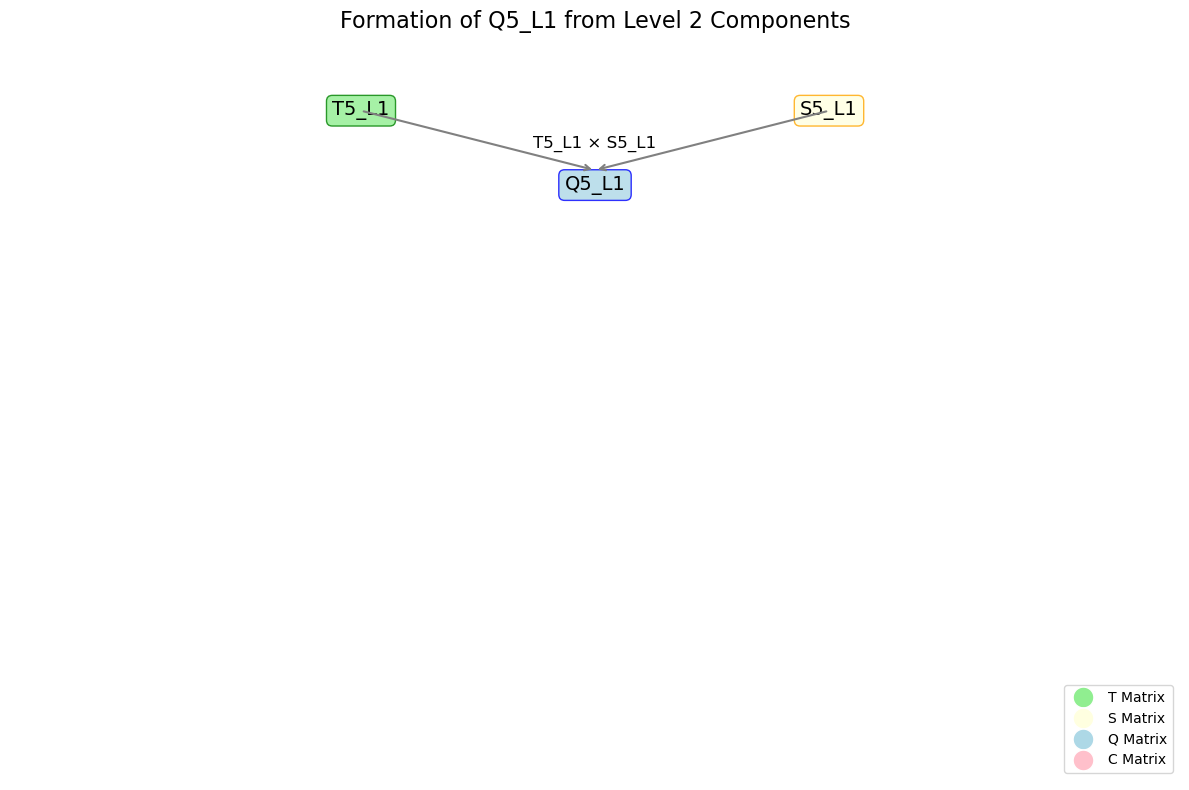

Saved strassen_output/Q6_L1_formation.png


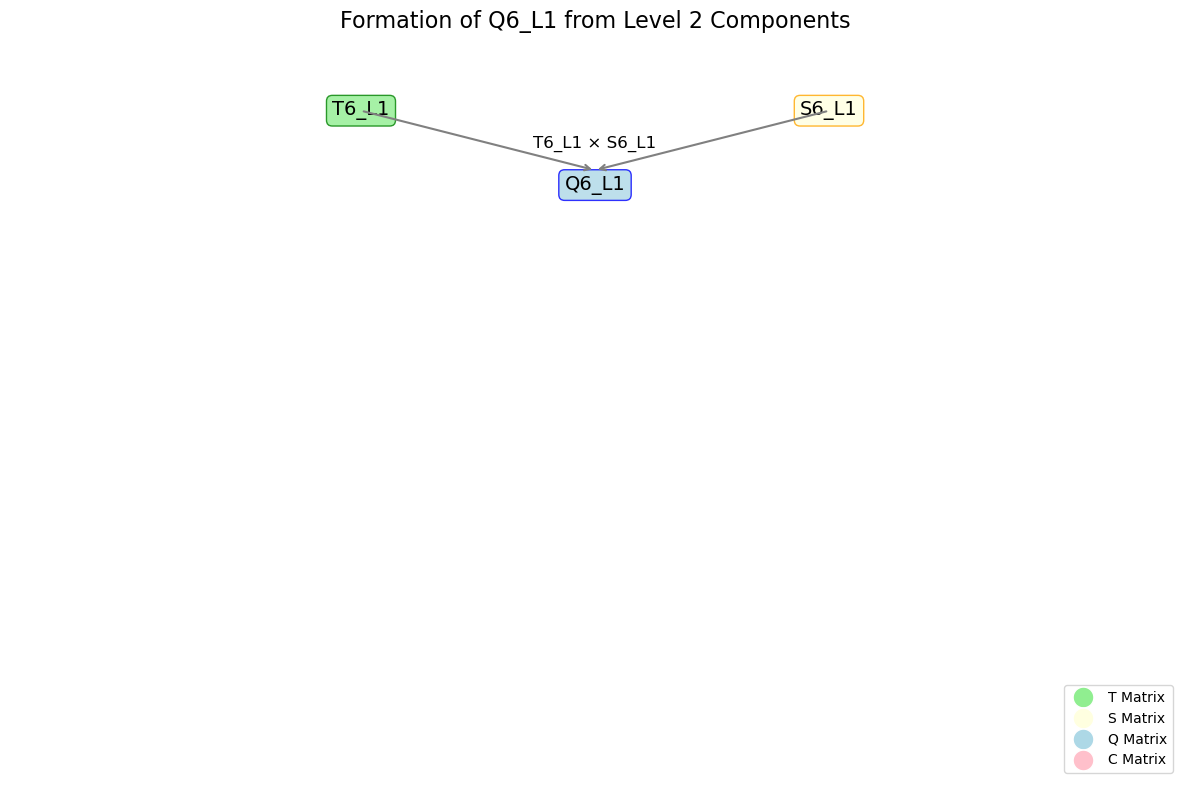

Saved strassen_output/Q7_L1_formation.png


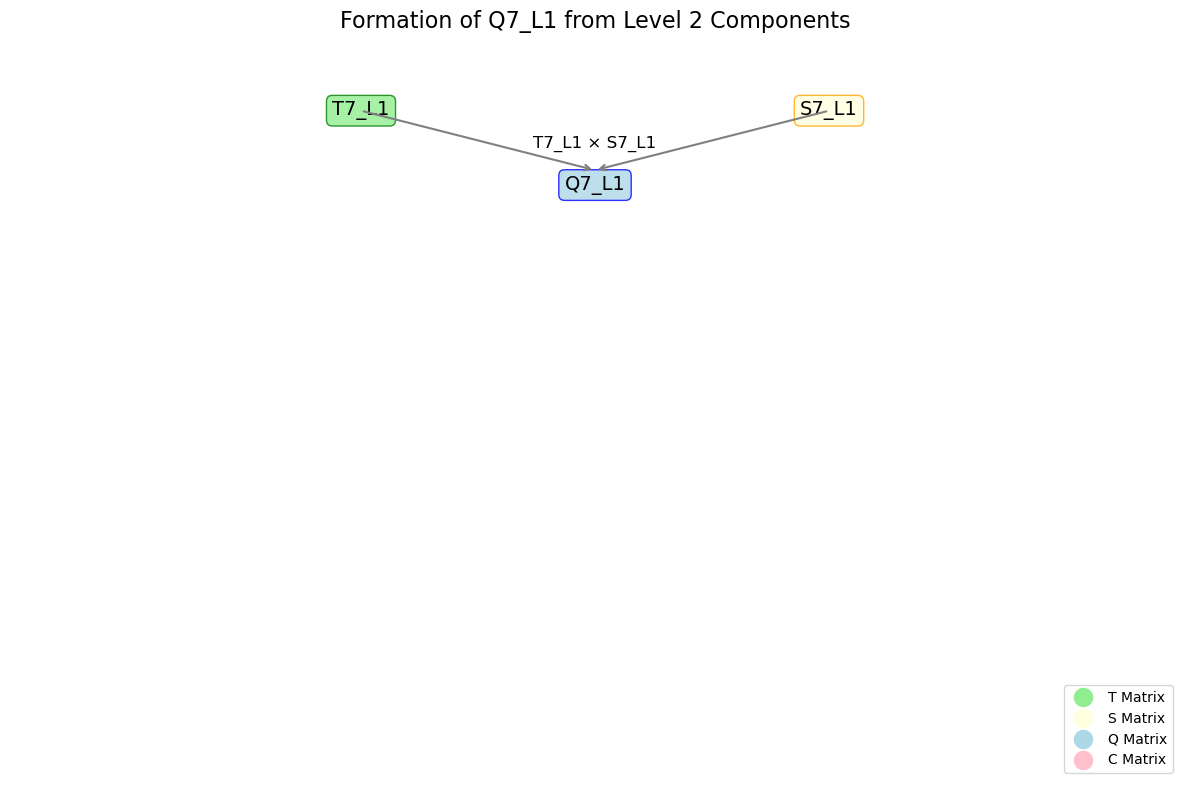


Processing Level 1 - Matrix dimension 8x8
Saved strassen_output/T_matrices_level_1.png


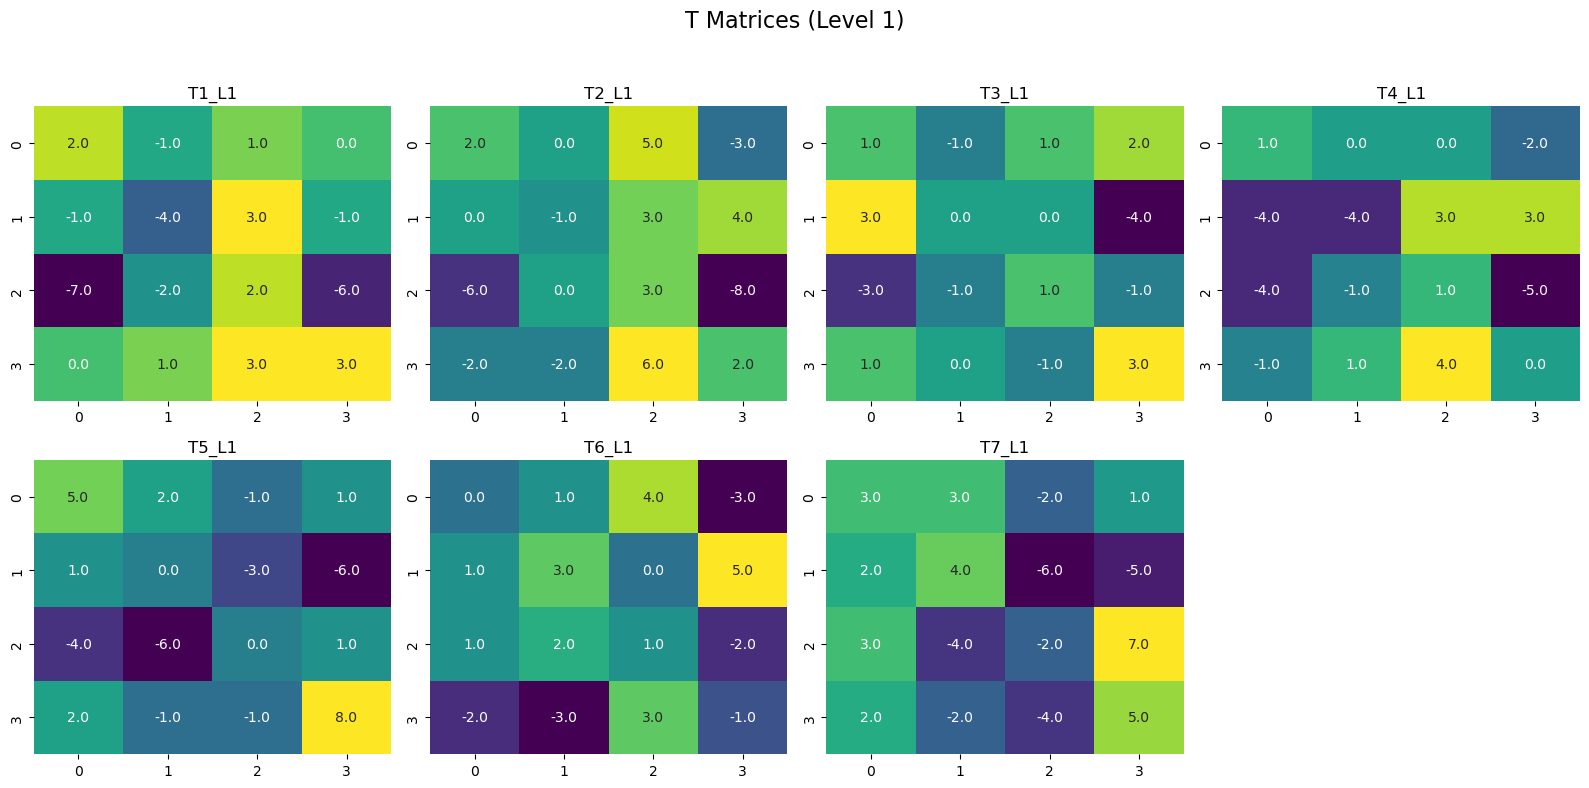

Saved strassen_output/S_matrices_level_1.png


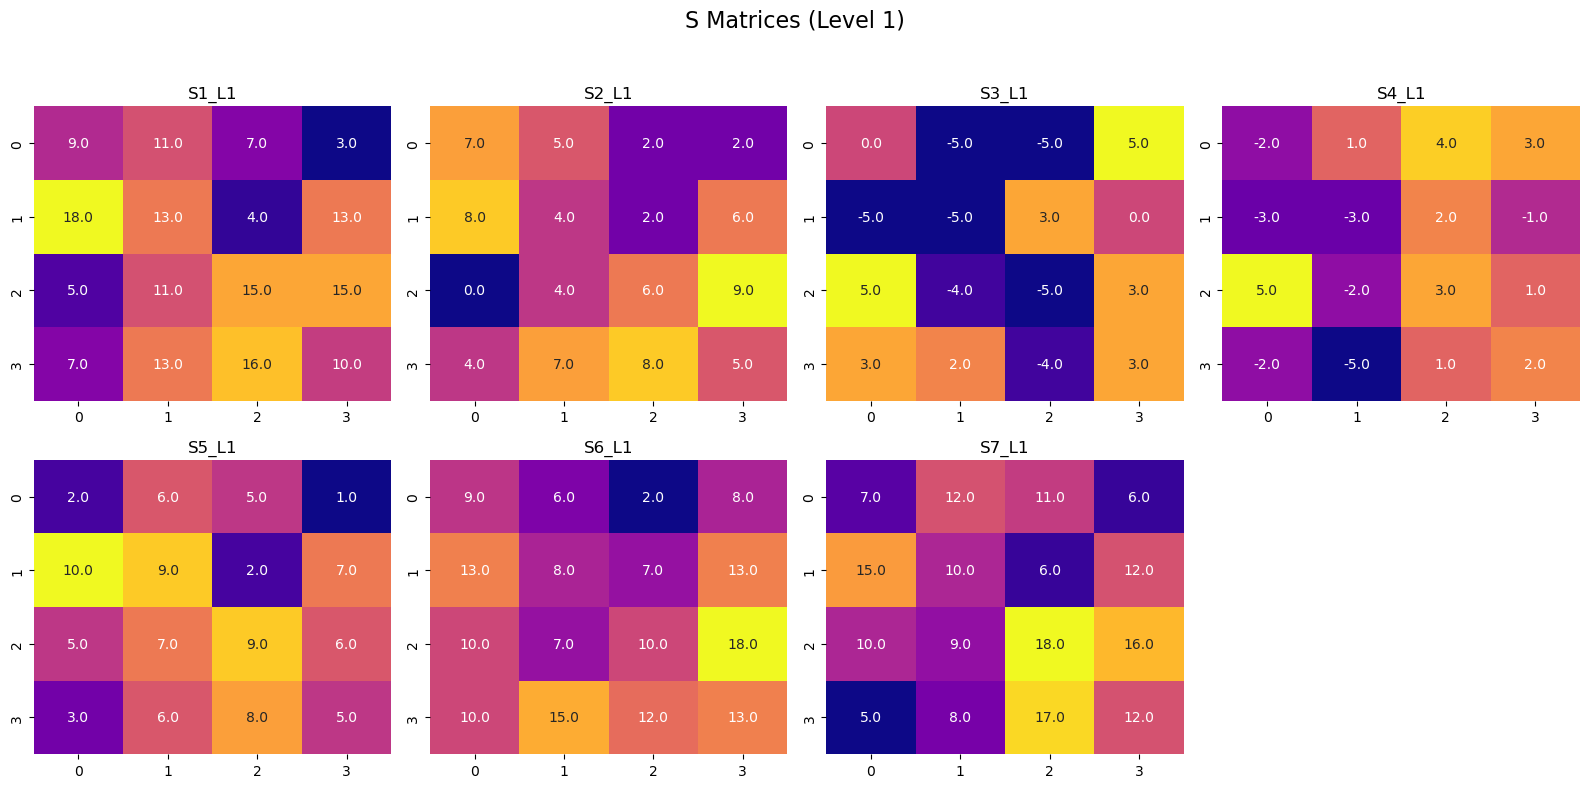

Saved strassen_output/Q_matrices_level_1.png


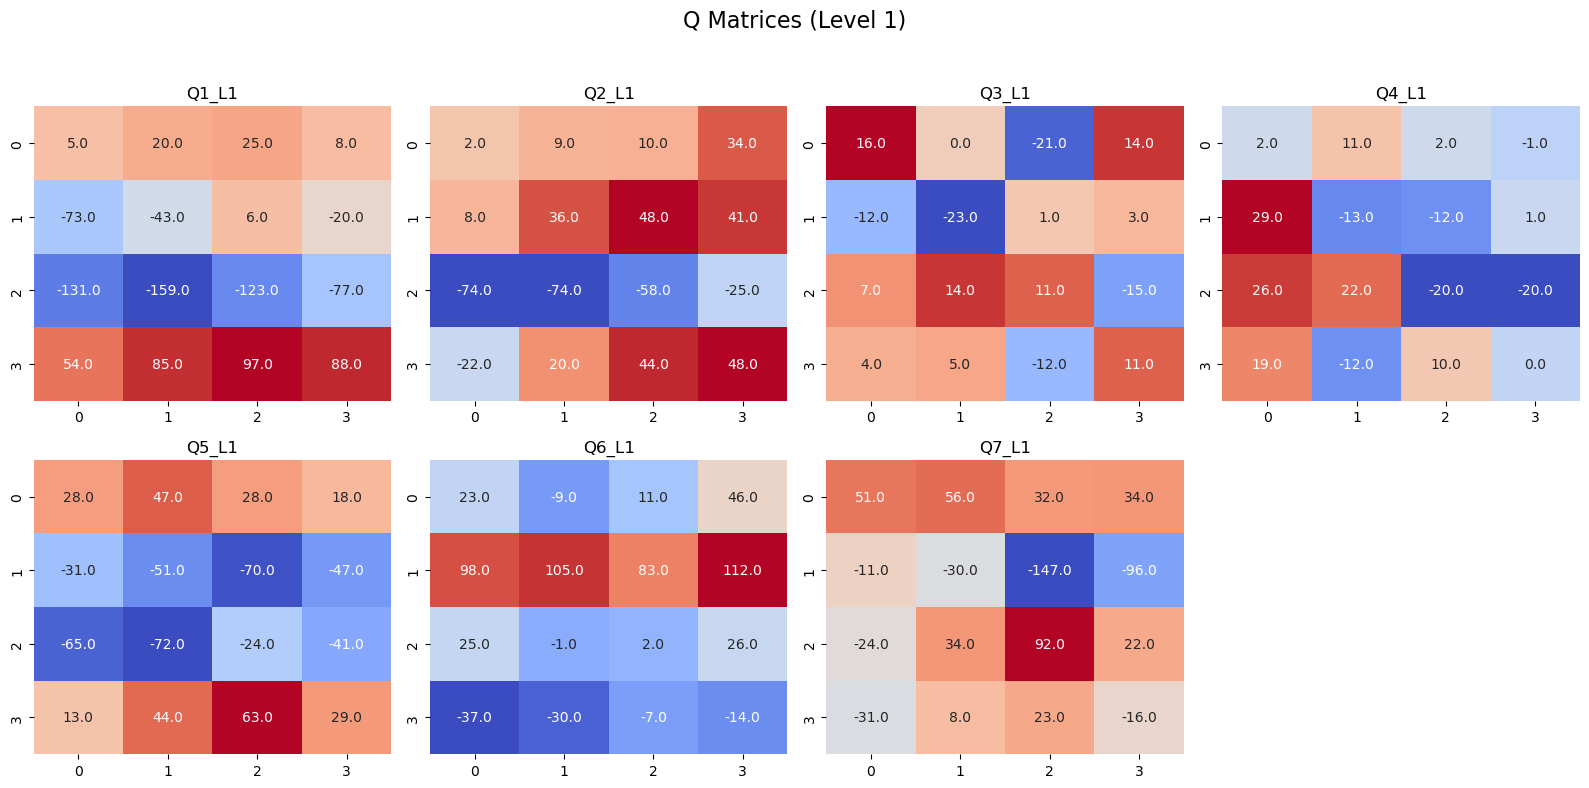

Saved strassen_output/C_matrices_level_1.png


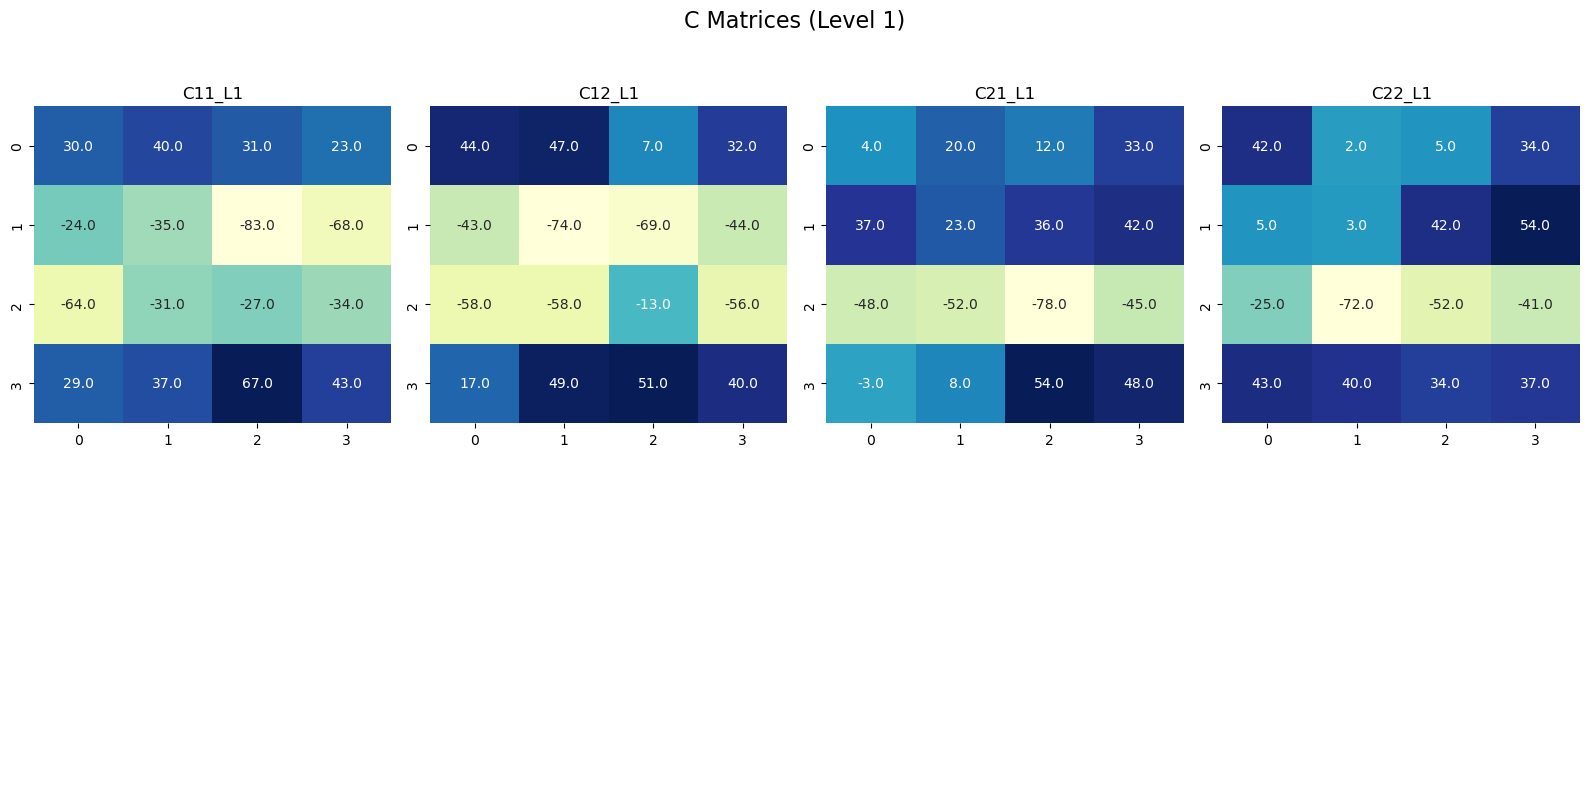

Saved strassen_output/Q1_L1_formation.png


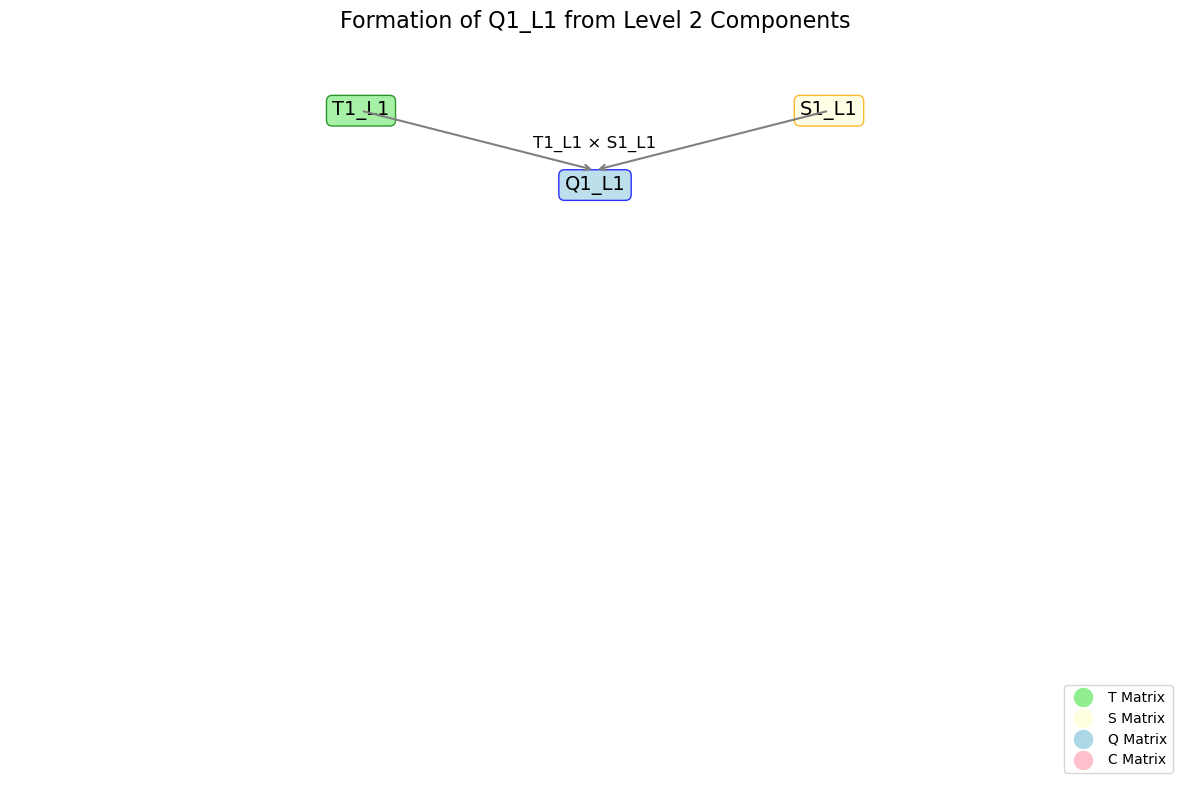

Saved strassen_output/Q2_L1_formation.png


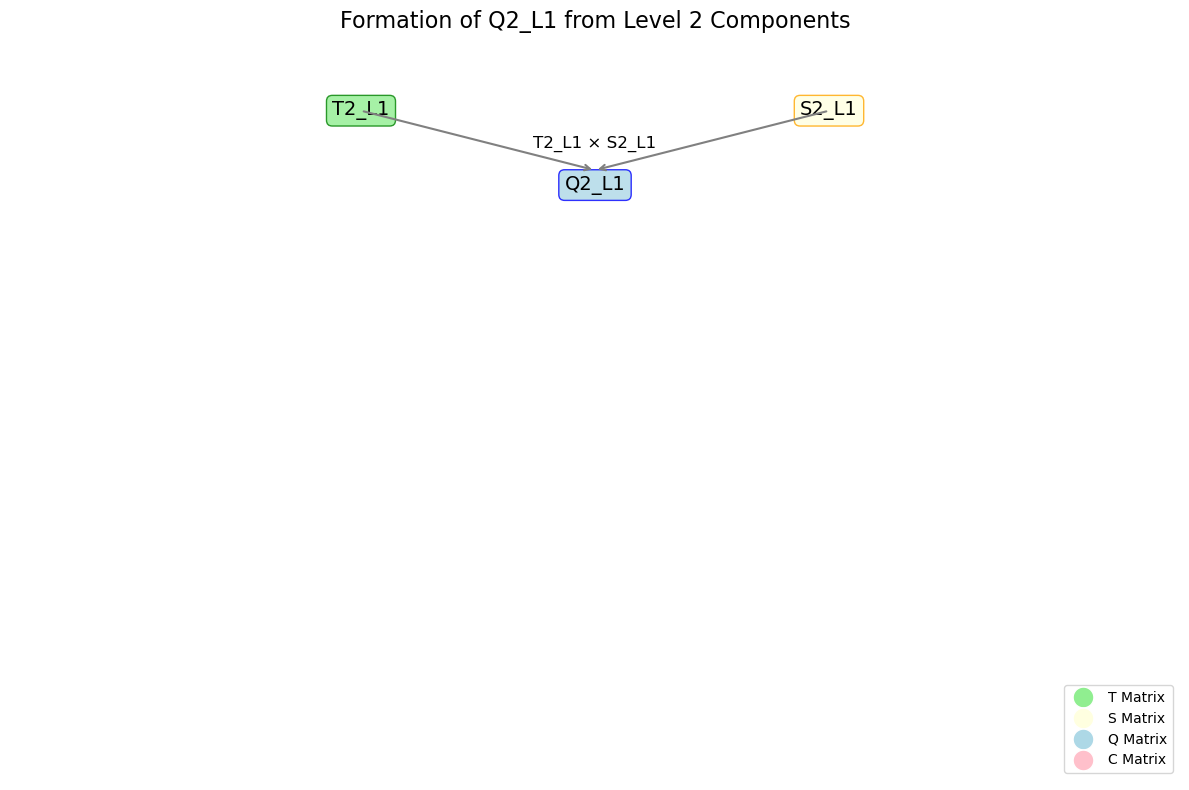

Saved strassen_output/Q3_L1_formation.png


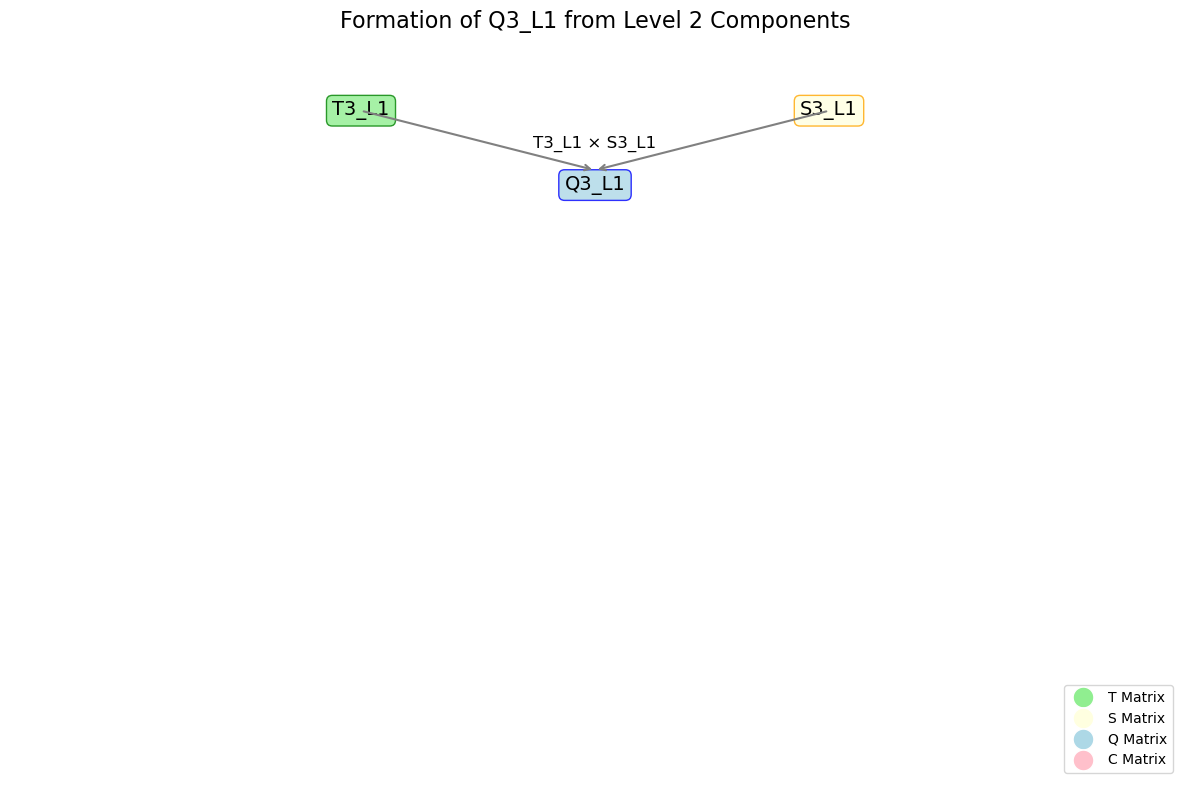

Saved strassen_output/Q4_L1_formation.png


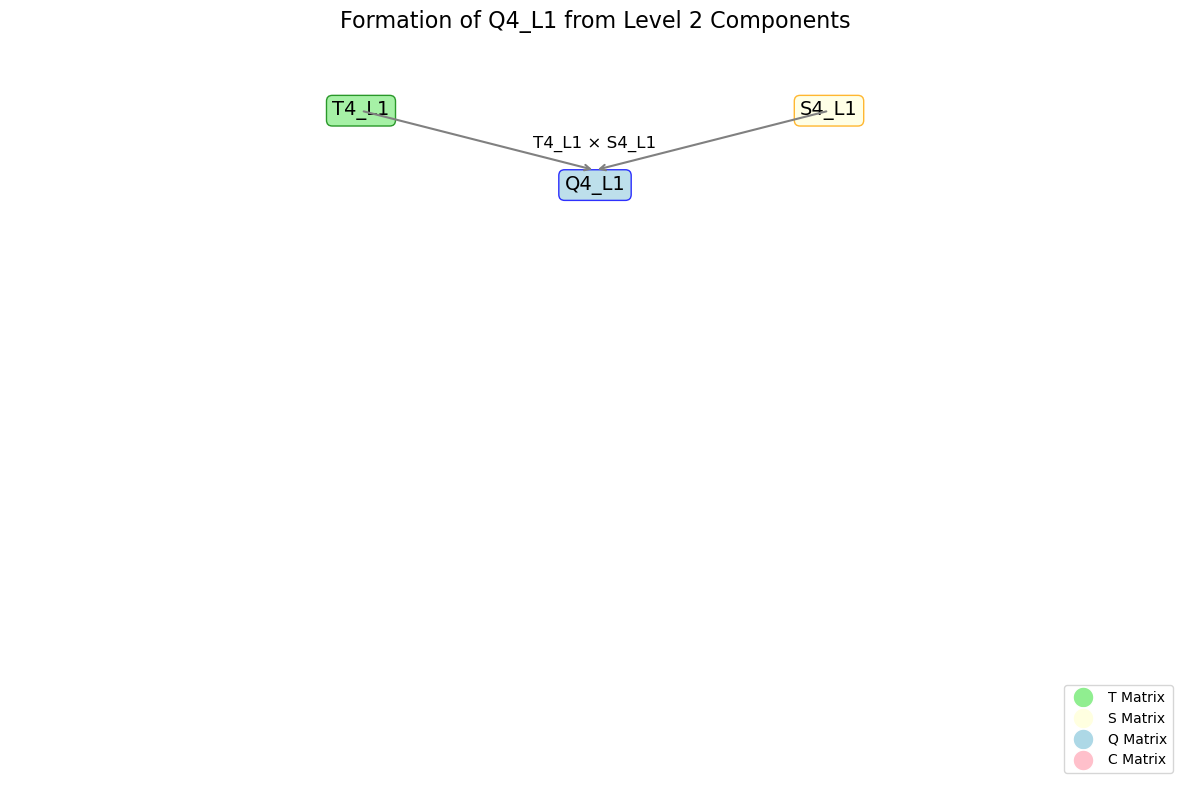

Saved strassen_output/Q5_L1_formation.png


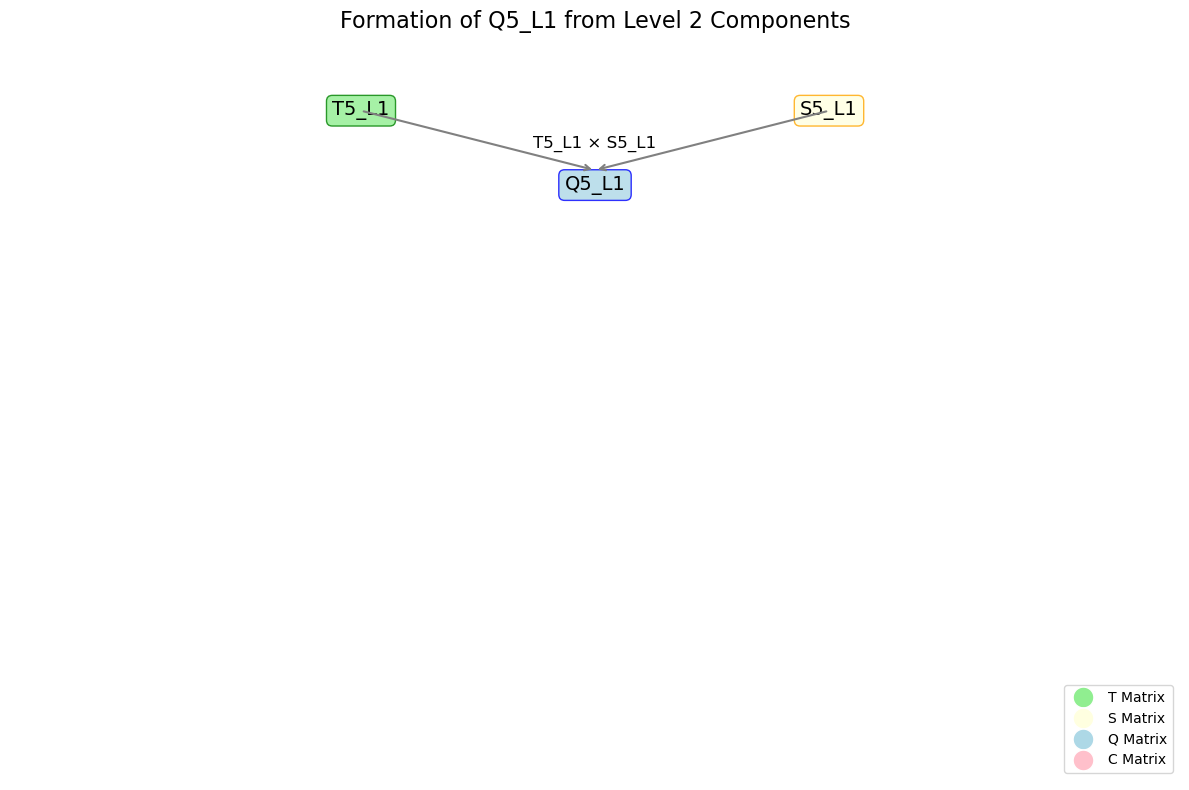

Saved strassen_output/Q6_L1_formation.png


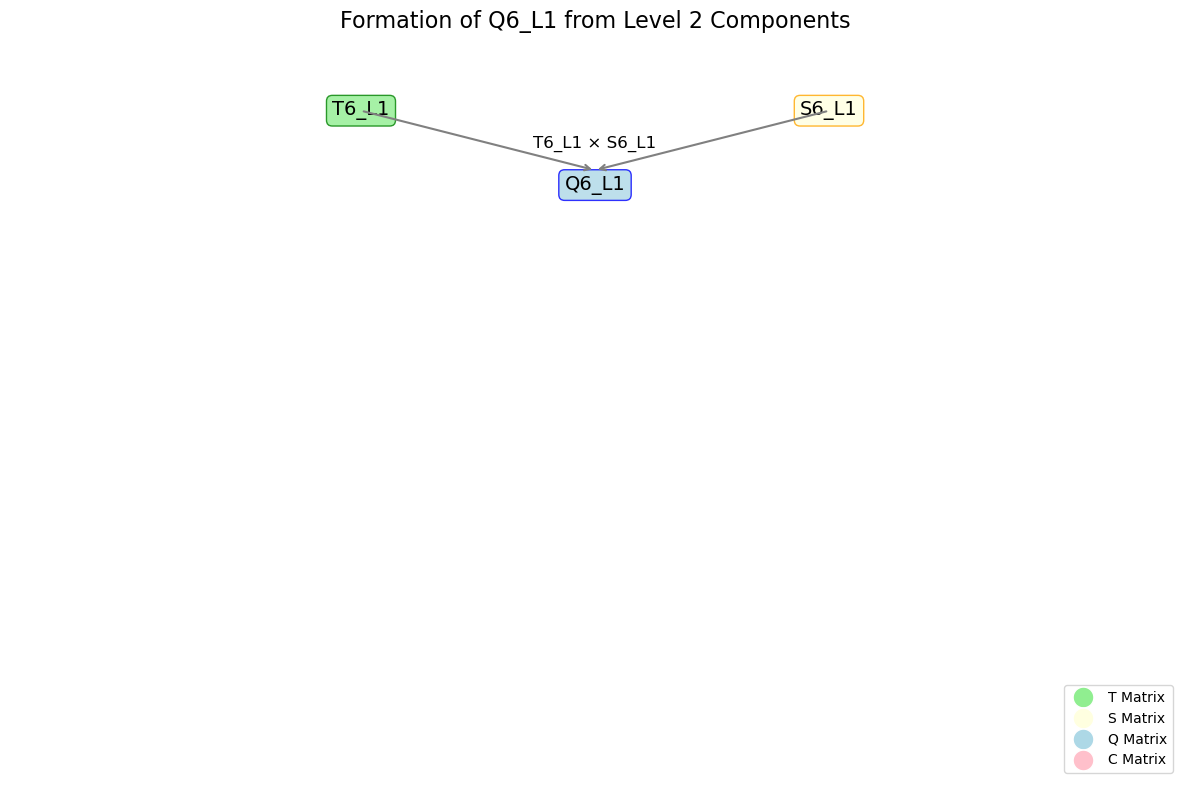

Saved strassen_output/Q7_L1_formation.png


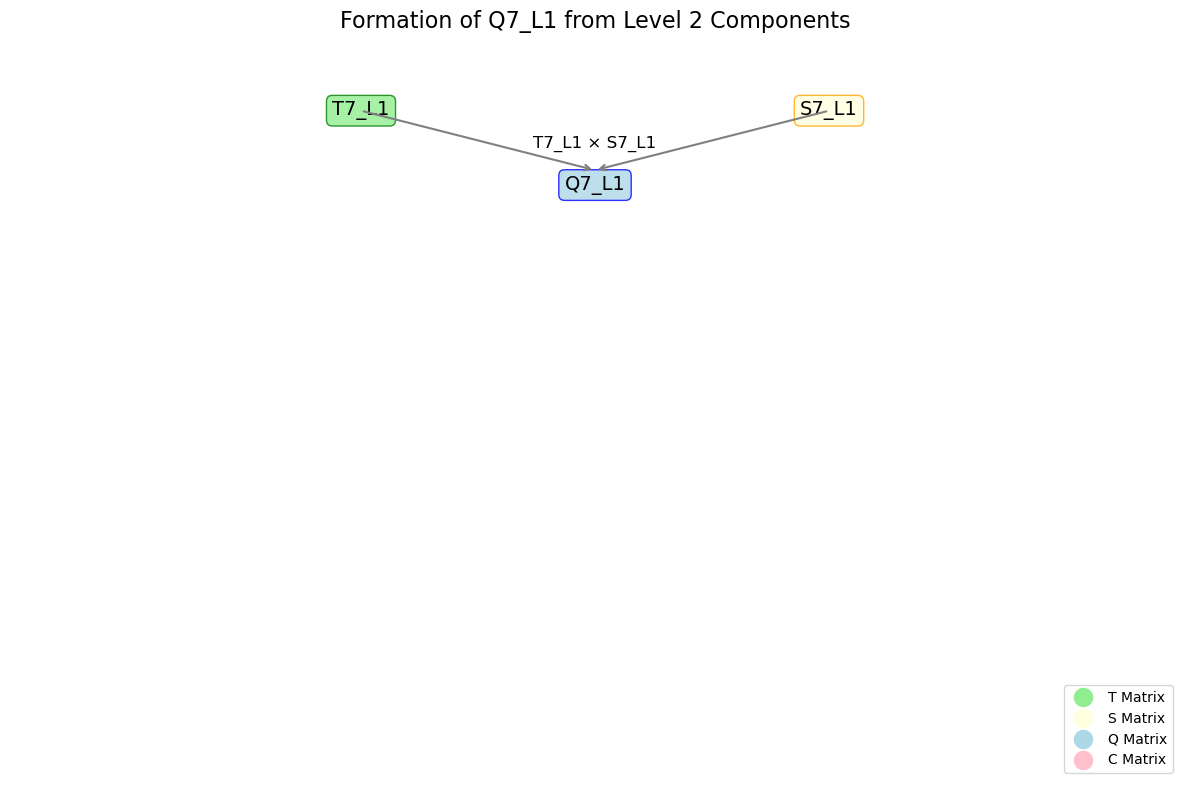

Saved strassen_output/Q_matrices_level_0.png


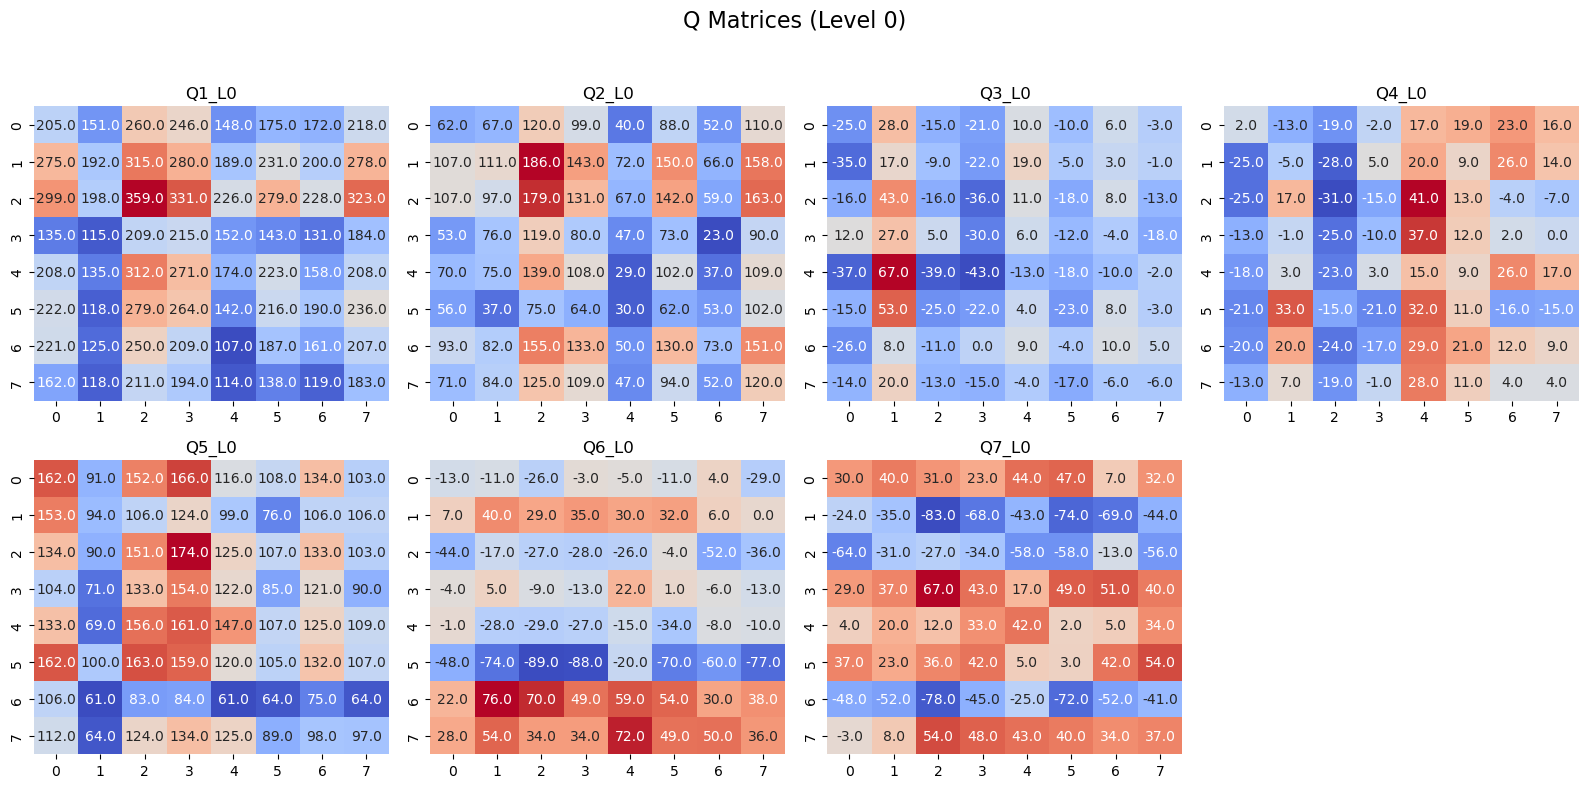

Saved strassen_output/C_matrices_level_0.png


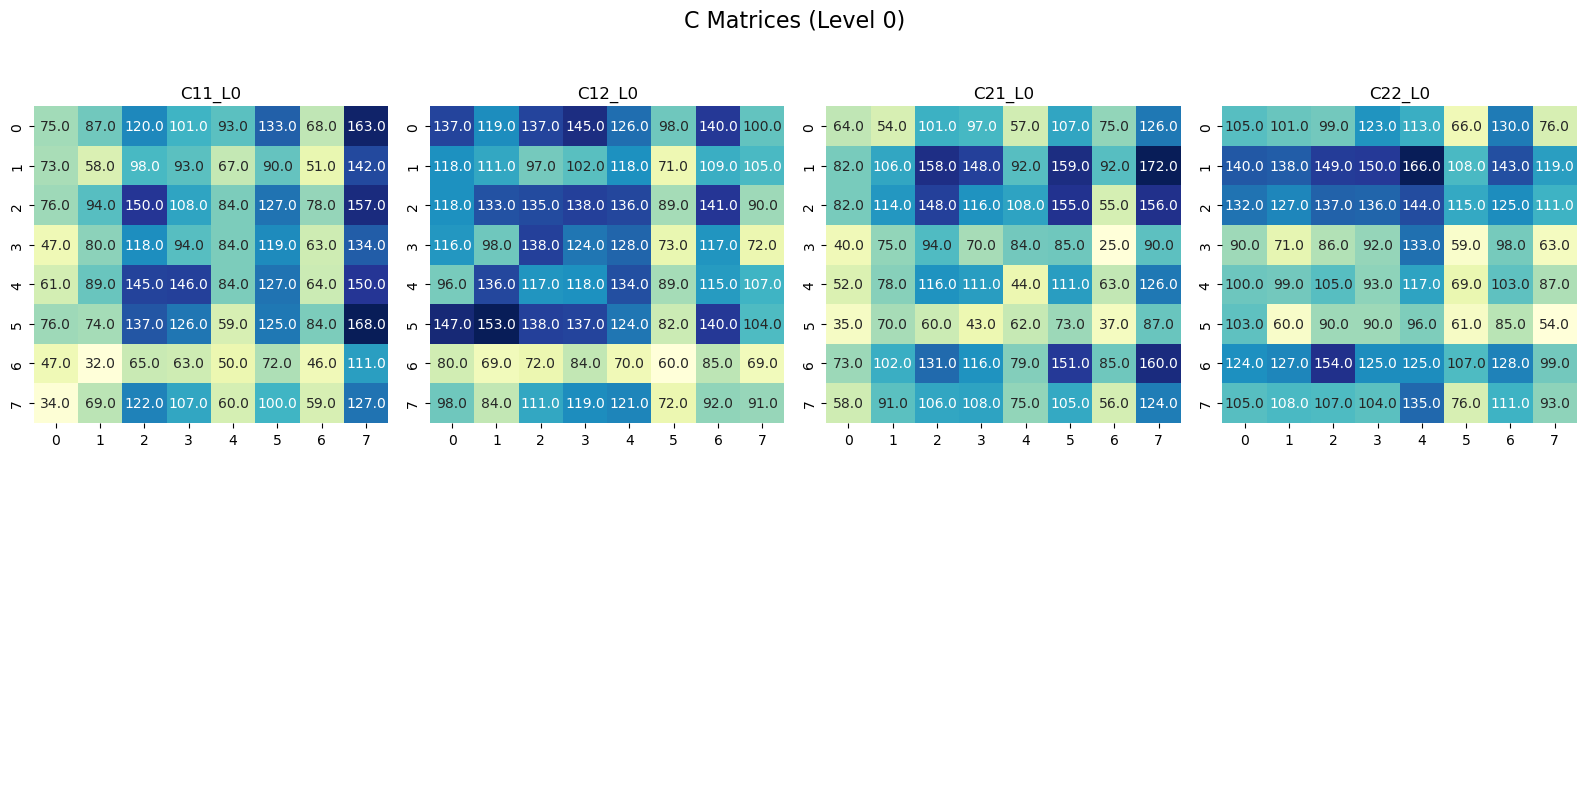

Saved strassen_output/Q1_L0_formation.png


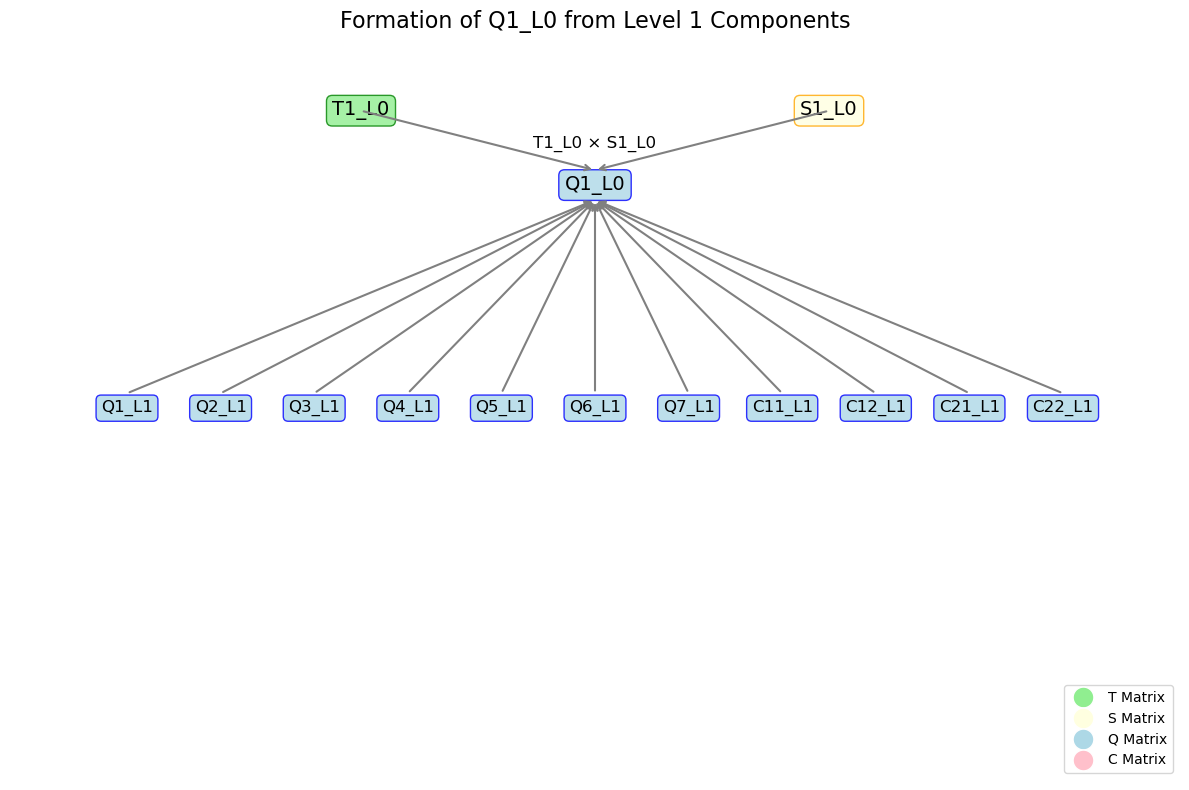

Saved strassen_output/Q2_L0_formation.png


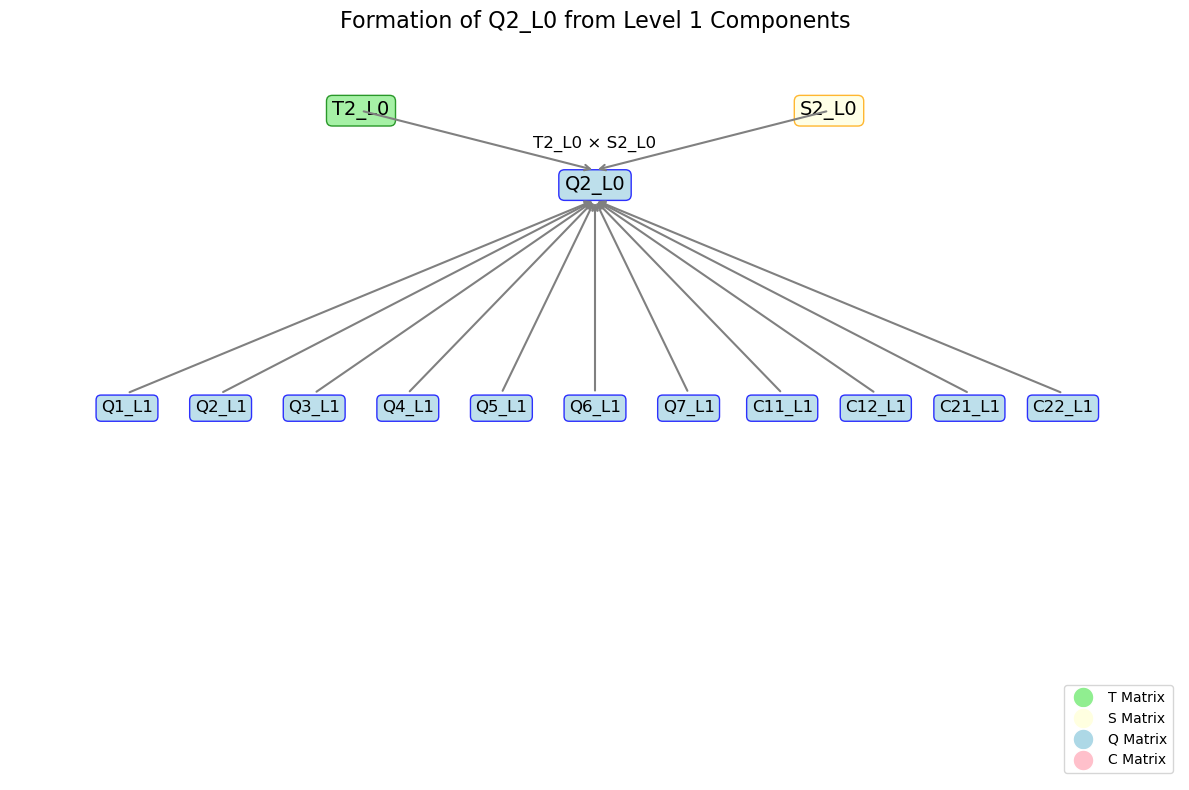

Saved strassen_output/Q3_L0_formation.png


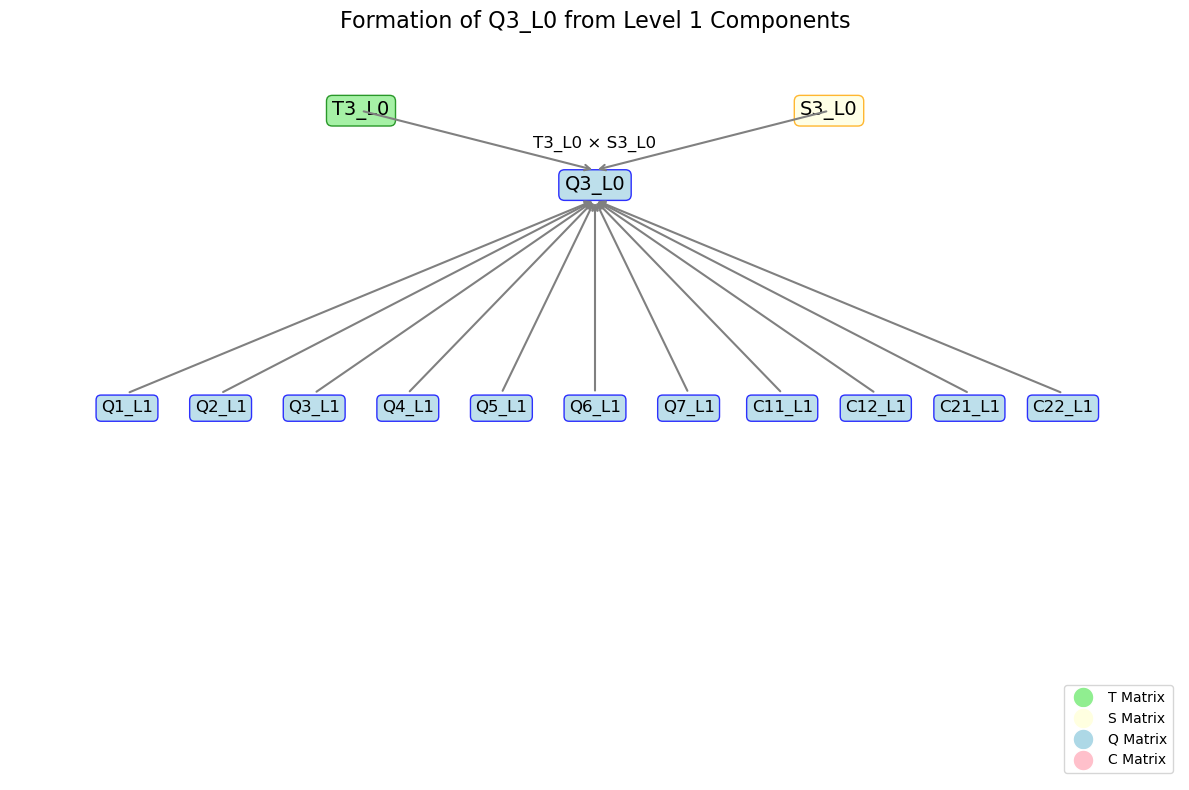

Saved strassen_output/Q4_L0_formation.png


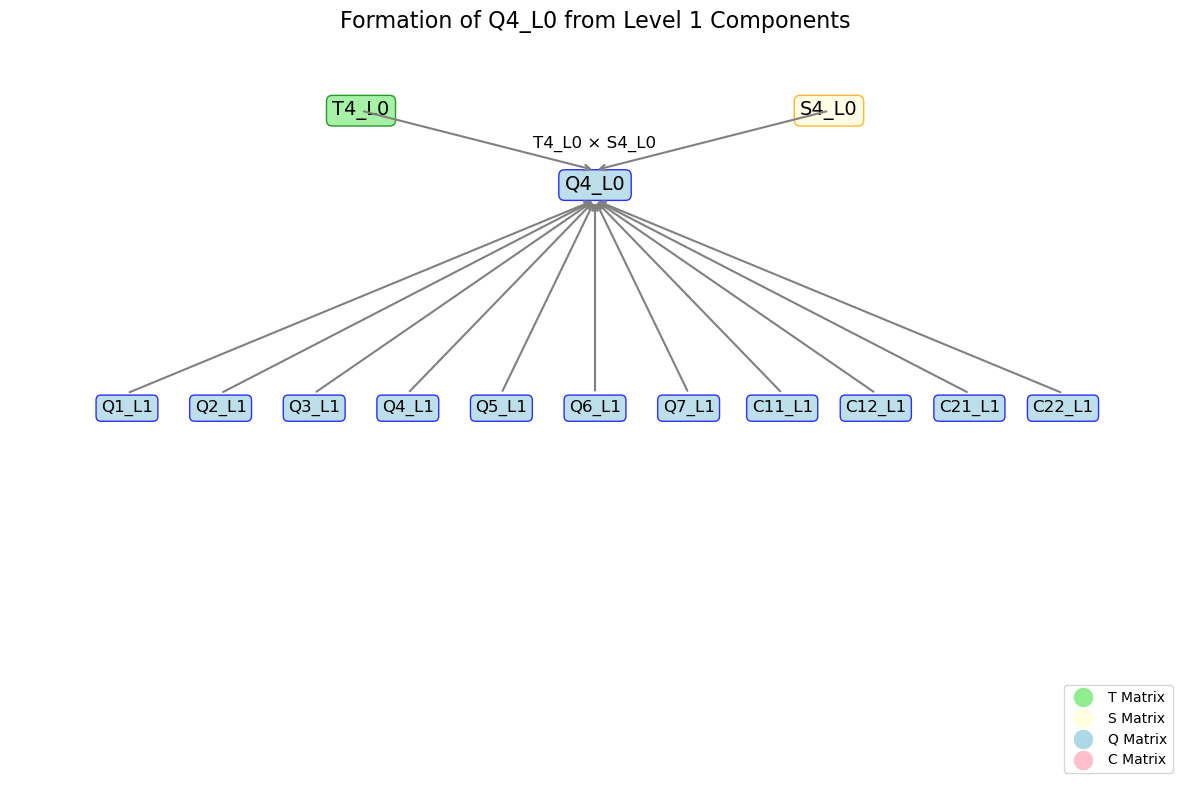

Saved strassen_output/Q5_L0_formation.png


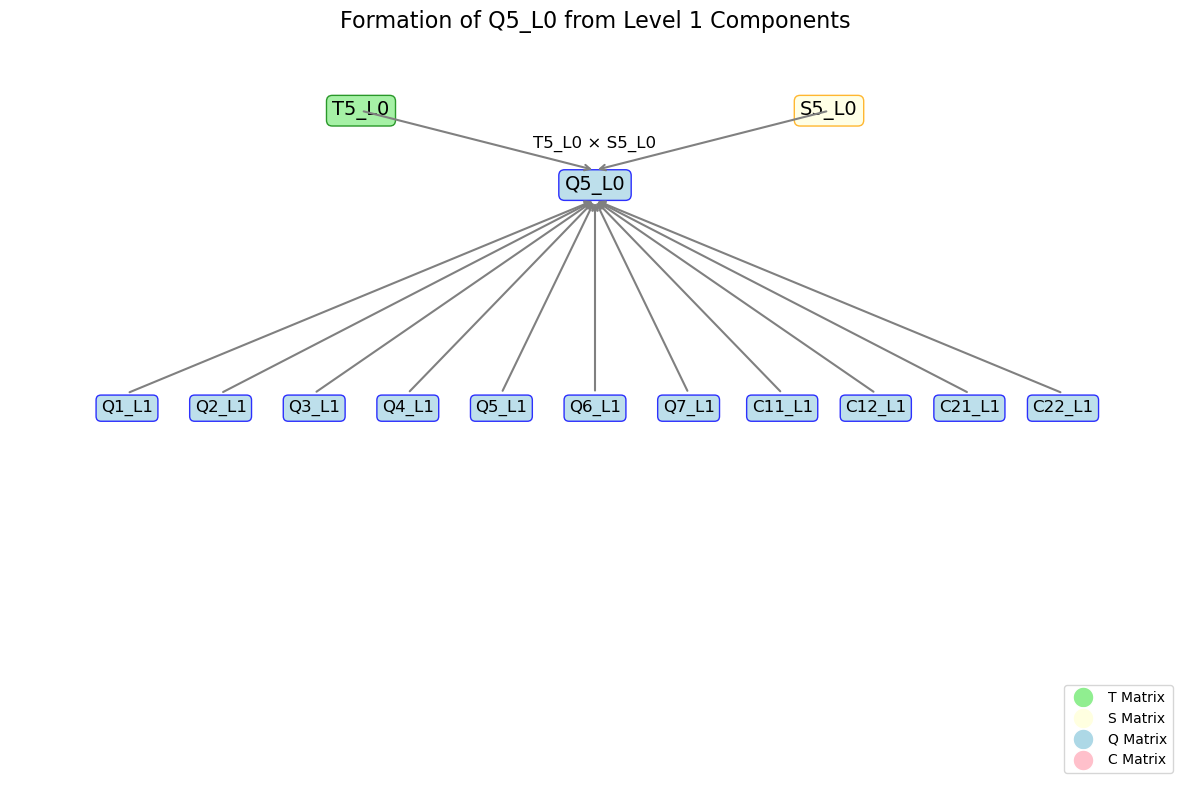

Saved strassen_output/Q6_L0_formation.png


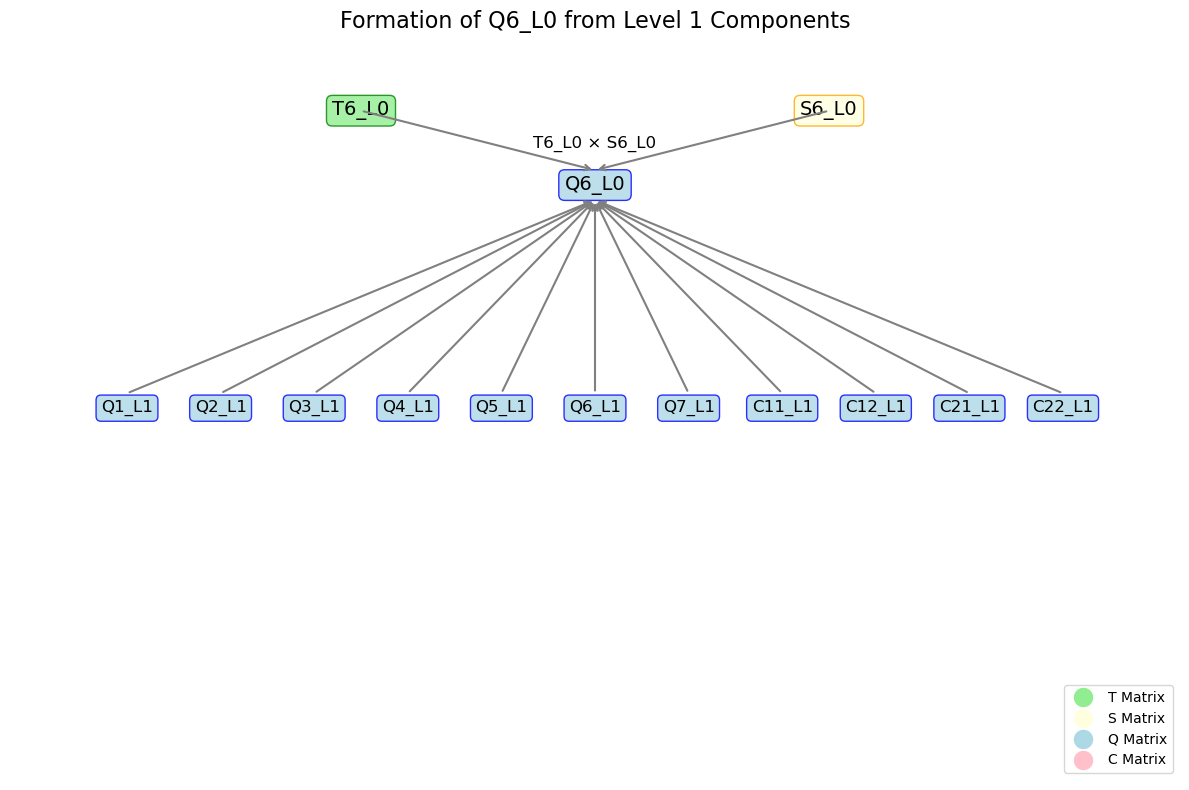

Saved strassen_output/Q7_L0_formation.png


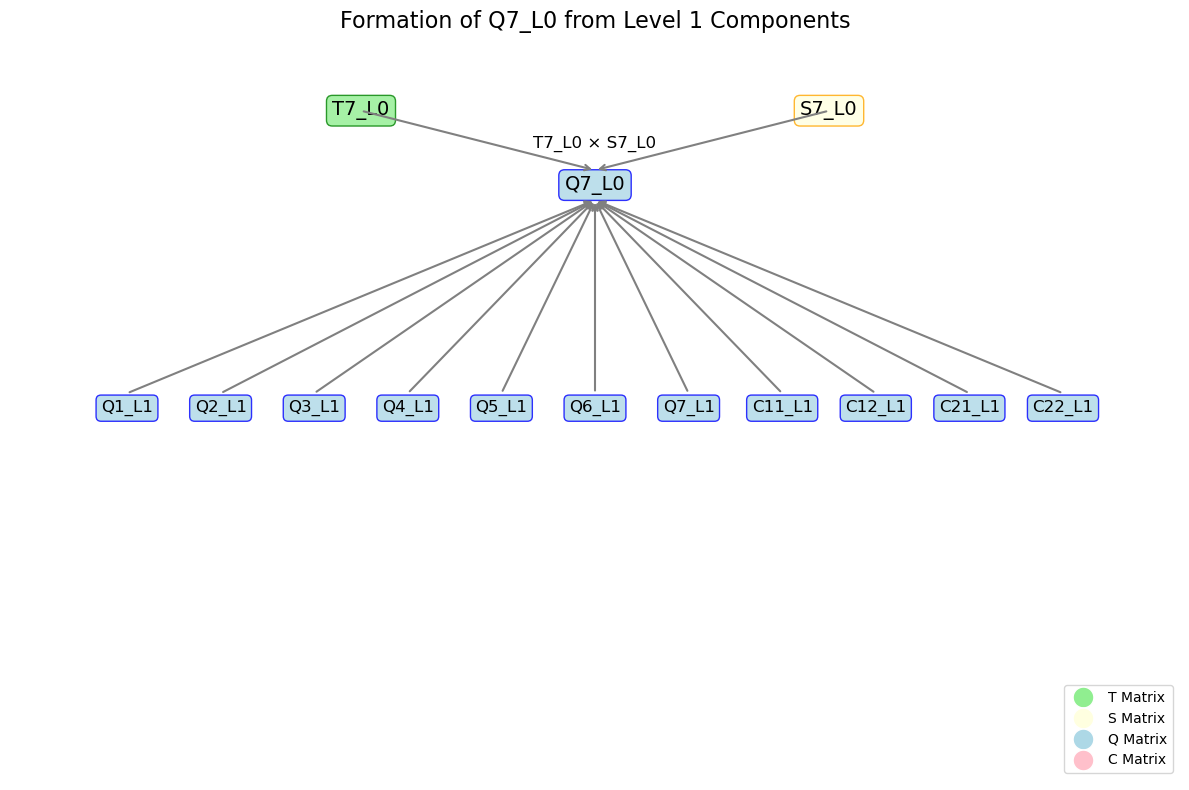

Saved complete recursive tree visualization


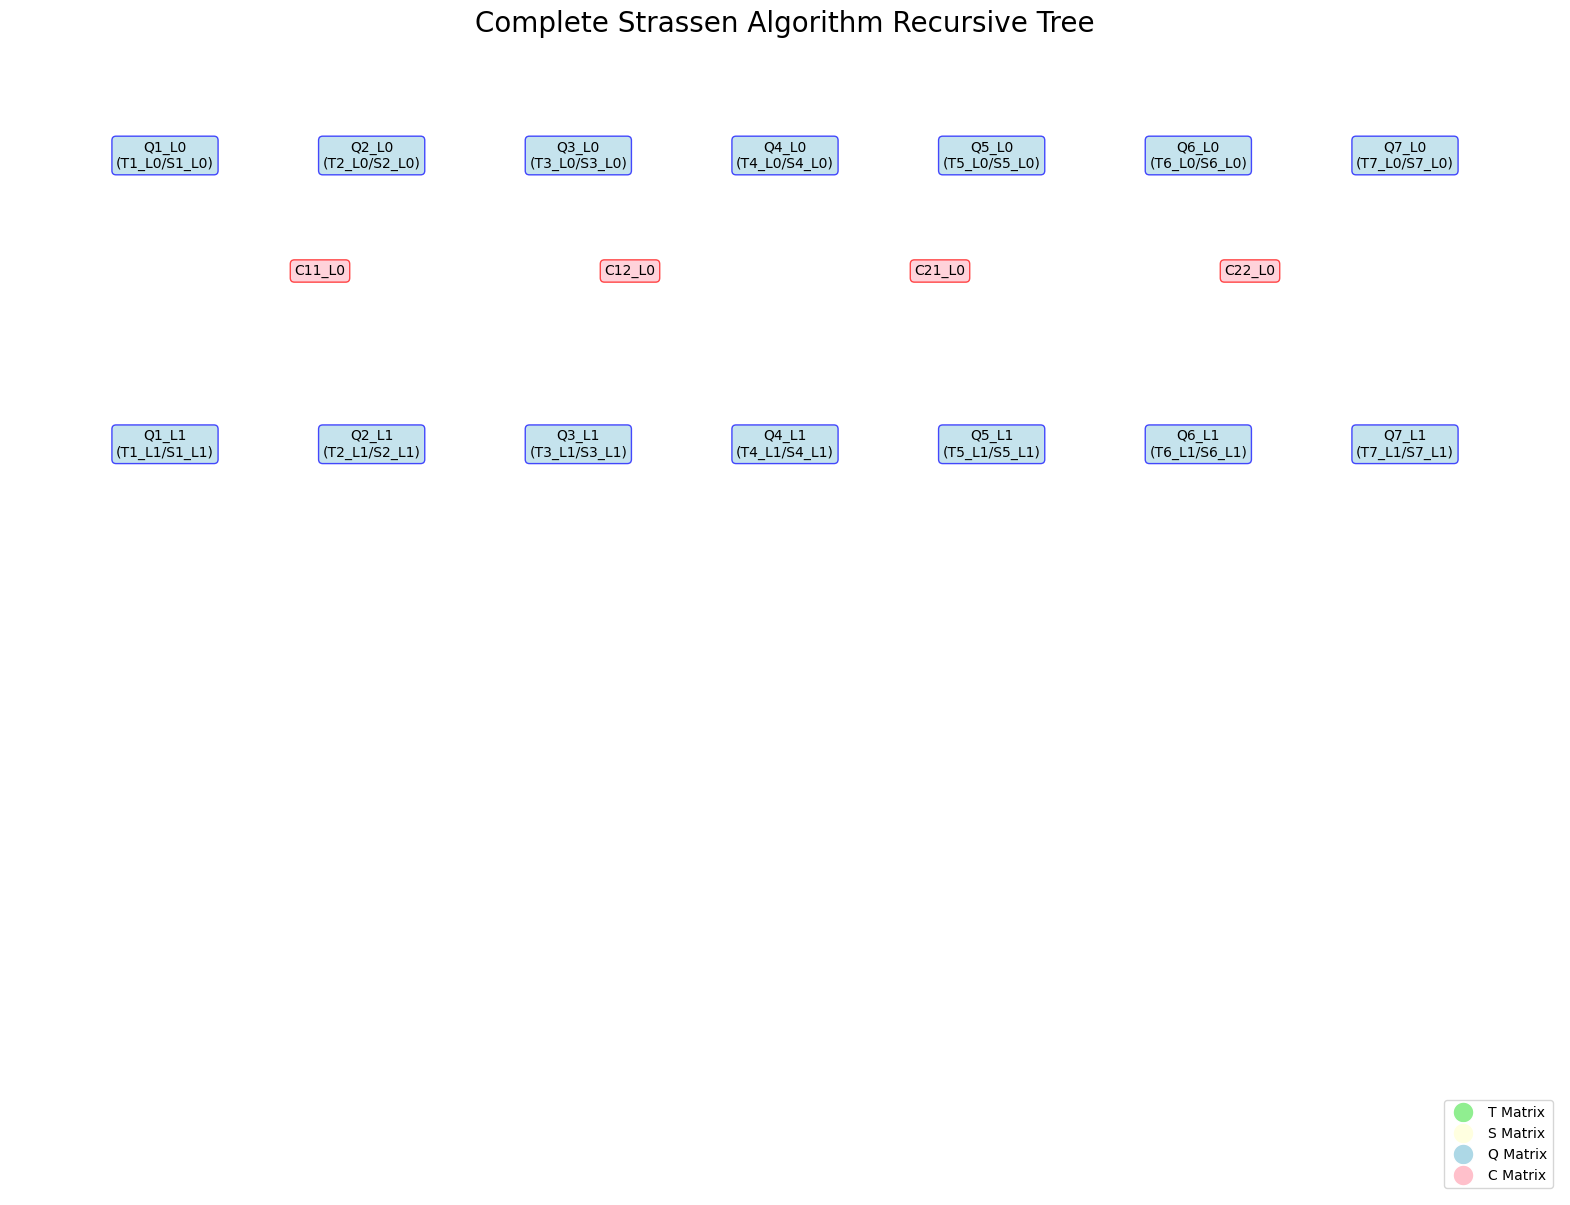

Strassen matrix multiplication completed. Results saved to 'strassen_output' directory.

Strassen Result:


array([[ 75,  87, 120, 101,  93, 133,  68, 163, 137, 119, 137, 145, 126,
         98, 140, 100],
       [ 73,  58,  98,  93,  67,  90,  51, 142, 118, 111,  97, 102, 118,
         71, 109, 105],
       [ 76,  94, 150, 108,  84, 127,  78, 157, 118, 133, 135, 138, 136,
         89, 141,  90],
       [ 47,  80, 118,  94,  84, 119,  63, 134, 116,  98, 138, 124, 128,
         73, 117,  72],
       [ 61,  89, 145, 146,  84, 127,  64, 150,  96, 136, 117, 118, 134,
         89, 115, 107],
       [ 76,  74, 137, 126,  59, 125,  84, 168, 147, 153, 138, 137, 124,
         82, 140, 104],
       [ 47,  32,  65,  63,  50,  72,  46, 111,  80,  69,  72,  84,  70,
         60,  85,  69],
       [ 34,  69, 122, 107,  60, 100,  59, 127,  98,  84, 111, 119, 121,
         72,  92,  91],
       [ 64,  54, 101,  97,  57, 107,  75, 126, 105, 101,  99, 123, 113,
         66, 130,  76],
       [ 82, 106, 158, 148,  92, 159,  92, 172, 140, 138, 149, 150, 166,
        108, 143, 119],
       [ 82, 114, 148, 116, 10


Standard Matrix Multiplication Result:


array([[ 75,  87, 120, 101,  93, 133,  68, 163, 137, 119, 137, 145, 126,
         98, 140, 100],
       [ 73,  58,  98,  93,  67,  90,  51, 142, 118, 111,  97, 102, 118,
         71, 109, 105],
       [ 76,  94, 150, 108,  84, 127,  78, 157, 118, 133, 135, 138, 136,
         89, 141,  90],
       [ 47,  80, 118,  94,  84, 119,  63, 134, 116,  98, 138, 124, 128,
         73, 117,  72],
       [ 61,  89, 145, 146,  84, 127,  64, 150,  96, 136, 117, 118, 134,
         89, 115, 107],
       [ 76,  74, 137, 126,  59, 125,  84, 168, 147, 153, 138, 137, 124,
         82, 140, 104],
       [ 47,  32,  65,  63,  50,  72,  46, 111,  80,  69,  72,  84,  70,
         60,  85,  69],
       [ 34,  69, 122, 107,  60, 100,  59, 127,  98,  84, 111, 119, 121,
         72,  92,  91],
       [ 64,  54, 101,  97,  57, 107,  75, 126, 105, 101,  99, 123, 113,
         66, 130,  76],
       [ 82, 106, 158, 148,  92, 159,  92, 172, 140, 138, 149, 150, 166,
        108, 143, 119],
       [ 82, 114, 148, 116, 10


Results match: True


In [9]:
# Main execution function
def run_strassen_visualization(A, B, max_level=2):
    # Open file to write matrices
    with open("strassen_output/matrices_output.txt", "w") as file:
        file.write("STRASSEN MATRIX MULTIPLICATION WITH RECURSIVE TREE VISUALIZATION\n")
        file.write("="*70 + "\n\n")
        
        # Initialize recursive tree
        recursive_tree = {}
        
        # Perform Strassen multiplication
        print("Starting Strassen multiplication with visualization...")
        result, components = strassen_multiply(A, B, level=0, max_level=max_level, file=file, recursive_tree=recursive_tree)
        
        # Add top level components to recursive tree
        for key, value in components.items():
            recursive_tree[key] = value
        
        # Generate complete recursive tree visualization
        generate_recursive_tree_visualization(recursive_tree, max_level)
        
        # Compute the result using standard matrix multiplication for verification
        standard_result = A @ B
        
        # Write the results to file
        file.write("\nFINAL RESULTS:\n")
        file.write("="*50 + "\n\n")
        file.write("Strassen Result:\n")
        file.write(f"Result = np.array({result.tolist()})\n\n")
        file.write("Standard Matrix Multiplication Result:\n")
        file.write(f"Standard = np.array({standard_result.tolist()})\n\n")
        
        # Check if results match
        is_equal = np.allclose(result, standard_result)
        file.write(f"Results match: {is_equal}\n")
        
    print("Strassen matrix multiplication completed. Results saved to 'strassen_output' directory.")
    # Display the final results
    print("\nStrassen Result:")
    display(result)
    print("\nStandard Matrix Multiplication Result:")
    display(standard_result)
    print(f"\nResults match: {np.allclose(result, standard_result)}")
    
    return result, recursive_tree


result, tree = run_strassen_visualization(A, B, max_level=2)